# Benchmark tRNA secondary structure

In [3]:
import pandas as pd 
import pyranges as pr
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve2d
import math
import torch
from collections import OrderedDict
from plotnine import *
import gzip
import shutil

In [4]:
data_path = 'data'

In [5]:
os.chdir(os.path.join(project_path, 'dna-lm-interactions-paper/code_submission'))
from utils import create_load_matrix_function, plot_matrix_with_roi, plot_weights, plot_ci_matrix
from model_wrappers import ReconstructionModel

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling


In [6]:
species_of_interest = 'saccharomyces_cerevisiae'
get_ci_matrix = create_load_matrix_function(species_of_interest)

Loading dataframes with snp preds...


In [7]:
pr.__version__ # some pyranges versions have a problem getting the reverse complemment sequence right, 0.0.127 does not. Others might retrieve the seqeunce as is without reverse complemmenting it

'0.0.127'

## S. Cerevisiae

In [8]:
species_of_interest = 'saccharomyces_cerevisiae'
fasta_path = os.path.join(data_path, 'Saccharomyces_cerevisiae.R64-1-1.dna.toplevel.fa.gz')
gtf_path = os.path.join(data_path, 'Saccharomyces_cerevisiae.R64-1-1.53.gtf.gz')

In [9]:
gtf_pr = pr.read_gtf(gtf_path)
gtf_df = gtf_pr.df.copy()
gtf_df

Chromosome Source      Feature   Start     End Score Strand Frame  \
0              I    sgd         gene   74019   74823     .      +     .   
1              I    sgd   transcript   74019   74823     .      +     .   
2              I    sgd         exon   74019   74823     .      +     .   
3              I    sgd          CDS   74019   74820     .      +     0   
4              I    sgd  start_codon   74019   74022     .      +     0   
...          ...    ...          ...     ...     ...   ...    ...   ...   
41874        XVI    sgd   transcript  437332  442742     .      -     .   
41875        XVI    sgd         exon  437332  442742     .      -     .   
41876        XVI    sgd         gene  854934  856257     .      -     .   
41877        XVI    sgd   transcript  854934  856257     .      -     .   
41878        XVI    sgd         exon  854934  856257     .      -     .   

         gene_id gene_name gene_source          gene_biotype transcript_id  \
0        YAL037W       NaN         sgd        protein_coding           NaN   
1        YAL037W       NaN         sgd        protein_coding  YAL037W_mRNA   
2        YAL037W       NaN         sgd        protein_coding  YAL037W_mRNA   
3        YAL037W       NaN         sgd        protein_coding  YAL037W_mRNA   
4        YAL037W       NaN         sgd        protein_coding  YAL037W_mRNA   
...          ...       ...         ...                   ...           ...   
41874  YPL060C-A       NaN         sgd  transposable_element     YPL060C-A   
41875  YPL060C-A       NaN         sgd  transposable_element     YPL060C-A   
41876  YPR158C-C       NaN         sgd  transposable_element           NaN   
41877  YPR158C-C       NaN         sgd  transposable_element     YPR158C-C   
41878  YPR158C-C       NaN         sgd  transposable_element     YPR158C-C   

      transcript_name transcript_source    transcript_biotype exon_number  \
0                 NaN               NaN                   NaN         NaN   
1                 NaN               sgd        protein_coding         NaN   
2                 NaN               sgd        protein_coding           1   
3                 NaN               sgd        protein_coding           1   
4                 NaN               sgd        protein_coding           1   
...               ...               ...                   ...         ...   
41874             NaN               sgd  transposable_element         NaN   
41875             NaN               sgd  transposable_element           1   
41876             NaN               NaN                   NaN         NaN   
41877             NaN               sgd  transposable_element         NaN   
41878             NaN               sgd  transposable_element           1   

               exon_id protein_id  
0                  NaN        NaN  
1                  NaN        NaN  
2      YAL037W_mRNA-E1        NaN  
3                  NaN    YAL037W  
4                  NaN        NaN  
...                ...        ...  
41874              NaN        NaN  
41875     YPL060C-A-E1        NaN  
41876              NaN        NaN  
41877              NaN        NaN  
41878     YPR158C-C-E1        NaN  

[41879 rows x 19 columns]

In [8]:
from torch.utils.data import Dataset, DataLoader

class GeneMatrix(Dataset):
    def __init__(self, gene_ids):
        """
        Args:
            gene_ids (list): List of gene IDs.
        """
        self.gene_ids = gene_ids

    def __len__(self):
        return len(self.gene_ids)

    def __getitem__(self, idx):
        gene_id = self.gene_ids[idx]
        ci_matrix = get_ci_matrix(gene_id).unsqueeze(0) #add a dimension for the channel

        return ci_matrix

In [9]:
dataset = GeneMatrix(all_genes)

batch_size = 16
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

### Get the gtf annotated tRNA of each gene:

In [10]:
gtf_df.gene_biotype.unique()

array(['protein_coding', 'tRNA', 'pseudogene', 'snoRNA', 'ncRNA',
       'transposable_element', 'snRNA', 'rRNA'], dtype=object)

In [11]:
gtf_tRNA_df = gtf_df[(gtf_df.gene_biotype == "tRNA")&(gtf_df.Feature=='gene')].copy()
gtf_tRNA_df

Chromosome Source Feature   Start     End Score Strand Frame    gene_id  \
50             I    sgd    gene  181140  181254     .      +     .   tL(CAA)A   
66             I    sgd    gene  139151  139254     .      +     .   tP(UGG)A   
70             I    sgd    gene  166266  166339     .      +     .   tA(UGC)A   
638            I    sgd    gene  182521  182603     .      -     .   tS(AGA)A   
823           II    sgd    gene  197493  197567     .      +     .   tI(AAU)B   
...          ...    ...     ...     ...     ...   ...    ...   ...        ...   
40992        XVI    sgd    gene  769206  769302     .      -     .   tK(UUU)P   
41002        XVI    sgd    gene   56168   56274     .      -     .   tW(CCA)P   
41120        XVI    sgd    gene  775764  775836     .      -     .  tC(GCA)P2   
41489        XVI    sgd    gene  210191  210263     .      -     .   tE(UUC)P   
41534        XVI    sgd    gene  560197  560289     .      -     .  tF(GAA)P1   

      gene_name gene_source gene_biotype transcript_id transcript_name  \
50        SUP56         sgd         tRNA           NaN             NaN   
66         TRN1         sgd         tRNA           NaN             NaN   
70         TGA1         sgd         tRNA           NaN             NaN   
638         NaN         sgd         tRNA           NaN             NaN   
823         NaN         sgd         tRNA           NaN             NaN   
...         ...         ...          ...           ...             ...   
40992       NaN         sgd         tRNA           NaN             NaN   
41002       NaN         sgd         tRNA           NaN             NaN   
41120       NaN         sgd         tRNA           NaN             NaN   
41489       NaN         sgd         tRNA           NaN             NaN   
41534       NaN         sgd         tRNA           NaN             NaN   

      transcript_source transcript_biotype exon_number exon_id protein_id  
50                  NaN                NaN         NaN     NaN        NaN  
66                  NaN                NaN         NaN     NaN        NaN  
70                  NaN                NaN         NaN     NaN        NaN  
638                 NaN                NaN         NaN     NaN        NaN  
823                 NaN                NaN         NaN     NaN        NaN  
...                 ...                ...         ...     ...        ...  
40992               NaN                NaN         NaN     NaN        NaN  
41002               NaN                NaN         NaN     NaN        NaN  
41120               NaN                NaN         NaN     NaN        NaN  
41489               NaN                NaN         NaN     NaN        NaN  
41534               NaN                NaN         NaN     NaN        NaN  

[299 rows x 19 columns]

In [12]:
assert gtf_tRNA_df.shape[0] == len(gtf_tRNA_df['gene_id'].unique()) # assert there are no duplicate gene_ids

In [13]:
#Here we get the tRNA sequences from a zipped fasta file
#unzip the fasta file in the current directory and read the file

temp_unzipped_fasta_path = f'{species_of_interest}_temp.fa'
with gzip.open(fasta_path, 'rb') as f_in:
    with open(temp_unzipped_fasta_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


tRNA_pr = pr.PyRanges(gtf_tRNA_df)
tRNA_pr.seq = pr.get_sequence(tRNA_pr, path=temp_unzipped_fasta_path)
tRNA_df = tRNA_pr.df
tRNA_df.rename({'gene_id':'tRNA_gene_id', 'transcript_id':'tRNA_transcript_id'}, axis=1, inplace=True)
tRNA_pr = pr.PyRanges(tRNA_df)

#remove the unzipped fasta file
if os.path.exists(temp_unzipped_fasta_path):
    os.remove(temp_unzipped_fasta_path)

In [14]:
tRNA_df

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
0            I    sgd    gene  181140  181254     .      +     .     tL(CAA)A   
1            I    sgd    gene  139151  139254     .      +     .     tP(UGG)A   
2            I    sgd    gene  166266  166339     .      +     .     tA(UGC)A   
3            I    sgd    gene  182521  182603     .      -     .     tS(AGA)A   
4           II    sgd    gene  197493  197567     .      +     .     tI(AAU)B   
..         ...    ...     ...     ...     ...   ...    ...   ...          ...   
294        XVI    sgd    gene  769206  769302     .      -     .     tK(UUU)P   
295        XVI    sgd    gene   56168   56274     .      -     .     tW(CCA)P   
296        XVI    sgd    gene  775764  775836     .      -     .    tC(GCA)P2   
297        XVI    sgd    gene  210191  210263     .      -     .     tE(UUC)P   
298        XVI    sgd    gene  560197  560289     .      -     .    tF(GAA)P1   

    gene_name gene_source gene_biotype tRNA_transcript_id transcript_name  \
0       SUP56         sgd         tRNA                NaN             NaN   
1        TRN1         sgd         tRNA                NaN             NaN   
2        TGA1         sgd         tRNA                NaN             NaN   
3         NaN         sgd         tRNA                NaN             NaN   
4         NaN         sgd         tRNA                NaN             NaN   
..        ...         ...          ...                ...             ...   
294       NaN         sgd         tRNA                NaN             NaN   
295       NaN         sgd         tRNA                NaN             NaN   
296       NaN         sgd         tRNA                NaN             NaN   
297       NaN         sgd         tRNA                NaN             NaN   
298       NaN         sgd         tRNA                NaN             NaN   

    transcript_source transcript_biotype exon_number exon_id protein_id  \
0                 NaN                NaN         NaN     NaN        NaN   
1                 NaN                NaN         NaN     NaN        NaN   
2                 NaN                NaN         NaN     NaN        NaN   
3                 NaN                NaN         NaN     NaN        NaN   
4                 NaN                NaN         NaN     NaN        NaN   
..                ...                ...         ...     ...        ...   
294               NaN                NaN         NaN     NaN        NaN   
295               NaN                NaN         NaN     NaN        NaN   
296               NaN                NaN         NaN     NaN        NaN   
297               NaN                NaN         NaN     NaN        NaN   
298               NaN                NaN         NaN     NaN        NaN   

                                                   seq  
0    GGTTGTTTGGCCGAGCGGTCTAAGGCGCCTGATTCAAGAAATATCT...  
1    GGGCGTGTGGTCTAGTGGTATGATTCTCGCTTTGGGCGACTTCCTG...  
2    GGGCACATGGCGCAGTTGGTAGCGCGCTTCCCTTGCAAGGAAGAGG...  
3    GGCAACTTGGCCGAGTGGTTAAGGCGAAAGATTAGAAATCTTTTGG...  
4    GGTCTCTTGGCCCAGTTGGTTAAGGCACCGTGCTAATAACGCGGGG...  
..                                                 ...  
294  TCCTTGTTAGCTCAGTTGGTAGAGCGTTCGGCTTTTAAGCGCATTT...  
295  GAAGCGGTGGCTCAATGGTAGAGCTTTCGACTCCAATTAAATCTTG...  
296  GCTCGTATGGCGCAGTGGTAGCGCAGCAGATTGCAAATCTGTTGGT...  
297  TCCGATATAGTGTAACGGCTATCACATCACGCTTTCACCGTGGAGA...  
298  GCGGATTTAGCTCAGTTGGGAGAGCGCCAGACTGAAGAAAAAACTT...  

[299 rows x 20 columns]

<AxesSubplot: >

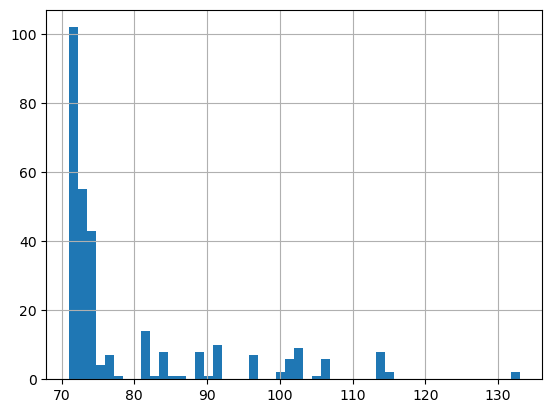

In [15]:
tRNA_df.apply(lambda row: len(row.seq), axis=1).hist(bins=50)

In [16]:
tRNA_df.apply(lambda row: len(row.seq), axis=1).median()

73.0

the median length of a tRNA gene is 73 nucleotides in S cerevisiae

In [17]:
# Now let's get the start of the start codon for each gene
gtf_start_codons_df = gtf_df[gtf_df.Feature=='start_codon'].copy()

# the start codon is for some transcripts split in 2 parts because there is an intron in between. The DNA LM sees the upstream of both parts

def get_start_codon_start_id(row):
    if row['Strand'] == '+':
        return str(row['Start']) + '_' + row['transcript_id']
    else:
        return str(row['End']) + '_' + row['transcript_id']

gtf_start_codons_df['start_codon_start_id'] = gtf_start_codons_df.apply(get_start_codon_start_id, axis=1)
gtf_start_codons_df

Chromosome Source      Feature   Start     End Score Strand Frame  \
4              I    sgd  start_codon   74019   74022     .      +     0   
10             I    sgd  start_codon  124878  124881     .      +     0   
16             I    sgd  start_codon  142173  142176     .      +     0   
24             I    sgd  start_codon   45898   45901     .      +     0   
30             I    sgd  start_codon   84668   84671     .      +     0   
...          ...    ...          ...     ...     ...   ...    ...   ...   
41838        XVI    sgd  start_codon  172752  172755     .      -     0   
41844        XVI    sgd  start_codon   52668   52671     .      -     0   
41850        XVI    sgd  start_codon  895761  895764     .      -     0   
41856        XVI    sgd  start_codon  725141  725144     .      -     0   
41862        XVI    sgd  start_codon  222770  222773     .      -     0   

         gene_id gene_name gene_source    gene_biotype   transcript_id  \
4        YAL037W       NaN         sgd  protein_coding    YAL037W_mRNA   
10       YAL016W      TPD3         sgd  protein_coding    YAL016W_mRNA   
16       YAL003W      EFB1         sgd  protein_coding    YAL003W_mRNA   
24       YAL053W      FLC2         sgd  protein_coding    YAL053W_mRNA   
30     YAL031W-A       NaN         sgd  protein_coding  YAL031W-A_mRNA   
...          ...       ...         ...             ...             ...   
41838    YPL199C       NaN         sgd  protein_coding    YPL199C_mRNA   
41844    YPL259C      APM1         sgd  protein_coding    YPL259C_mRNA   
41850    YPR179C      HDA3         sgd  protein_coding    YPR179C_mRNA   
41856    YPR096C       NaN         sgd  protein_coding    YPR096C_mRNA   
41862    YPL174C    NIP100         sgd  protein_coding    YPL174C_mRNA   

      transcript_name transcript_source transcript_biotype exon_number  \
4                 NaN               sgd     protein_coding           1   
10               TPD3               sgd     protein_coding           1   
16               EFB1               sgd     protein_coding           1   
24               FLC2               sgd     protein_coding           1   
30                NaN               sgd     protein_coding           1   
...               ...               ...                ...         ...   
41838             NaN               sgd     protein_coding           1   
41844            APM1               sgd     protein_coding           1   
41850            HDA3               sgd     protein_coding           1   
41856             NaN               sgd     protein_coding           1   
41862          NIP100               sgd     protein_coding           1   

      exon_id protein_id  start_codon_start_id  
4         NaN        NaN    74019_YAL037W_mRNA  
10        NaN        NaN   124878_YAL016W_mRNA  
16        NaN        NaN   142173_YAL003W_mRNA  
24        NaN        NaN    45898_YAL053W_mRNA  
30        NaN        NaN  84668_YAL031W-A_mRNA  
...       ...        ...                   ...  
41838     NaN        NaN   172755_YPL199C_mRNA  
41844     NaN        NaN    52671_YPL259C_mRNA  
41850     NaN        NaN   895764_YPR179C_mRNA  
41856     NaN        NaN   725144_YPR096C_mRNA  
41862     NaN        NaN   222773_YPL174C_mRNA  

[6601 rows x 20 columns]

In [18]:
gtf_start_codons_pr = pr.PyRanges(gtf_start_codons_df)
# check which tRNA overlap with start codon + 1000bp
#extend start codon by 1000bp
gtf_start_codons_pr = gtf_start_codons_pr.slack({"5": 1000})

tRNAs_overlapping_start_1000_pr = tRNA_pr.join(gtf_start_codons_pr, report_overlap=True, strandedness=False) #these tRNAs overlap with the area 1000bp before a start codon, ignoring the strand
tRNAs_overlapping_start_1000_pr

+--------------+------------+--------------+-----------+-----------+-------+
| Chromosome   | Source     | Feature      | Start     | End       | +35   |
| (category)   | (object)   | (category)   | (int64)   | (int64)   | ...   |
|--------------+------------+--------------+-----------+-----------+-------|
| I            | sgd        | gene         | 139151    | 139254    | ...   |
| II           | sgd        | gene         | 227074    | 227156    | ...   |
| II           | sgd        | gene         | 347602    | 347686    | ...   |
| II           | sgd        | gene         | 347602    | 347686    | ...   |
| ...          | ...        | ...          | ...       | ...       | ...   |
| XVI          | sgd        | gene         | 744283    | 744355    | ...   |
| XVI          | sgd        | gene         | 338847    | 338919    | ...   |
| XVI          | sgd        | gene         | 622539    | 622631    | ...   |
| XVI          | sgd        | gene         | 775764    | 775836    | ...   |
+--------------+------------+--------------+-----------+-----------+-------+
Stranded PyRanges object has 233 rows and 40 columns from 17 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
35 hidden columns: Score, Strand, Frame, tRNA_gene_id, gene_name, gene_source, ... (+ 29 more.)

In [19]:
# check if the tRNAs fully overlap
tRNAs_overlapping_start_1000_df = tRNAs_overlapping_start_1000_pr.df
tRNAs_overlapping_start_1000_df.rename(columns={'Start_b':'Start_start_codon', 'End_b':'End_start_codon', 'Strand_b': 
                                                'Strand_start_codon', 'gene_id':'gene_id_start_codon', 'transcript_id':'transcript_id_start_codon'}, inplace=True)
tRNAs_overlapping_start_1000_df['tRNA_length'] = tRNAs_overlapping_start_1000_df.End - tRNAs_overlapping_start_1000_df.Start

In [20]:
#get start codon start coordinates back to the real start and not eh 1000bp before it
def correct_start_coordinates_plus_strand(row):
    if row.Strand_start_codon == '+':
        return row.Start_start_codon + 1000
    else:
        return row.Start_start_codon

def correct_start_coordinates_minus_strand(row):
    if row.Strand_start_codon == '-':
        return row.End_start_codon - 1000
    else:
        return row.End_start_codon
    

In [21]:
tRNAs_overlapping_start_1000_df['Start_start_codon'] = tRNAs_overlapping_start_1000_df.apply(correct_start_coordinates_plus_strand, axis=1)
tRNAs_overlapping_start_1000_df['End_start_codon'] = tRNAs_overlapping_start_1000_df.apply(correct_start_coordinates_minus_strand, axis=1)
tRNAs_overlapping_start_1000_df['fully_overlaps'] = tRNAs_overlapping_start_1000_df['tRNA_length'] == tRNAs_overlapping_start_1000_df['Overlap']
tRNAs_overlapping_start_1000_df = tRNAs_overlapping_start_1000_df[tRNAs_overlapping_start_1000_df['fully_overlaps']].copy() #only keep the tRNAs that fully overlap
tRNAs_overlapping_start_1000_df

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
0            I    sgd    gene  139151  139254     .      +     .     tP(UGG)A   
1           II    sgd    gene  227074  227156     .      +     .     tS(AGA)B   
2           II    sgd    gene  347602  347686     .      +     .    tL(UAA)B2   
3           II    sgd    gene  347602  347686     .      +     .    tL(UAA)B2   
4           II    sgd    gene  405877  405949     .      +     .     tR(UCU)B   
..         ...    ...     ...     ...     ...   ...    ...   ...          ...   
228        XVI    sgd    gene  582061  582134     .      +     .     tK(CUU)P   
229        XVI    sgd    gene  744283  744355     .      +     .     tT(UGU)P   
230        XVI    sgd    gene  338847  338919     .      -     .     tM(CAU)P   
231        XVI    sgd    gene  622539  622631     .      -     .    tF(GAA)P2   
232        XVI    sgd    gene  775764  775836     .      -     .    tC(GCA)P2   

    gene_name  ... transcript_name_b transcript_source_b transcript_biotype_b  \
0        TRN1  ...              ERP2                 sgd       protein_coding   
1         NaN  ...             UTP20                 sgd       protein_coding   
2         NaN  ...               NaN                 sgd       protein_coding   
3         NaN  ...              PRP6                 sgd       protein_coding   
4         NaN  ...              SPT7                 sgd       protein_coding   
..        ...  ...               ...                 ...                  ...   
228       NaN  ...            RPA135                 sgd       protein_coding   
229       NaN  ...               NaN                 sgd       protein_coding   
230      IMT2  ...             PEX25                 sgd       protein_coding   
231       NaN  ...              YOP1                 sgd       protein_coding   
232       NaN  ...              CLB5                 sgd       protein_coding   

    exon_number_b exon_id_b protein_id_b start_codon_start_id Overlap  \
0               1       NaN          NaN  138345_YAL007C_mRNA     103   
1               1       NaN          NaN  227635_YBL004W_mRNA      82   
2               1       NaN          NaN  347878_YBR056W_mRNA      84   
3               1       NaN          NaN  347301_YBR055C_mRNA      84   
4               1       NaN          NaN  405251_YBR081C_mRNA      72   
..            ...       ...          ...                  ...     ...   
228             1       NaN          NaN  581196_YPR010C_mRNA      73   
229             1       NaN          NaN  744688_YPR109W_mRNA      72   
230             1       NaN          NaN  338620_YPL112C_mRNA      72   
231             1       NaN          NaN  623526_YPR028W_mRNA      92   
232             1       NaN          NaN  775182_YPR120C_mRNA      72   

    tRNA_length fully_overlaps  
0           103           True  
1            82           True  
2            84           True  
3            84           True  
4            72           True  
..          ...            ...  
228          73           True  
229          72           True  
230          72           True  
231          92           True  
232          72           True  

[217 rows x 42 columns]

In [22]:
tRNAs_overlapping_start_1000_df.columns

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'tRNA_gene_id', 'gene_name', 'gene_source', 'gene_biotype',
       'tRNA_transcript_id', 'transcript_name', 'transcript_source',
       'transcript_biotype', 'exon_number', 'exon_id', 'protein_id', 'seq',
       'Source_b', 'Feature_b', 'Start_start_codon', 'End_start_codon',
       'Score_b', 'Strand_start_codon', 'Frame_b', 'gene_id_start_codon',
       'gene_name_b', 'gene_source_b', 'gene_biotype_b',
       'transcript_id_start_codon', 'transcript_name_b', 'transcript_source_b',
       'transcript_biotype_b', 'exon_number_b', 'exon_id_b', 'protein_id_b',
       'start_codon_start_id', 'Overlap', 'tRNA_length', 'fully_overlaps'],
      dtype='object')

In [23]:
#randomly select one gene for each intron that fully overlaps with the upstream region of a start codon
tRNAs_overlapping_unique_start_1000_df = tRNAs_overlapping_start_1000_df.groupby('tRNA_gene_id').apply(lambda x: x.sample(1)).reset_index(drop=True)
tRNAs_overlapping_unique_start_1000_df

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
0           IV    sgd    gene  410378  410451     .      +     .     tA(AGC)D   
1           VI    sgd    gene  204923  204996     .      -     .     tA(AGC)F   
2          VII    sgd    gene  774348  774421     .      +     .     tA(AGC)G   
3           XI    sgd    gene  219894  219967     .      +     .    tA(AGC)K1   
4           XI    sgd    gene  517987  518060     .      +     .    tA(AGC)K2   
..         ...    ...     ...     ...     ...   ...    ...   ...          ...   
170         VI    sgd    gene  167436  167525     .      +     .    tY(GUA)F1   
171         VI    sgd    gene  210618  210707     .      -     .    tY(GUA)F2   
172          X    sgd    gene  542955  543044     .      -     .    tY(GUA)J2   
173       XIII    sgd    gene  837927  838016     .      +     .    tY(GUA)M2   
174         XV    sgd    gene  288191  288280     .      +     .     tY(GUA)O   

    gene_name  ... transcript_name_b transcript_source_b transcript_biotype_b  \
0         NaN  ...              DIA3                 sgd       protein_coding   
1         NaN  ...              HIS2                 sgd       protein_coding   
2         NaN  ...              SKN1                 sgd       protein_coding   
3         NaN  ...              SBA1                 sgd       protein_coding   
4         NaN  ...               NaN                 sgd       protein_coding   
..        ...  ...               ...                 ...                  ...   
170     SUP11  ...             MIC19                 sgd       protein_coding   
171      SUP6  ...              PTR3                 sgd       protein_coding   
172      SUP4  ...               NaN                 sgd       protein_coding   
173      SUP8  ...             YKU70                 sgd       protein_coding   
174      SUP3  ...               NaN                 sgd       protein_coding   

    exon_number_b exon_id_b protein_id_b start_codon_start_id Overlap  \
0               1       NaN          NaN  409857_YDL024C_mRNA      73   
1               1       NaN          NaN  204750_YFR025C_mRNA      73   
2               1       NaN          NaN  775192_YGR143W_mRNA      73   
3               1       NaN          NaN  220323_YKL117W_mRNA      73   
4               1       NaN          NaN  518197_YKR041W_mRNA      73   
..            ...       ...          ...                  ...     ...   
170             1       NaN          NaN  167258_YFR011C_mRNA      89   
171             1       NaN          NaN  210936_YFR029W_mRNA      89   
172             1       NaN          NaN  542502_YJR056C_mRNA      89   
173             1       NaN          NaN  838186_YMR284W_mRNA      89   
174             1       NaN          NaN  288897_YOL019W_mRNA      89   

    tRNA_length fully_overlaps  
0            73           True  
1            73           True  
2            73           True  
3            73           True  
4            73           True  
..          ...            ...  
170          89           True  
171          89           True  
172          89           True  
173          89           True  
174          89           True  

[175 rows x 42 columns]

In [24]:
def get_tRNA_distance_from_start_codon(tRNA_df):

    
    start_codon_start = tRNA_df.Start_start_codon.iloc[0]
    start_codon_end = tRNA_df.End_start_codon.iloc[0]
    
    # tRNA_rel_start - distance from the start codon to the start of the 5' of the tRNA 
    # tRNA_rel_end - distance from the start codon to the end of the 3' of the tRNA

    if tRNA_df.Strand_start_codon.iloc[0] == "+":
        if tRNA_df.Strand.iloc[0] == "+": #if the tRNA is on the same strand as the start codon
            tRNA_df['tRNA_rel_start'] = start_codon_start - tRNA_df.Start 
            tRNA_df['tRNA_rel_end'] = start_codon_start - tRNA_df.End

        else: # if the tRNA is on the opposite strand (neg) as the start codon
            tRNA_df['tRNA_rel_start'] = start_codon_start - tRNA_df.End
            tRNA_df['tRNA_rel_end'] = start_codon_start - tRNA_df.Start


    elif tRNA_df.Strand_start_codon.iloc[0] == "-":
        if tRNA_df.Strand.iloc[0] == "+": #if the tRNA is on the positive strand as the start codon on the negative strand
            tRNA_df['tRNA_rel_start'] = tRNA_df.Start - start_codon_end
            tRNA_df['tRNA_rel_end'] = tRNA_df.End - start_codon_end

        else: # if the tRNA is on the negative strand as the start codon on the negative strand
            tRNA_df['tRNA_rel_start'] = tRNA_df.End - start_codon_end
            tRNA_df['tRNA_rel_end'] = tRNA_df.Start - start_codon_end

    
    return tRNA_df
    

In [25]:
tRNAs_overlapping_unique_start_1000_df = tRNAs_overlapping_unique_start_1000_df.groupby('tRNA_gene_id').apply(get_tRNA_distance_from_start_codon).reset_index(drop=True)
# assert that all tRNA_rel_start, tRNA_rel_end, are positive
assert (tRNAs_overlapping_unique_start_1000_df.tRNA_rel_start >= 0).all() and (tRNAs_overlapping_unique_start_1000_df.tRNA_rel_end >= 0).all() 
tRNAs_overlapping_unique_start_1000_df


/scratch/tmp/tomazdas/ipykernel_235712/937792846.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
0           IV    sgd    gene  410378  410451     .      +     .     tA(AGC)D   
1           VI    sgd    gene  204923  204996     .      -     .     tA(AGC)F   
2          VII    sgd    gene  774348  774421     .      +     .     tA(AGC)G   
3           XI    sgd    gene  219894  219967     .      +     .    tA(AGC)K1   
4           XI    sgd    gene  517987  518060     .      +     .    tA(AGC)K2   
..         ...    ...     ...     ...     ...   ...    ...   ...          ...   
170         VI    sgd    gene  167436  167525     .      +     .    tY(GUA)F1   
171         VI    sgd    gene  210618  210707     .      -     .    tY(GUA)F2   
172          X    sgd    gene  542955  543044     .      -     .    tY(GUA)J2   
173       XIII    sgd    gene  837927  838016     .      +     .    tY(GUA)M2   
174         XV    sgd    gene  288191  288280     .      +     .     tY(GUA)O   

    gene_name  ... transcript_biotype_b exon_number_b exon_id_b protein_id_b  \
0         NaN  ...       protein_coding             1       NaN          NaN   
1         NaN  ...       protein_coding             1       NaN          NaN   
2         NaN  ...       protein_coding             1       NaN          NaN   
3         NaN  ...       protein_coding             1       NaN          NaN   
4         NaN  ...       protein_coding             1       NaN          NaN   
..        ...  ...                  ...           ...       ...          ...   
170     SUP11  ...       protein_coding             1       NaN          NaN   
171      SUP6  ...       protein_coding             1       NaN          NaN   
172      SUP4  ...       protein_coding             1       NaN          NaN   
173      SUP8  ...       protein_coding             1       NaN          NaN   
174      SUP3  ...       protein_coding             1       NaN          NaN   

    start_codon_start_id Overlap tRNA_length fully_overlaps tRNA_rel_start  \
0    409857_YDL024C_mRNA      73          73           True            521   
1    204750_YFR025C_mRNA      73          73           True            246   
2    775192_YGR143W_mRNA      73          73           True            844   
3    220323_YKL117W_mRNA      73          73           True            429   
4    518197_YKR041W_mRNA      73          73           True            210   
..                   ...     ...         ...            ...            ...   
170  167258_YFR011C_mRNA      89          89           True            178   
171  210936_YFR029W_mRNA      89          89           True            229   
172  542502_YJR056C_mRNA      89          89           True            542   
173  838186_YMR284W_mRNA      89          89           True            259   
174  288897_YOL019W_mRNA      89          89           True            706   

    tRNA_rel_end  
0            594  
1            173  
2            771  
3            356  
4            137  
..           ...  
170          267  
171          318  
172          453  
173          170  
174          617  

[175 rows x 44 columns]

In [26]:
tRNAs_overlapping_unique_start_1000_df['tRNA_rel_start_matrix'] = (1000 - tRNAs_overlapping_unique_start_1000_df['tRNA_rel_start']) 
tRNAs_overlapping_unique_start_1000_df['tRNA_rel_end_matrix'] = (1000 - tRNAs_overlapping_unique_start_1000_df['tRNA_rel_end'])

## Plot tRNA with desired matrix

In [27]:
#get upstream sequences
#unzip the fasta file in the current directory and read the file

temp_unzipped_fasta_path = f'{species_of_interest}_temp.fa'
with gzip.open(fasta_path, 'rb') as f_in:
    with open(temp_unzipped_fasta_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

gtf_start_codons_pr.seq = pr.get_sequence(gtf_start_codons_pr, path=temp_unzipped_fasta_path) # the gtf_start_codons_pr was extended 1000bp upstream before



#remove the unzipped fasta file
if os.path.exists(temp_unzipped_fasta_path):
    os.remove(temp_unzipped_fasta_path)

In [28]:
upstream_seqs_df = gtf_start_codons_pr.df.loc[:, ['gene_id', 'transcript_id', 'seq']].copy()
upstream_seqs_df

gene_id   transcript_id  \
0       YAL037W    YAL037W_mRNA   
1       YAL016W    YAL016W_mRNA   
2       YAL003W    YAL003W_mRNA   
3       YAL053W    YAL053W_mRNA   
4     YAL031W-A  YAL031W-A_mRNA   
...         ...             ...   
6596    YPL199C    YPL199C_mRNA   
6597    YPL259C    YPL259C_mRNA   
6598    YPR179C    YPR179C_mRNA   
6599    YPR096C    YPR096C_mRNA   
6600    YPL174C    YPL174C_mRNA   

                                                    seq  
0     CCAAGTACAGACCAAACTGTCCAATCATCTTGGTTACCAGATGCCC...  
1     AAACATCTACACGACCAGGGTATTGTTCACAGAGATATCAAGGATG...  
2     CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATC...  
3     GTTCATACTCATGTTCCTTCTTCTGCTGCGCAGTGGCGGCAGACTG...  
4     GTGCTCGTTTGCTTTTTGGGCTTAACTATTGCTCCCGTCTGCGGAG...  
...                                                 ...  
6596  AAAAGATCTCTTTAACAAAGTATTATATTTTTGTGAACTCACTGTA...  
6597  TGTGAAACTTACTCATCGTCATGGTGCCACGAAGCTATGCTTGAAG...  
6598  TTGTTCAAAGCTTATGGCCTTGCCCTTTTGGTTGAGACCATATTGC...  
6599  TCCATTTAGAAGTGGAAGCAAATGATTTTATAGCATGGCTTTTGGG...  
6600  CGACCCAAAATGTTTGTTCTCTAGCAATTACAGGATCGGTAGCCAA...  

[6601 rows x 3 columns]

In [29]:
gene_transcript_snp_df = snp_df.loc[:, ['gene_id', 'transcript_id']].drop_duplicates().copy() # get gene transcript correspondence of the snps_df which ws used to create the ci_matrix
print(len(gene_transcript_snp_df))

6567


In [30]:
upstream_seqs_df = upstream_seqs_df.merge(gene_transcript_snp_df, on=['gene_id', 'transcript_id'])
upstream_seqs_df

gene_id   transcript_id  \
0       YAL037W    YAL037W_mRNA   
1       YAL016W    YAL016W_mRNA   
2       YAL003W    YAL003W_mRNA   
3       YAL053W    YAL053W_mRNA   
4     YAL031W-A  YAL031W-A_mRNA   
...         ...             ...   
6562    YPL199C    YPL199C_mRNA   
6563    YPL259C    YPL259C_mRNA   
6564    YPR179C    YPR179C_mRNA   
6565    YPR096C    YPR096C_mRNA   
6566    YPL174C    YPL174C_mRNA   

                                                    seq  
0     CCAAGTACAGACCAAACTGTCCAATCATCTTGGTTACCAGATGCCC...  
1     AAACATCTACACGACCAGGGTATTGTTCACAGAGATATCAAGGATG...  
2     CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATC...  
3     GTTCATACTCATGTTCCTTCTTCTGCTGCGCAGTGGCGGCAGACTG...  
4     GTGCTCGTTTGCTTTTTGGGCTTAACTATTGCTCCCGTCTGCGGAG...  
...                                                 ...  
6562  AAAAGATCTCTTTAACAAAGTATTATATTTTTGTGAACTCACTGTA...  
6563  TGTGAAACTTACTCATCGTCATGGTGCCACGAAGCTATGCTTGAAG...  
6564  TTGTTCAAAGCTTATGGCCTTGCCCTTTTGGTTGAGACCATATTGC...  
6565  TCCATTTAGAAGTGGAAGCAAATGATTTTATAGCATGGCTTTTGGG...  
6566  CGACCCAAAATGTTTGTTCTCTAGCAATTACAGGATCGGTAGCCAA...  

[6567 rows x 3 columns]

In [31]:
upstream_seqs_df['ends_with_ATG'] = upstream_seqs_df.seq.str.endswith('ATG')
upstream_seqs_df['ends_with_ATG'].value_counts()

True     6560
False       7
Name: ends_with_ATG, dtype: int64

In [32]:
assert upstream_seqs_df.gene_id.unique().size == len(upstream_seqs_df)

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_tRNA_w_matrix(tRNA_gene_id=None, zoom_slack=20, plot_size=30, width_ratios=[1, 2], effect_on_ref_only=False,vmax=5, display_values=False, annot_size=10, font_size=12, display_dotted_lines=True):

    transcript_id = tRNAs_overlapping_unique_start_1000_df.loc[tRNAs_overlapping_unique_start_1000_df['tRNA_gene_id']==tRNA_gene_id, 'transcript_id_start_codon'].values[0]
    ci_matrix = get_ci_matrix(transcript_id=transcript_id) if effect_on_ref_only == False else get_ci_matrix(transcript_id=transcript_id, effect_on_ref_only=effect_on_ref_only)
    tRNA_coords = tRNAs_overlapping_unique_start_1000_df.loc[tRNAs_overlapping_unique_start_1000_df['tRNA_gene_id']==tRNA_gene_id, ['tRNA_rel_start_matrix', 'tRNA_rel_end_matrix']].values.flatten()
    dna_sequence = upstream_seqs_df[upstream_seqs_df['transcript_id'] == transcript_id]['seq'].iloc[0]
    


    # Create a figure with two square subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_size, plot_size), gridspec_kw={'width_ratios': width_ratios})

    # Adjust the space between the plots
    plt.subplots_adjust(wspace=.1)  

    # Plot the first heatmap
    sns.heatmap(ci_matrix, cmap='coolwarm', vmax=vmax, ax=ax1, cbar=False, xticklabels=False, yticklabels=False)  # Remove the color bar
    ax1.set_aspect('equal')

    if len(tRNA_coords) > 2:
        print('Warning: more than one tRNA in this upstream region. The max limits of both tRNAs combined will be shown.')
        
    x1 = max(tRNA_coords)
    x0 = min(tRNA_coords)

    ax1.axhline(y=x0, color='gold', linestyle='--')
    ax1.axhline(y=x1, color='gold', linestyle='--')
    ax1.axvline(x=x0, color='gold', linestyle='--')
    ax1.axvline(x=x1, color='gold', linestyle='--')

    # Add a rectangle to indicate the zoomed area

    rect_width = x1 - x0 + 2 * zoom_slack  # Width of the rectangle
    rect_height = rect_width  # Height of the rectangle, making it square

    # Create the rectangle with the corrected dimensions
    rect = Rectangle((x0 - zoom_slack, x0 - zoom_slack), 
                    rect_width, rect_height, 
                    linewidth=1, edgecolor='red', facecolor='none')

    ax1.add_patch(rect)

    # Plot the zoomed-in heatmap
    
    start_idx = x0-zoom_slack
    end_idx = x1+zoom_slack
    zoomed_sequence = dna_sequence[start_idx:end_idx]

    zoomed_matrix = ci_matrix[(x0-zoom_slack):(x1+zoom_slack), (x0-zoom_slack):(x1+zoom_slack)]
    if display_values:
        sns.heatmap(zoomed_matrix, cmap='coolwarm', vmax=vmax, ax=ax2, cbar=False, annot=True, fmt=".2f", annot_kws={"size": annot_size})
    else:
        sns.heatmap(zoomed_matrix, cmap='coolwarm', vmax=vmax, ax=ax2, cbar=False)

    ax2.set_aspect('equal')  # Set the aspect ratio to be equal

    if display_dotted_lines:
        ax2.axhline(y=zoom_slack, color='gold', linestyle='--')    
        ax2.axhline(y=x1-(x0-zoom_slack), color='gold', linestyle='--')
        ax2.axvline(x=zoom_slack, color='gold', linestyle='--')
        ax2.axvline(x=x1-(x0-zoom_slack), color='gold', linestyle='--')

    if len(zoomed_sequence) == zoomed_matrix.shape[0] and len(zoomed_sequence) == zoomed_matrix.shape[1]:
        # Set the tick labels
        tick_positions = np.arange(len(zoomed_sequence)) + 0.5 # Center the ticks

        ax2.set_xticks(tick_positions)
        ax2.set_yticks(tick_positions)
        ax2.set_xticklabels(list(zoomed_sequence), fontsize=font_size, rotation=0)
        ax2.set_yticklabels(list(zoomed_sequence), fontsize=font_size,  rotation=0)
    else:
        print("Warning: Zoomed DNA sequence length does not match the heatmap dimensions.")



    plt.show()

tRNA and start codon upstream sequence in the + strand

In [34]:
tRNAs_overlapping_unique_start_1000_df[(tRNAs_overlapping_unique_start_1000_df['Strand_start_codon'] == '+') & (tRNAs_overlapping_unique_start_1000_df['Strand'] == '+')].iloc[:15, :]

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
2         VII    sgd    gene  774348  774421     .      +     .     tA(AGC)G   
3          XI    sgd    gene  219894  219967     .      +     .    tA(AGC)K1   
4          XI    sgd    gene  517987  518060     .      +     .    tA(AGC)K2   
7         XVI    sgd    gene  856901  856974     .      +     .     tA(AGC)P   
16          X    sgd    gene  204734  204806     .      +     .    tD(GUC)J1   
17          X    sgd    gene  355455  355527     .      +     .    tD(GUC)J2   
20        XII    sgd    gene  427131  427203     .      +     .    tD(GUC)L1   
22         II    sgd    gene  645166  645238     .      +     .     tE(UUC)B   
24          V    sgd    gene  177098  177170     .      +     .    tE(UUC)E1   
25          V    sgd    gene  354933  355005     .      +     .    tE(UUC)E2   
27        VII    sgd    gene  541849  541921     .      +     .    tE(UUC)G3   
32       XIII    sgd    gene  290800  290872     .      +     .     tE(UUC)M   
33         II    sgd    gene   36397   36488     .      +     .     tF(GAA)B   
35       XIII    sgd    gene  352279  352370     .      +     .     tF(GAA)M   
40         IV    sgd    gene   83547   83618     .      +     .    tG(GCC)D1   

   gene_name  ... exon_id_b protein_id_b start_codon_start_id Overlap  \
2        NaN  ...       NaN          NaN  775192_YGR143W_mRNA      73   
3        NaN  ...       NaN          NaN  220323_YKL117W_mRNA      73   
4        NaN  ...       NaN          NaN  518197_YKR041W_mRNA      73   
7        NaN  ...       NaN          NaN  857582_YPR159W_mRNA      73   
16       NaN  ...       NaN          NaN  205304_YJL112W_mRNA      72   
17       NaN  ...       NaN          NaN  356023_YJL045W_mRNA      72   
20       NaN  ...       NaN          NaN  427328_YLR143W_mRNA      72   
22       NaN  ...       NaN          NaN  645549_YBR210W_mRNA      72   
24       NaN  ...       NaN          NaN  177834_YER012W_mRNA      72   
25       NaN  ...       NaN          NaN  355139_YER097W_mRNA      72   
27       NaN  ...       NaN          NaN  542202_YGR028W_mRNA      72   
32       NaN  ...       NaN          NaN  291133_YMR012W_mRNA      72   
33       NaN  ...       NaN          NaN   37052_YBL099W_mRNA      91   
35       NaN  ...       NaN          NaN  352602_YMR042W_mRNA      91   
40       NaN  ...       NaN          NaN   84269_YDL210W_mRNA      71   

   tRNA_length fully_overlaps tRNA_rel_start tRNA_rel_end  \
2           73           True            844          771   
3           73           True            429          356   
4           73           True            210          137   
7           73           True            681          608   
16          72           True            570          498   
17          72           True            568          496   
20          72           True            197          125   
22          72           True            383          311   
24          72           True            736          664   
25          72           True            206          134   
27          72           True            353          281   
32          72           True            333          261   
33          91           True            655          564   
35          91           True            323          232   
40          71           True            722          651   

   tRNA_rel_start_matrix tRNA_rel_end_matrix  
2                    156                 229  
3                    571                 644  
4                    790                 863  
7                    319                 392  
16                   430                 502  
17                   432                 504  
20                   803                 875  
22                   617                 689  
24                   264                 336  
25                   794                 866  
27                   647                 719  
32          

In [35]:
tRNAs_overlapping_unique_start_1000_df[(tRNAs_overlapping_unique_start_1000_df['Strand_start_codon'] == '+') & (tRNAs_overlapping_unique_start_1000_df['Strand'] == '+')].iloc[:15, 20:]

Source_b    Feature_b  Start_start_codon  End_start_codon Score_b  \
2       sgd  start_codon             775192           775195       .   
3       sgd  start_codon             220323           220326       .   
4       sgd  start_codon             518197           518200       .   
7       sgd  start_codon             857582           857585       .   
16      sgd  start_codon             205304           205307       .   
17      sgd  start_codon             356023           356026       .   
20      sgd  start_codon             427328           427331       .   
22      sgd  start_codon             645549           645552       .   
24      sgd  start_codon             177834           177837       .   
25      sgd  start_codon             355139           355142       .   
27      sgd  start_codon             542202           542205       .   
32      sgd  start_codon             291133           291136       .   
33      sgd  start_codon              37052            37055       .   
35      sgd  start_codon             352602           352605       .   
40      sgd  start_codon              84269            84272       .   

   Strand_start_codon Frame_b gene_id_start_codon gene_name_b gene_source_b  \
2                   +       0             YGR143W        SKN1           sgd   
3                   +       0             YKL117W        SBA1           sgd   
4                   +       0             YKR041W         NaN           sgd   
7                   +       0             YPR159W        KRE6           sgd   
16                  +       0             YJL112W        MDV1           sgd   
17                  +       0             YJL045W         NaN           sgd   
20                  +       0             YLR143W        DPH6           sgd   
22                  +       0             YBR210W       ERV15           sgd   
24                  +       0             YER012W        PRE1           sgd   
25                  +       0             YER097W         NaN           sgd   
27                  +       0             YGR028W        MSP1           sgd   
32                  +       0             YMR012W        CLU1           sgd   
33                  +       0             YBL099W        ATP1           sgd   
35                  +       0             YMR042W       ARG80           sgd   
40                  +       0             YDL210W        UGA4           sgd   

    ... exon_id_b protein_id_b start_codon_start_id Overlap tRNA_length  \
2   ...       NaN          NaN  775192_YGR143W_mRNA      73          73   
3   ...       NaN          NaN  220323_YKL117W_mRNA      73          73   
4   ...       NaN          NaN  518197_YKR041W_mRNA      73          73   
7   ...       NaN          NaN  857582_YPR159W_mRNA      73          73   
16  ...       NaN          NaN  205304_YJL112W_mRNA      72          72   
17  ...       NaN          NaN  356023_YJL045W_mRNA      72          72   
20  ...       NaN          NaN  427328_YLR143W_mRNA      72          72   
22  ...       NaN          NaN  645549_YBR210W_mRNA      72          72   
24  ...       NaN          NaN  177834_YER012W_mRNA      72          72   
25  ...       NaN          NaN  355139_YER097W_mRNA      72          72   
27  ...       NaN          NaN  542202_YGR028W_mRNA      72          72   
32  ...       NaN          NaN  291133_YMR012W_mRNA      72          72   
33  ...       NaN          NaN   37052_YBL099W_mRNA      91          91   
35  ...       NaN          NaN  352602_YMR042W_mRNA      91          91   
40  ...       NaN          NaN   84269_YDL210W_mRNA      71          71   

   fully_overlaps tRNA_rel_start tRNA_rel_end tRNA_rel_start_matrix  \
2            True            844          771                   156   
3            True            429          356                   571   
4            True            210          137                   790   
7            True            681          608                   319   
16           True            

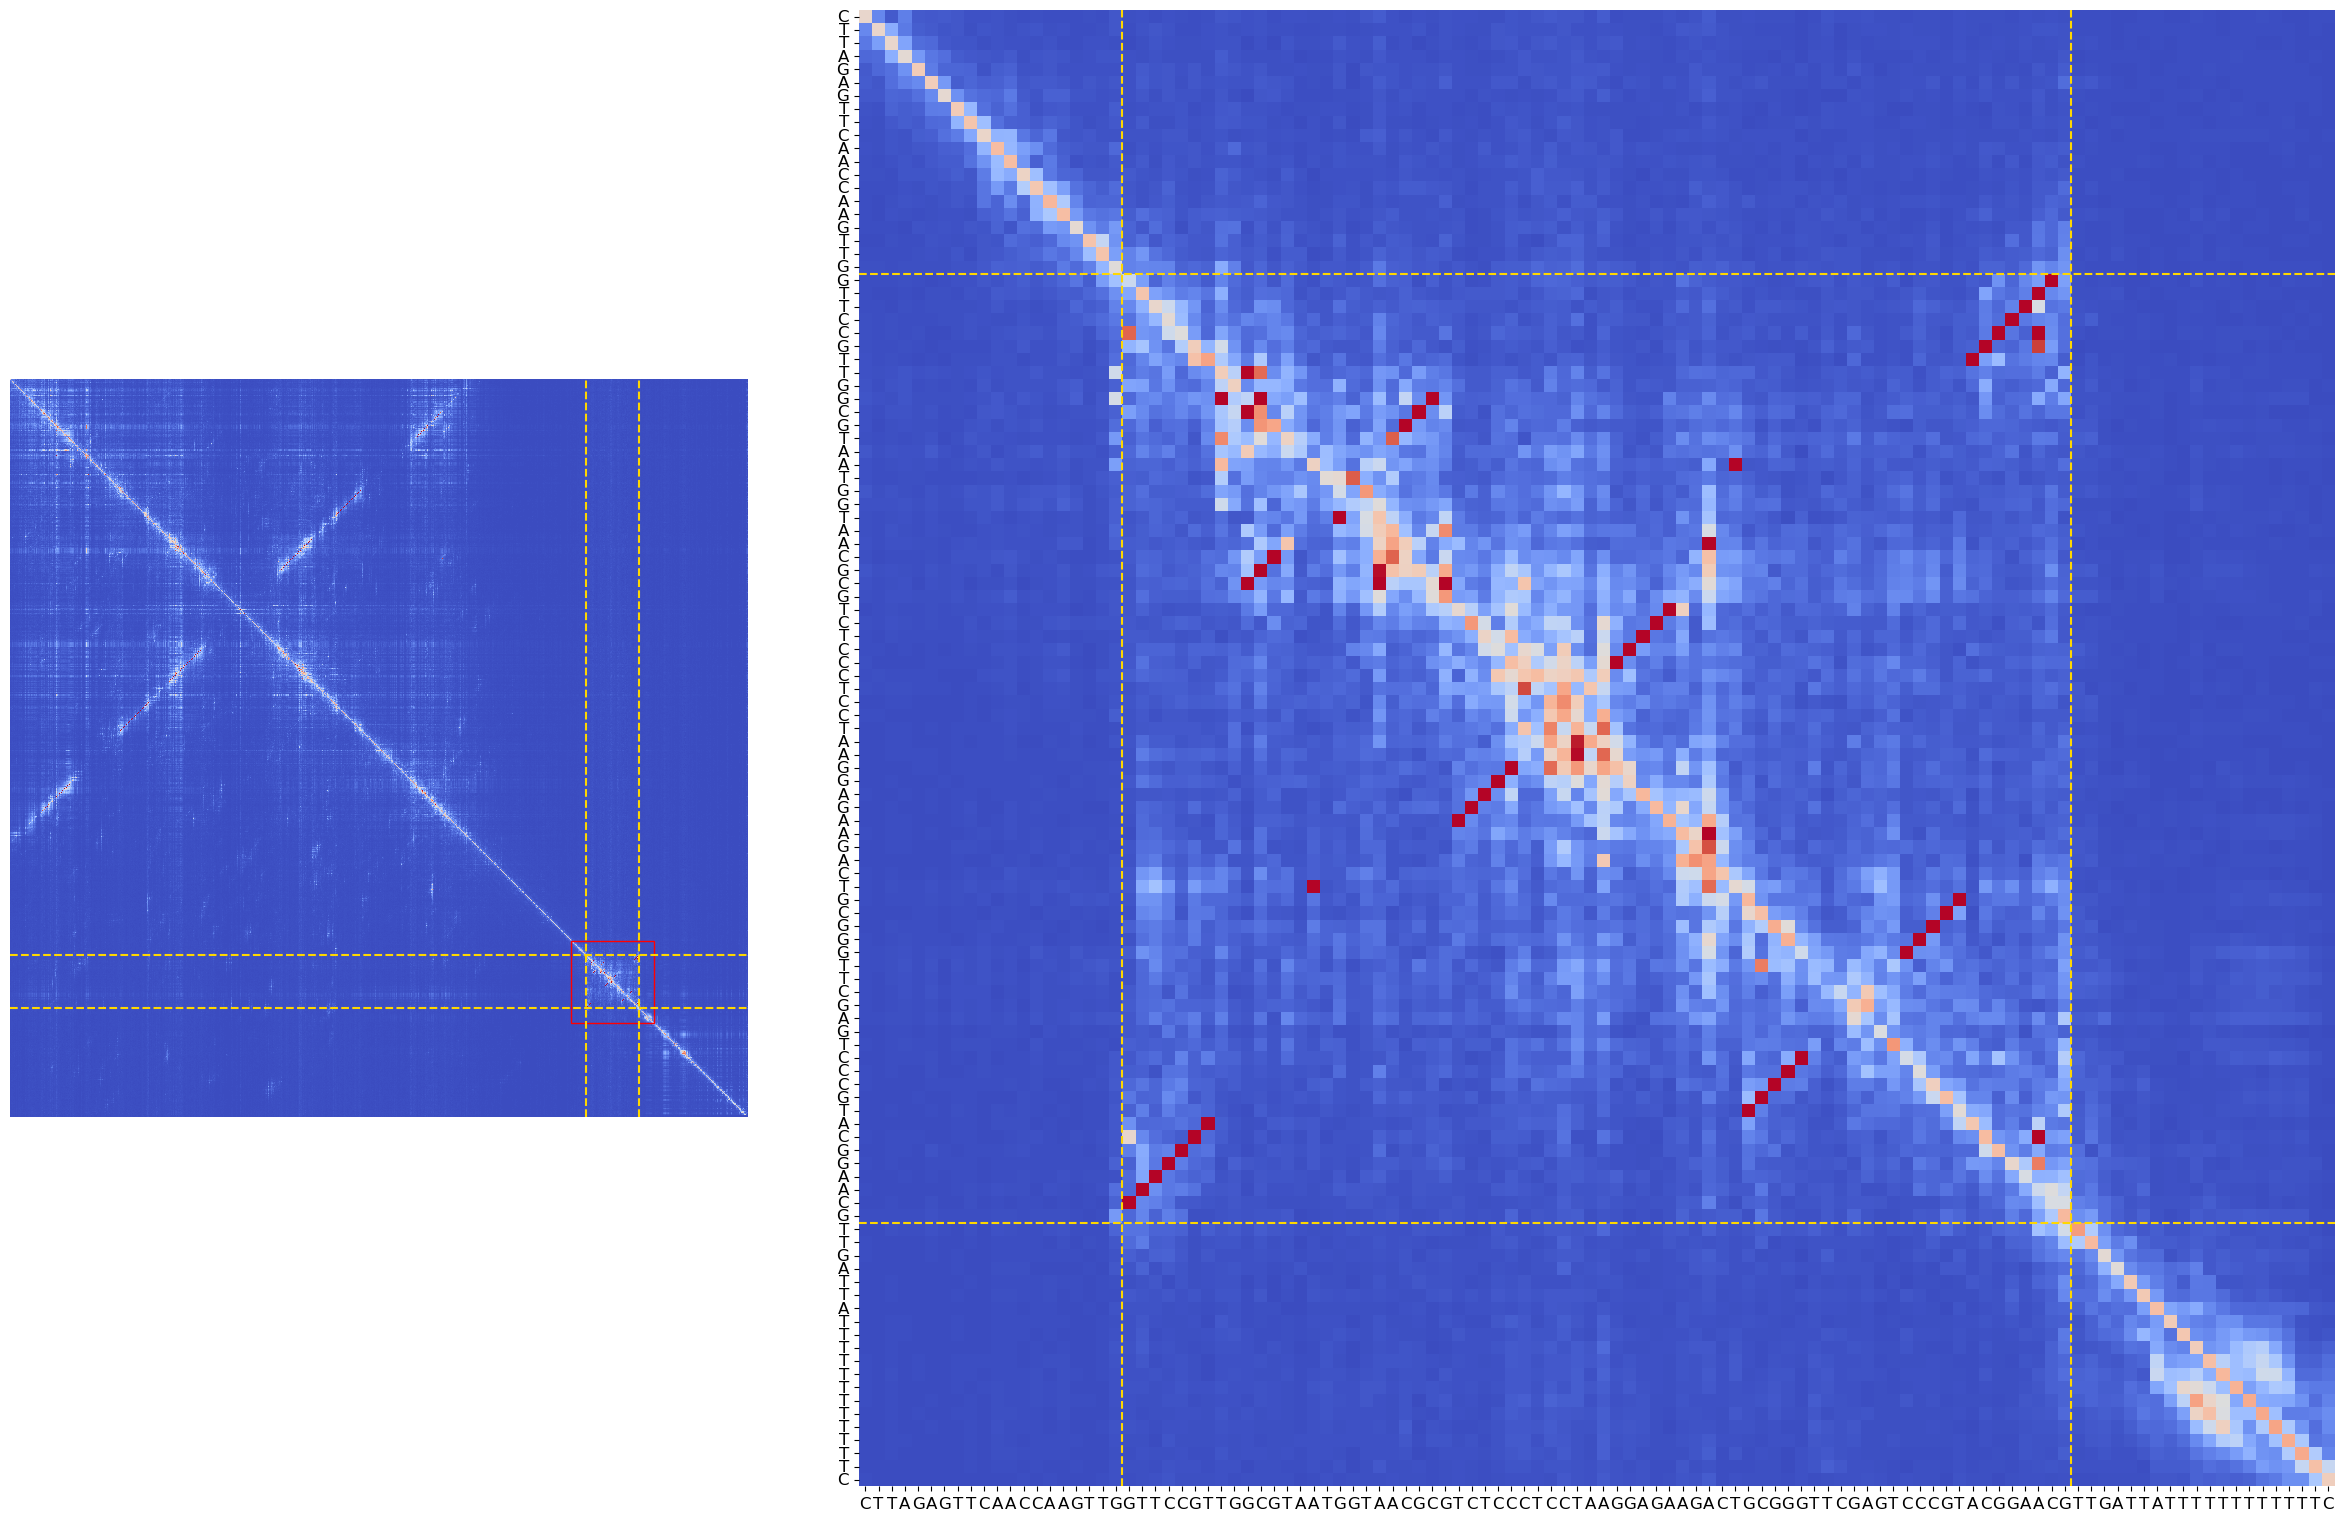

In [37]:
plot_tRNA_w_matrix('tR(CCU)J', vmax=5)

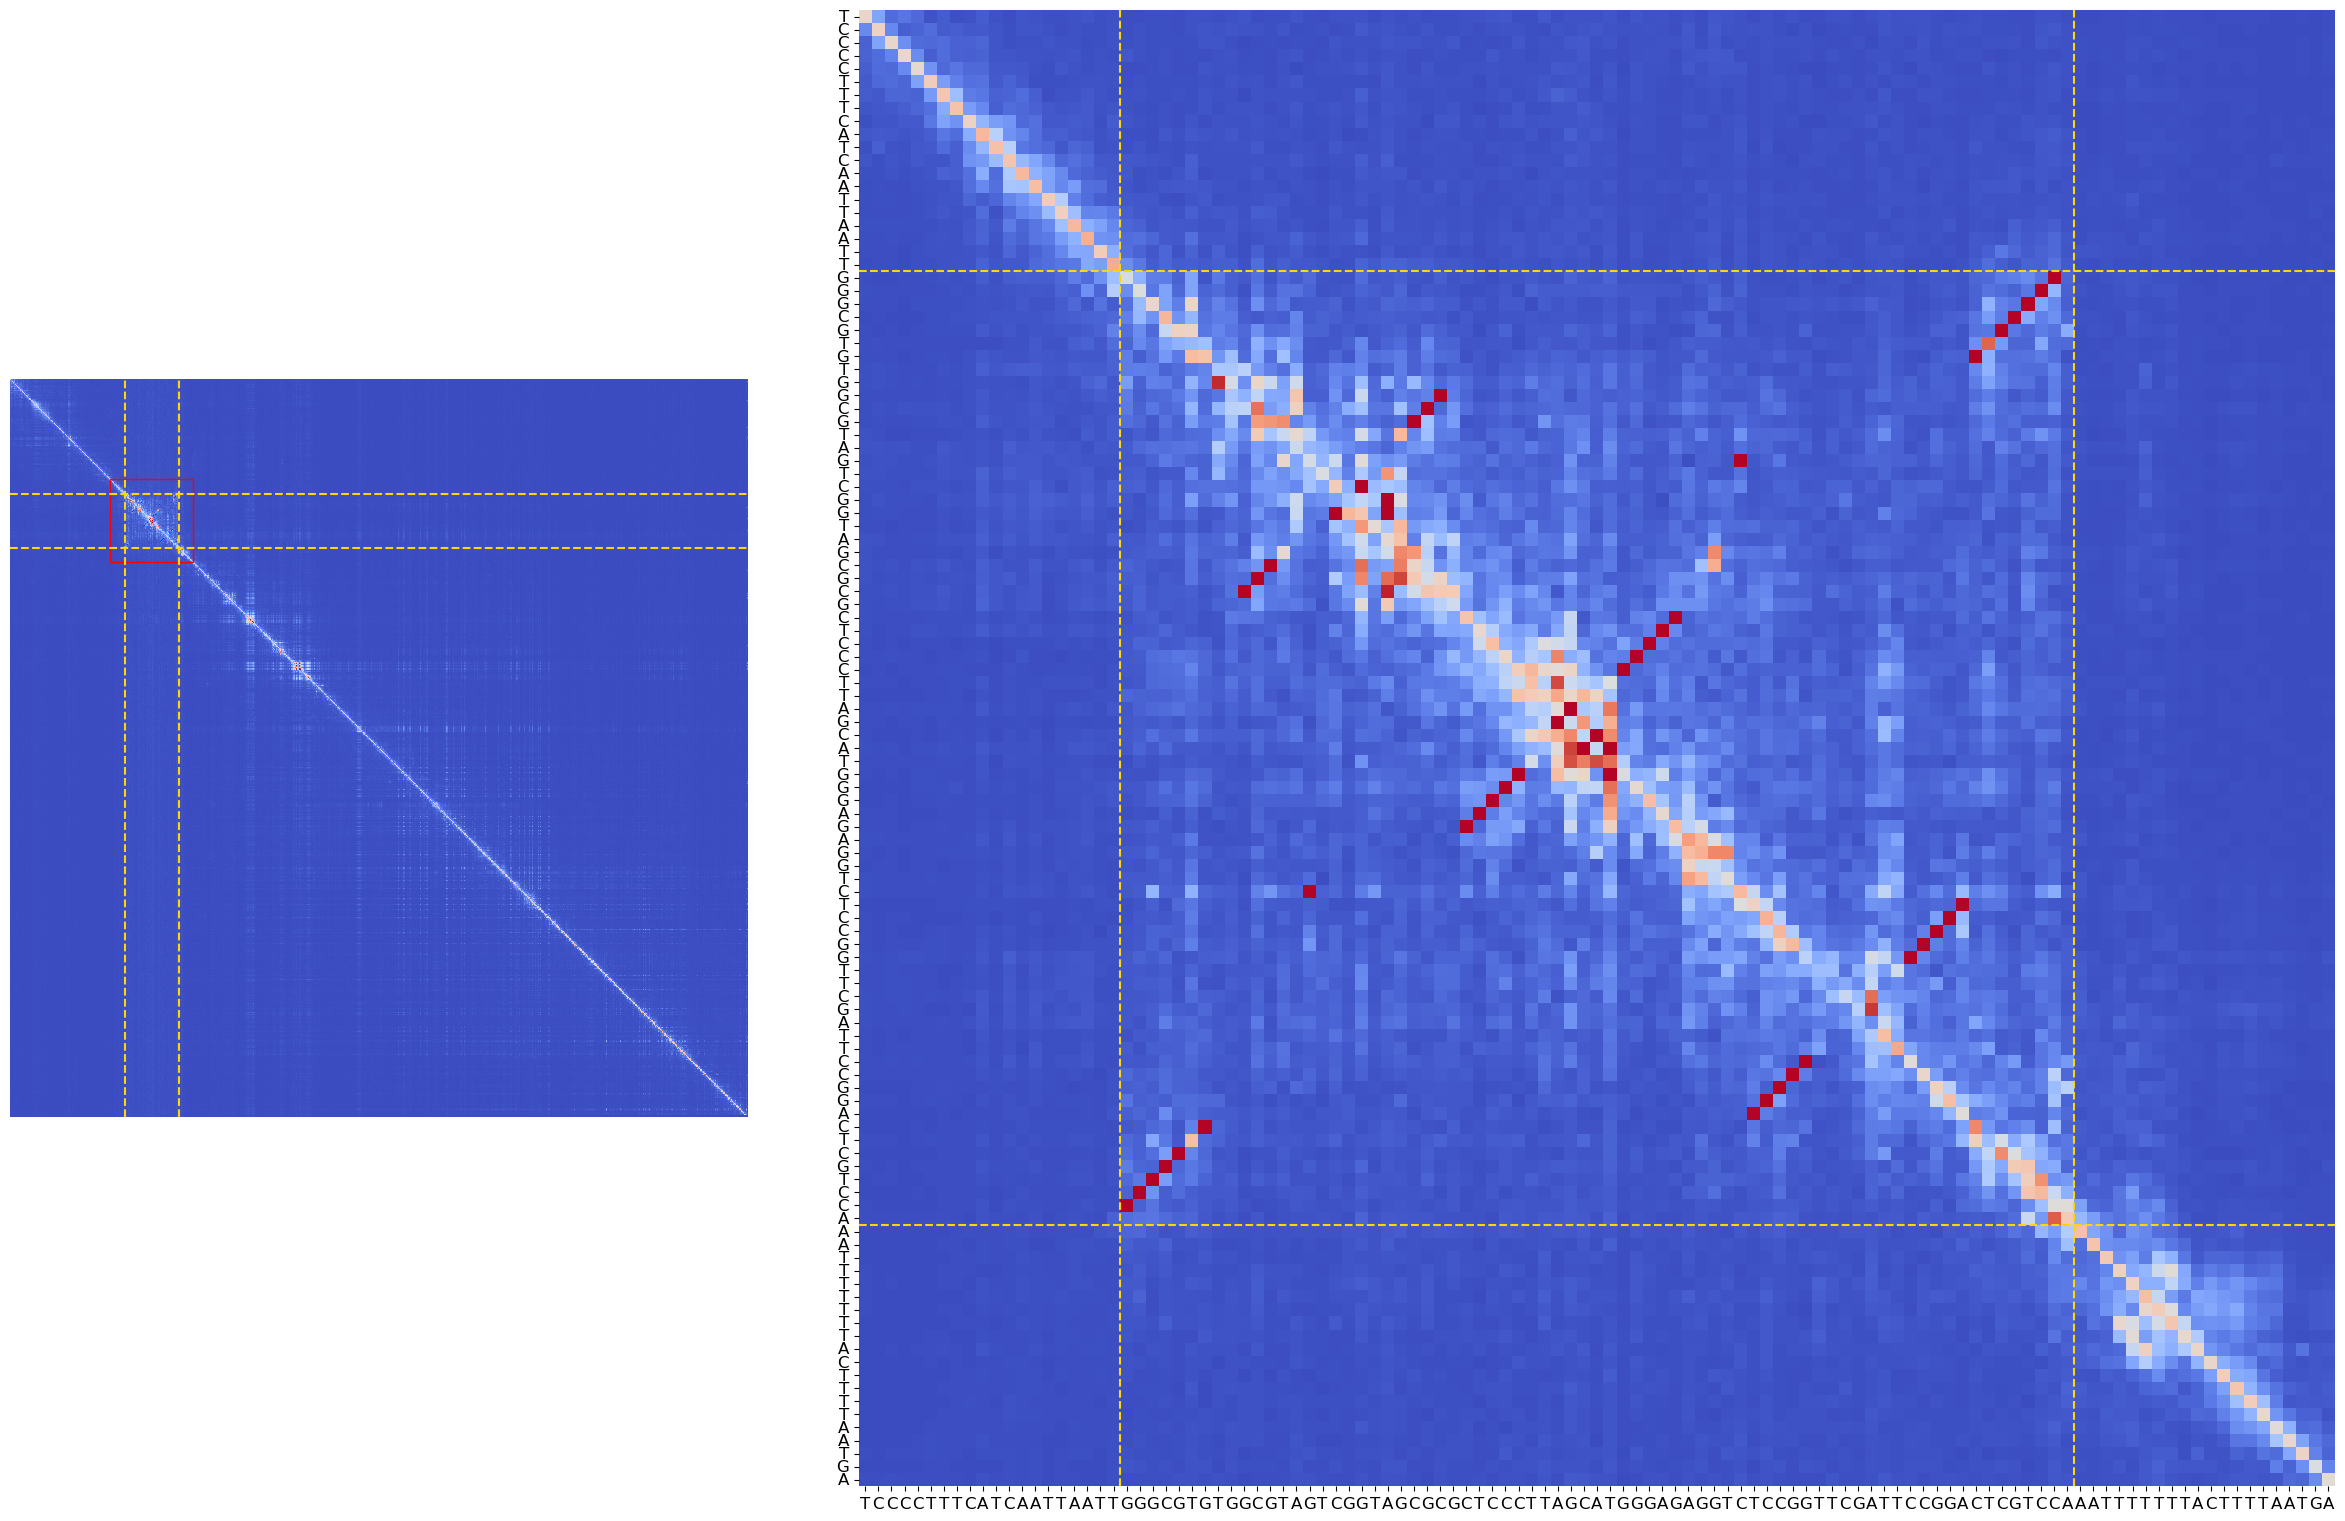

In [38]:
plot_tRNA_w_matrix('tA(AGC)G')

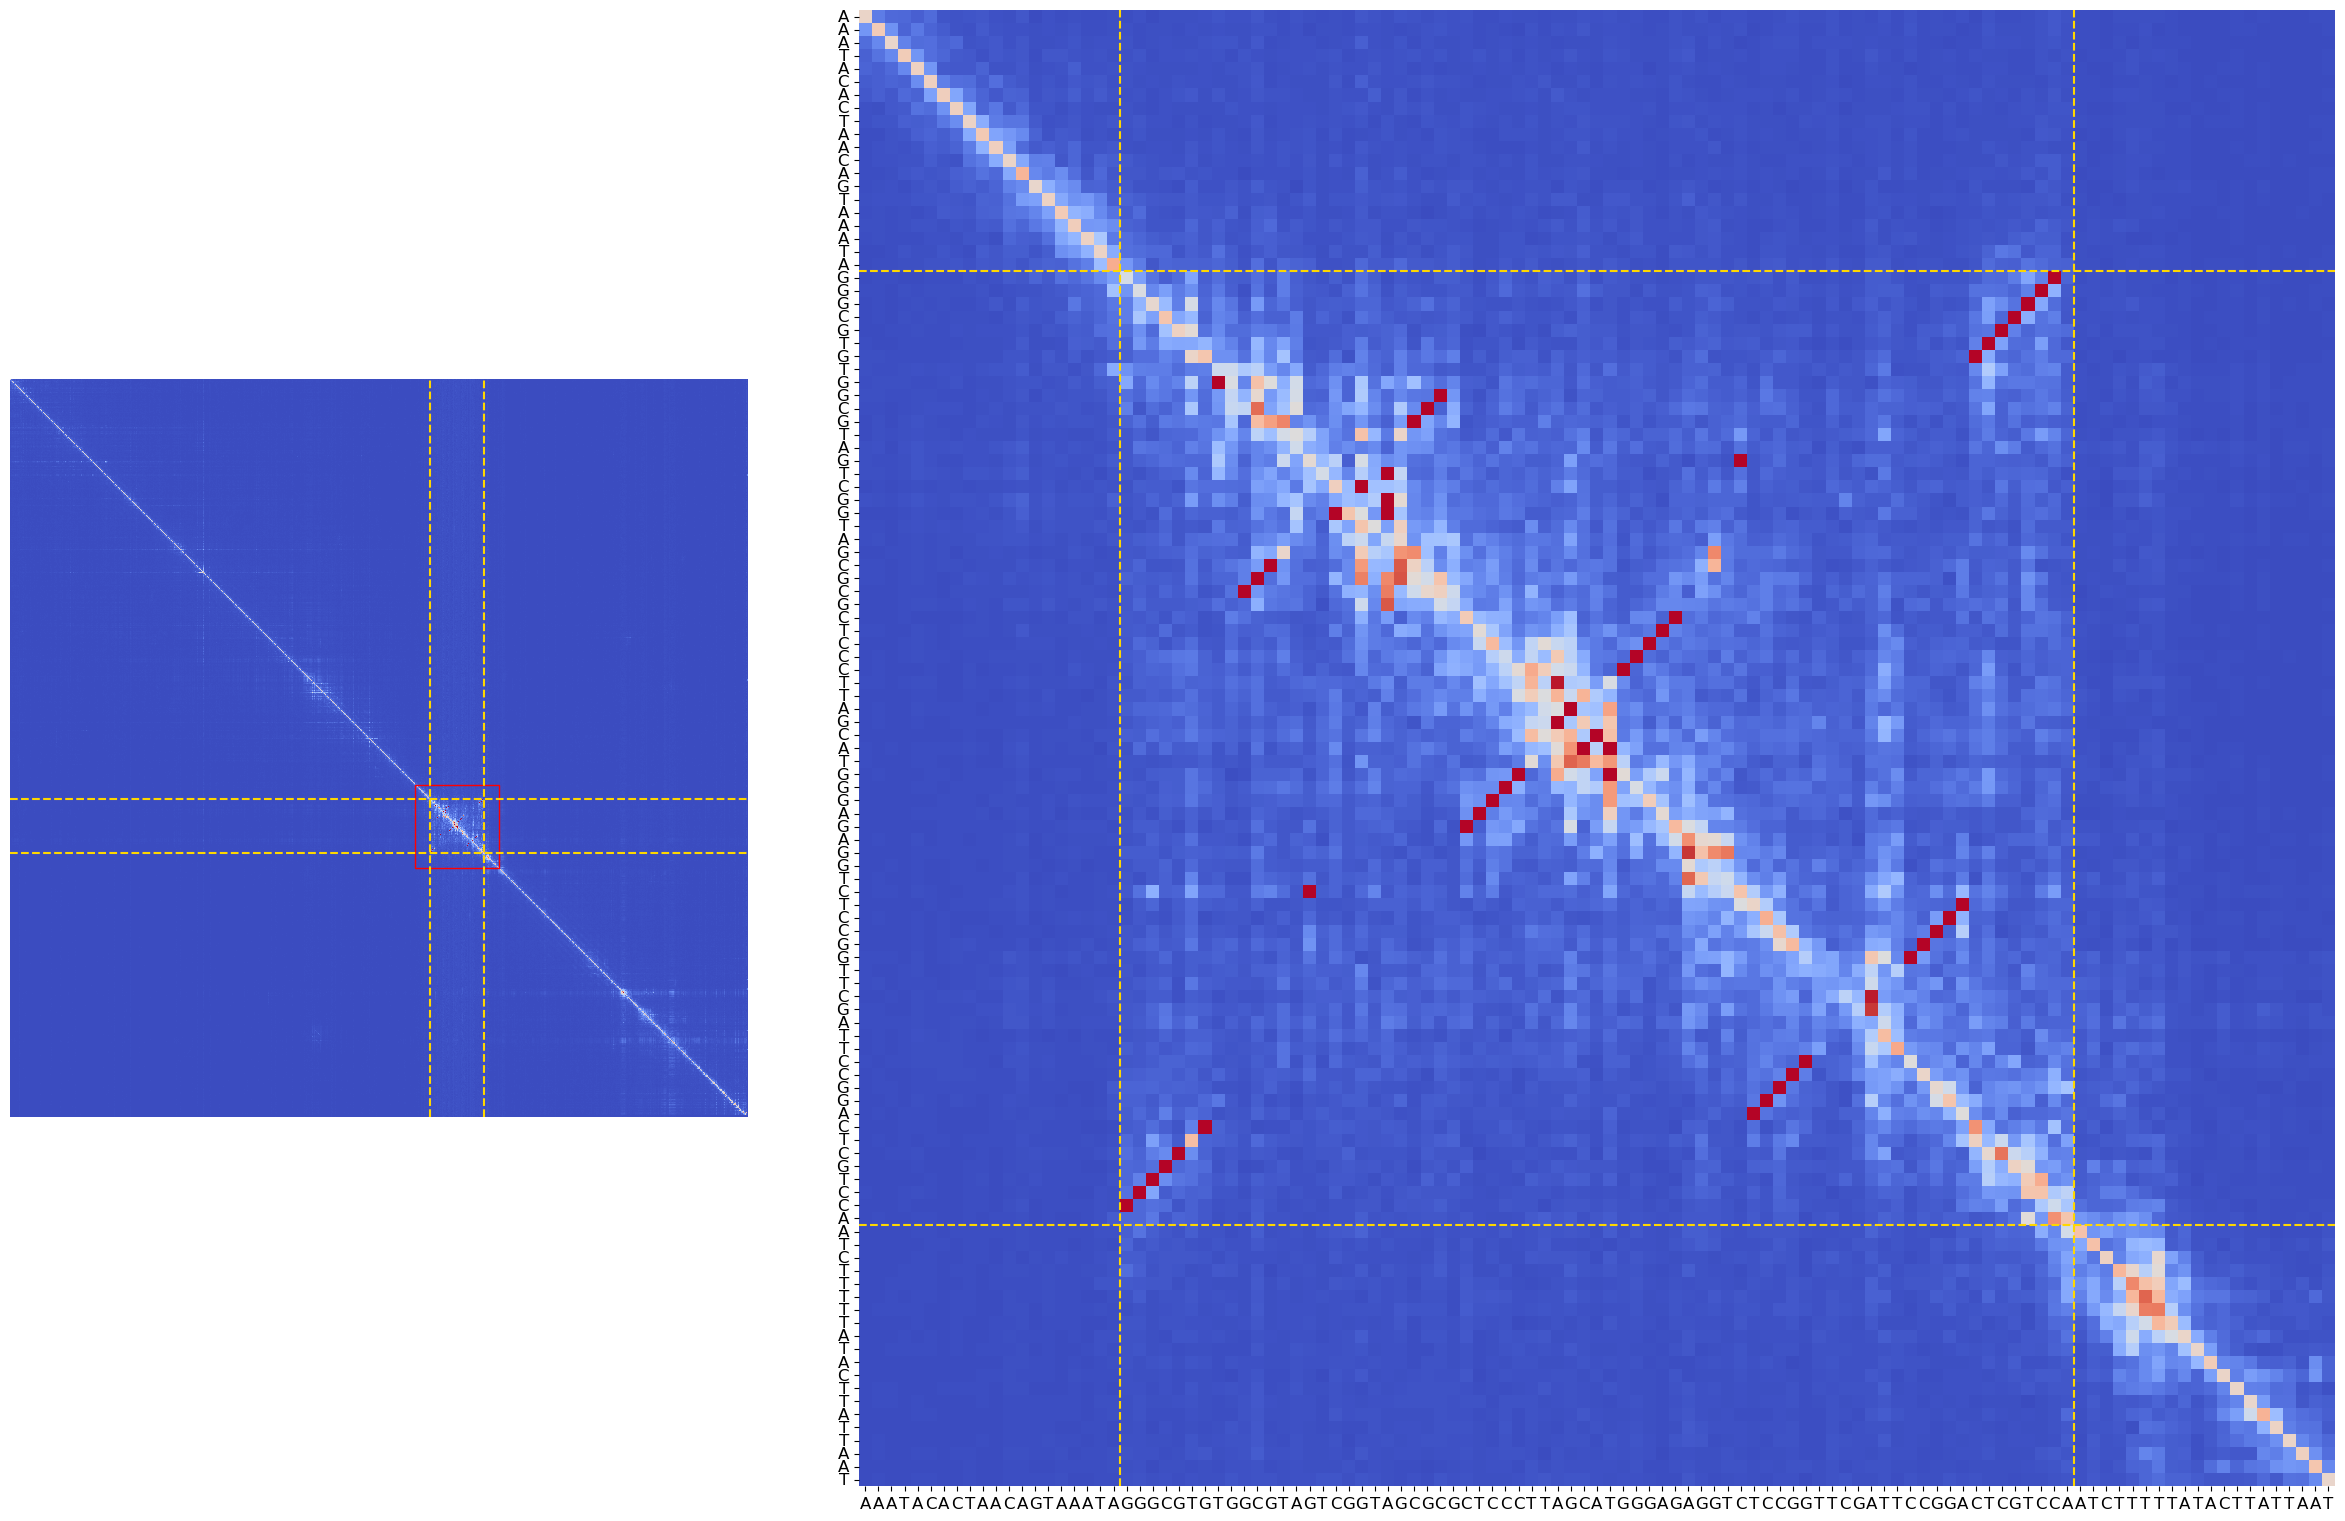

In [39]:
plot_tRNA_w_matrix('tA(AGC)K1')

tRNA in the + strand and start codon upstream sequence in the - strand

In [40]:
tRNAs_overlapping_unique_start_1000_df[(tRNAs_overlapping_unique_start_1000_df['Strand_start_codon'] == '-') & (tRNAs_overlapping_unique_start_1000_df['Strand'] == '+')].iloc[:5, :]

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
0          IV    sgd    gene  410378  410451     .      +     .     tA(AGC)D   
13         II    sgd    gene  405959  406031     .      +     .     tD(GUC)B   
14         IV    sgd    gene  568963  569035     .      +     .     tD(GUC)D   
28         IX    sgd    gene  370416  370488     .      +     .     tE(UUC)I   
31        XII    sgd    gene  797177  797249     .      +     .     tE(UUC)L   

   gene_name  ... exon_id_b protein_id_b start_codon_start_id Overlap  \
0        NaN  ...       NaN          NaN  409857_YDL024C_mRNA      73   
13       NaN  ...       NaN          NaN  405251_YBR081C_mRNA      72   
14       NaN  ...       NaN          NaN  568703_YDR058C_mRNA      72   
28       NaN  ...       NaN          NaN  369908_YIR006C_mRNA      72   
31       NaN  ...       NaN          NaN  797078_YLR334C_mRNA      72   

   tRNA_length fully_overlaps tRNA_rel_start tRNA_rel_end  \
0           73           True            521          594   
13          72           True            708          780   
14          72           True            260          332   
28          72           True            508          580   
31          72           True             99          171   

   tRNA_rel_start_matrix tRNA_rel_end_matrix  
0                    479                 406  
13                   292                 220  
14                   740                 668  
28                   492                 420  
31                   901                 829  

[5 rows x 46 columns]

In [41]:
tRNAs_overlapping_unique_start_1000_df[(tRNAs_overlapping_unique_start_1000_df['Strand_start_codon'] == '-') & (tRNAs_overlapping_unique_start_1000_df['Strand'] == '+')].iloc[:5, 20:]

Source_b    Feature_b  Start_start_codon  End_start_codon Score_b  \
0       sgd  start_codon             409854           409857       .   
13      sgd  start_codon             405248           405251       .   
14      sgd  start_codon             568700           568703       .   
28      sgd  start_codon             369905           369908       .   
31      sgd  start_codon             797075           797078       .   

   Strand_start_codon Frame_b gene_id_start_codon gene_name_b gene_source_b  \
0                   -       0             YDL024C        DIA3           sgd   
13                  -       0             YBR081C        SPT7           sgd   
14                  -       0             YDR058C        TGL2           sgd   
28                  -       0             YIR006C        PAN1           sgd   
31                  -       0             YLR334C         NaN           sgd   

    ... exon_id_b protein_id_b start_codon_start_id Overlap tRNA_length  \
0   ...       NaN          NaN  409857_YDL024C_mRNA      73          73   
13  ...       NaN          NaN  405251_YBR081C_mRNA      72          72   
14  ...       NaN          NaN  568703_YDR058C_mRNA      72          72   
28  ...       NaN          NaN  369908_YIR006C_mRNA      72          72   
31  ...       NaN          NaN  797078_YLR334C_mRNA      72          72   

   fully_overlaps tRNA_rel_start tRNA_rel_end tRNA_rel_start_matrix  \
0            True            521          594                   479   
13           True            708          780                   292   
14           True            260          332                   740   
28           True            508          580                   492   
31           True             99          171                   901   

    tRNA_rel_end_matrix  
0                   406  
13                  220  
14                  668  
28                  420  
31                  829  

[5 rows x 26 columns]

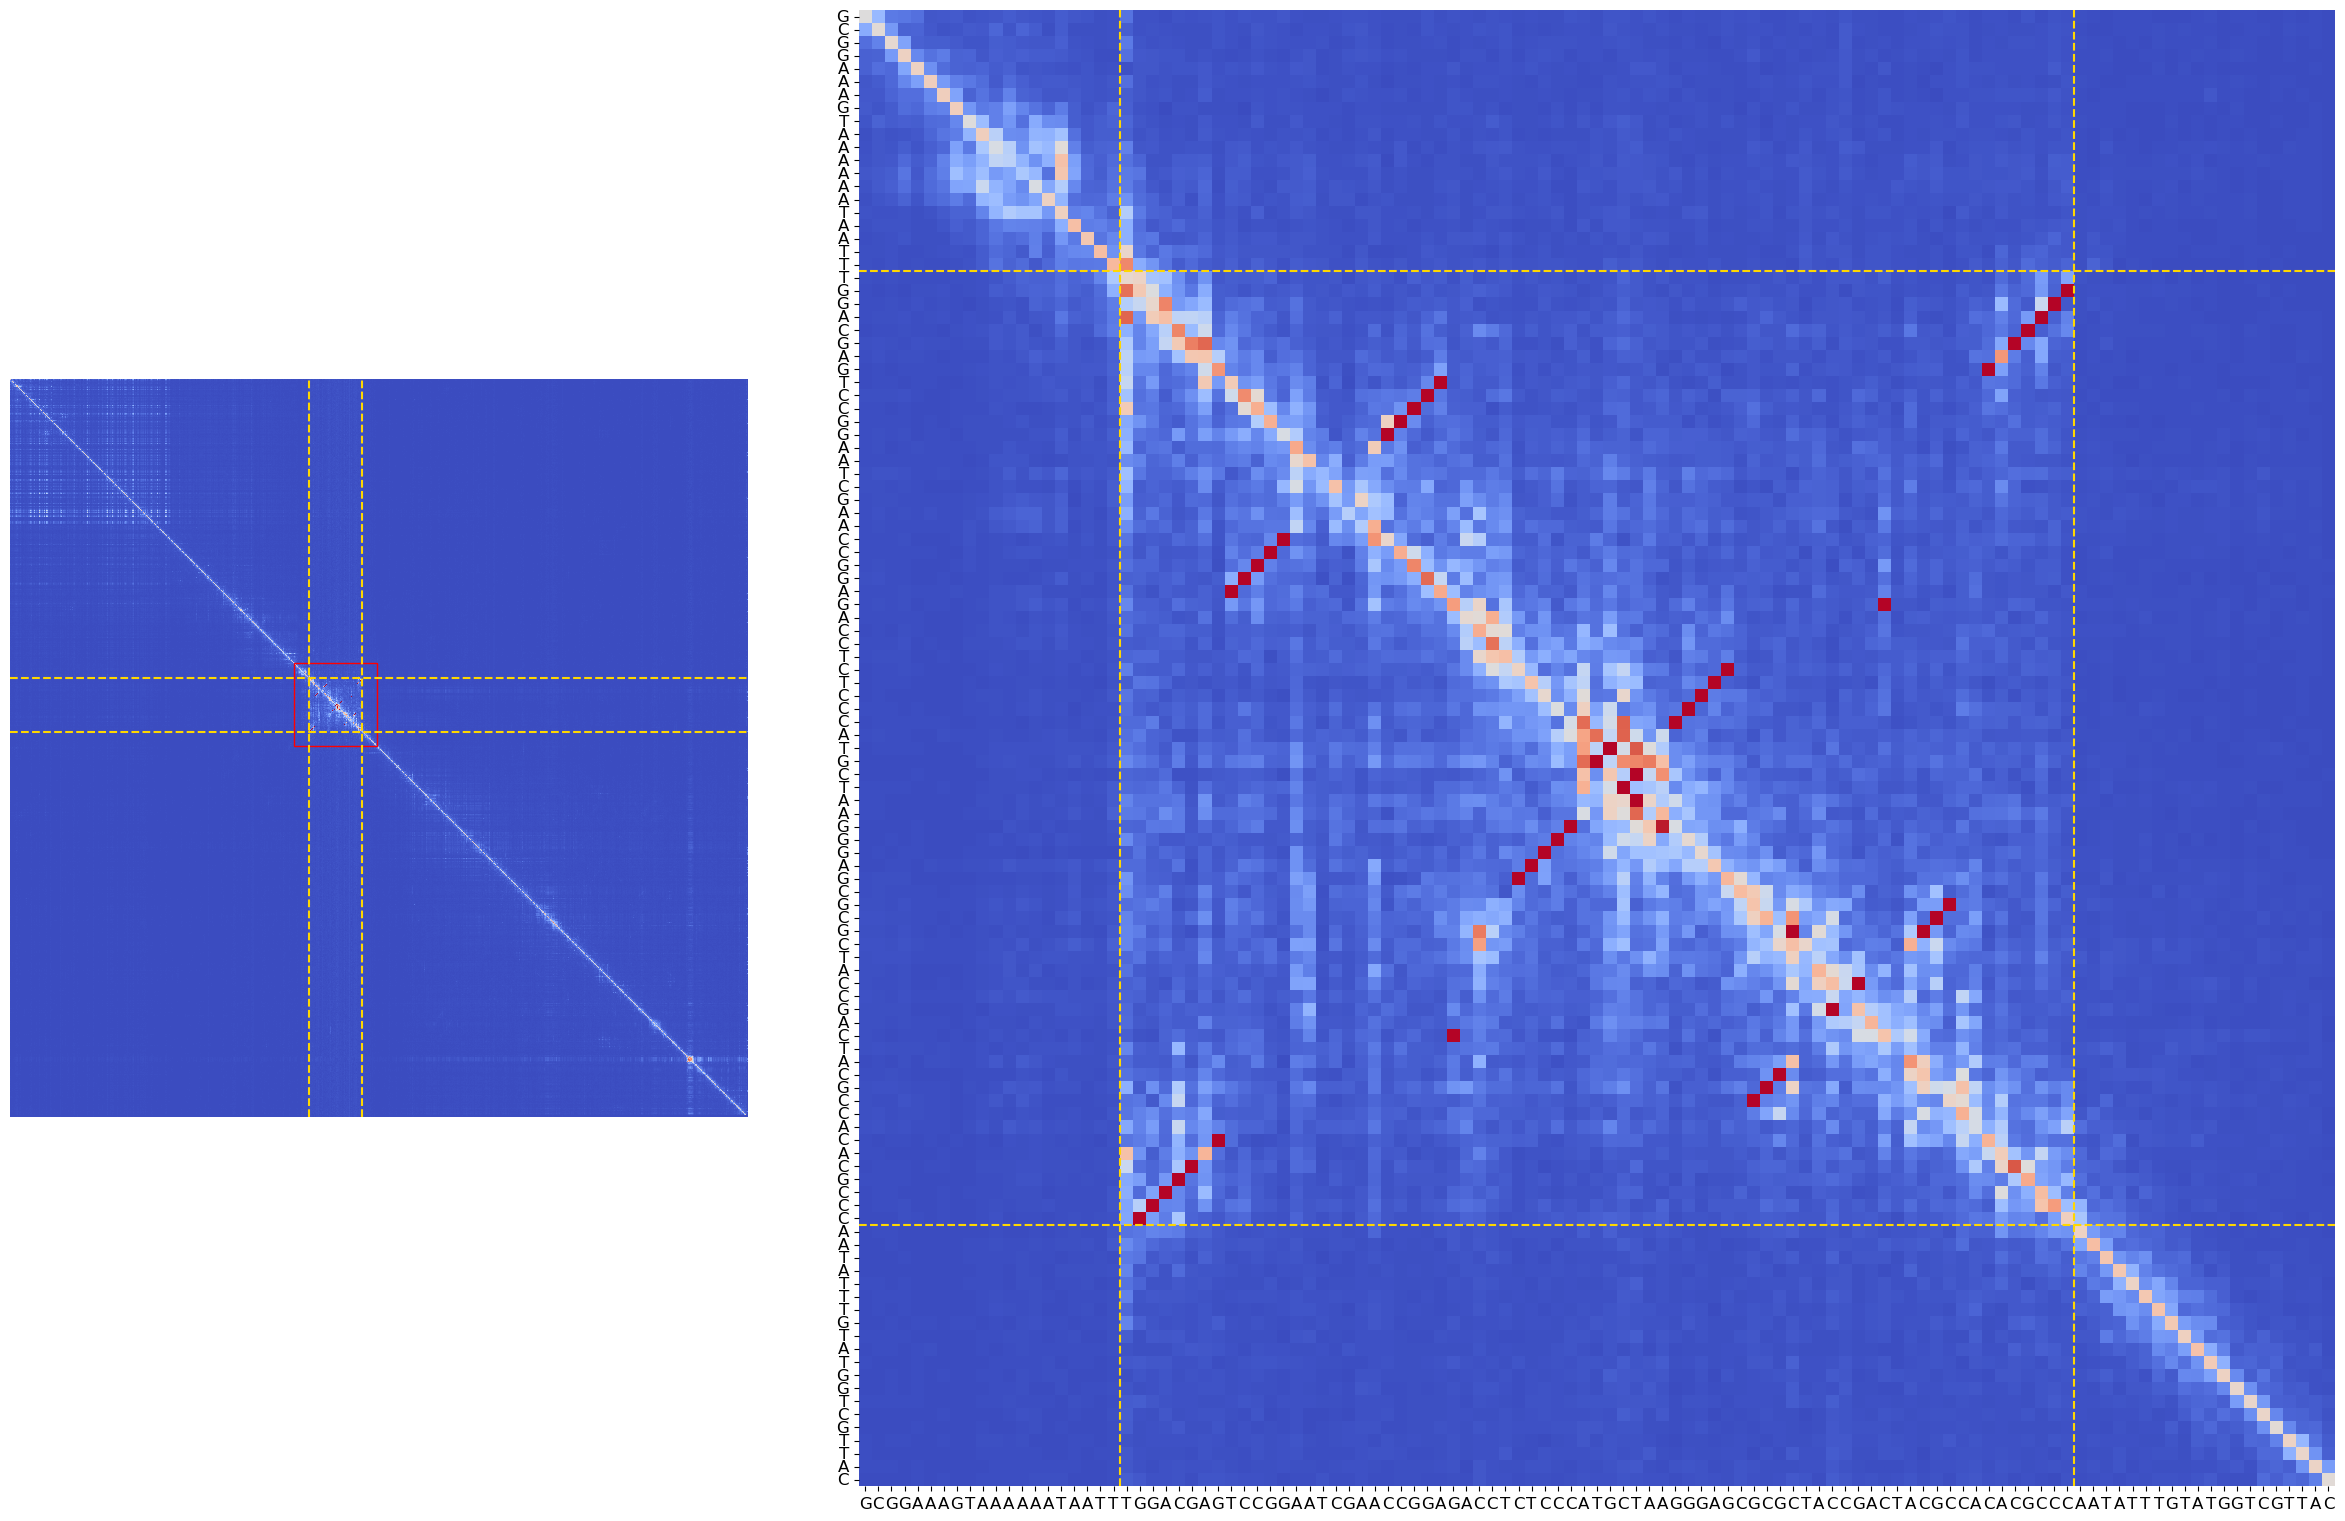

In [42]:
gene = 'tA(AGC)D'
plot_tRNA_w_matrix(gene)

tRNA in the - strand and start codon upstream sequence in the + strand

In [43]:
tRNAs_overlapping_unique_start_1000_df[(tRNAs_overlapping_unique_start_1000_df['Strand_start_codon'] == '+') & (tRNAs_overlapping_unique_start_1000_df['Strand'] == '-')].iloc[:5, :]

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
34       VIII    sgd    gene  358477  358569     .      -     .    tF(GAA)H2   
37        XVI    sgd    gene  622539  622631     .      -     .    tF(GAA)P2   
39        III    sgd    gene  142700  142771     .      -     .     tG(GCC)C   
55        XIV    sgd    gene  569866  569940     .      -     .    tI(AAU)N1   
61          V    sgd    gene  135424  135497     .      -     .    tK(CUU)E1   

   gene_name  ... exon_id_b protein_id_b start_codon_start_id Overlap  \
34       NaN  ...       NaN          NaN  358857_YHR125W_mRNA      92   
37       NaN  ...       NaN          NaN  623526_YPR028W_mRNA      92   
39     SUF16  ...       NaN          NaN  143633_YCR016W_mRNA      71   
55       NaN  ...       NaN          NaN  570476_YNL034W_mRNA      74   
61       NaN  ...       NaN          NaN  136278_YEL010W_mRNA      73   

   tRNA_length fully_overlaps tRNA_rel_start tRNA_rel_end  \
34          92           True            288          380   
37          92           True            895          987   
39          71           True            862          933   
55          74           True            536          610   
61          73           True            781          854   

   tRNA_rel_start_matrix tRNA_rel_end_matrix  
34                   712                 620  
37                   105                  13  
39                   138                  67  
55                   464                 390  
61                   219                 146  

[5 rows x 46 columns]

In [44]:
tRNAs_overlapping_unique_start_1000_df[(tRNAs_overlapping_unique_start_1000_df['Strand_start_codon'] == '+') & (tRNAs_overlapping_unique_start_1000_df['Strand'] == '-')].iloc[:5, 20:]

Source_b    Feature_b  Start_start_codon  End_start_codon Score_b  \
34      sgd  start_codon             358857           358860       .   
37      sgd  start_codon             623526           623529       .   
39      sgd  start_codon             143633           143636       .   
55      sgd  start_codon             570476           570479       .   
61      sgd  start_codon             136278           136281       .   

   Strand_start_codon Frame_b gene_id_start_codon gene_name_b gene_source_b  \
34                  +       0             YHR125W         NaN           sgd   
37                  +       0             YPR028W        YOP1           sgd   
39                  +       0             YCR016W         NaN           sgd   
55                  +       0             YNL034W         NaN           sgd   
61                  +       0             YEL010W         NaN           sgd   

    ... exon_id_b protein_id_b start_codon_start_id Overlap tRNA_length  \
34  ...       NaN          NaN  358857_YHR125W_mRNA      92          92   
37  ...       NaN          NaN  623526_YPR028W_mRNA      92          92   
39  ...       NaN          NaN  143633_YCR016W_mRNA      71          71   
55  ...       NaN          NaN  570476_YNL034W_mRNA      74          74   
61  ...       NaN          NaN  136278_YEL010W_mRNA      73          73   

   fully_overlaps tRNA_rel_start tRNA_rel_end tRNA_rel_start_matrix  \
34           True            288          380                   712   
37           True            895          987                   105   
39           True            862          933                   138   
55           True            536          610                   464   
61           True            781          854                   219   

    tRNA_rel_end_matrix  
34                  620  
37                   13  
39                   67  
55                  390  
61                  146  

[5 rows x 26 columns]

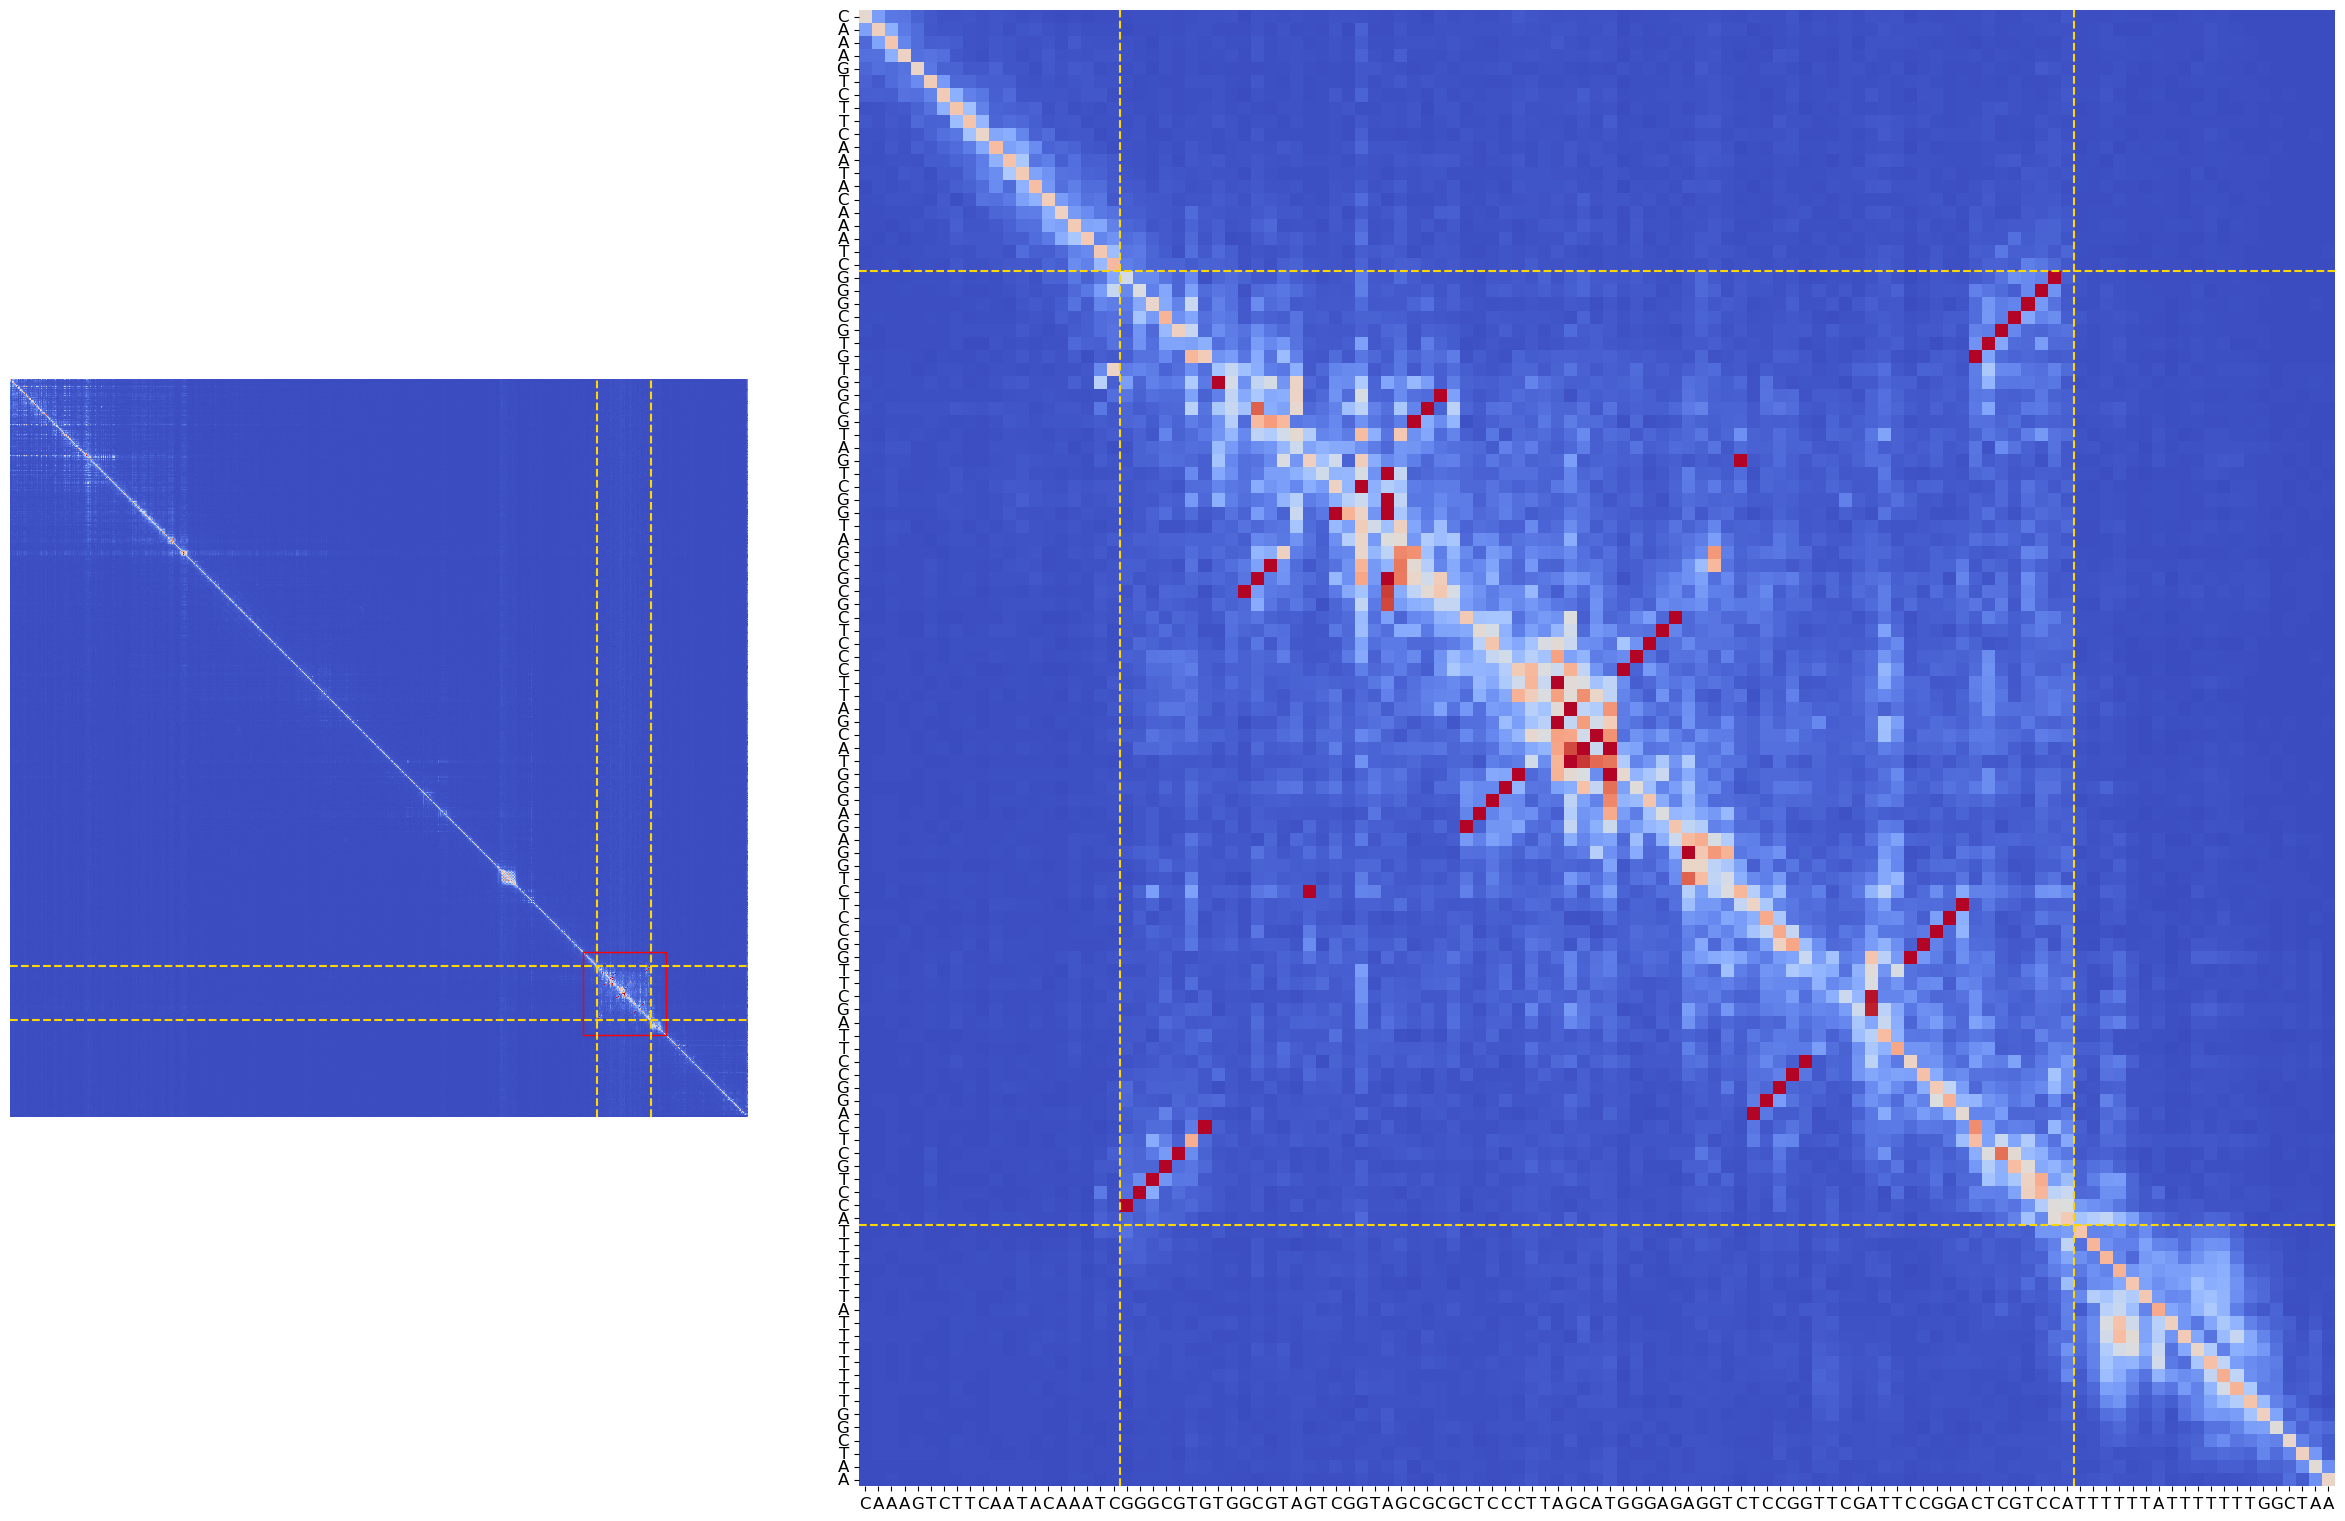

In [45]:
gene = 'tA(AGC)M1'
plot_tRNA_w_matrix(gene)

tRNA in the - strand and start codon upstream sequence in the - strand

In [46]:
tRNAs_overlapping_unique_start_1000_df[(tRNAs_overlapping_unique_start_1000_df['Strand_start_codon'] == '-') & (tRNAs_overlapping_unique_start_1000_df['Strand'] == '-')].iloc[:5, :]

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
1         VI    sgd    gene  204923  204996     .      -     .     tA(AGC)F   
5       XIII    sgd    gene  321146  321219     .      -     .    tA(AGC)M1   
6       XIII    sgd    gene  768368  768441     .      -     .    tA(AGC)M2   
8          V    sgd    gene  312022  312095     .      -     .     tA(UGC)E   
9        XII    sgd    gene  214882  214955     .      -     .     tA(UGC)L   

  gene_name  ... exon_id_b protein_id_b start_codon_start_id Overlap  \
1       NaN  ...       NaN          NaN  204750_YFR025C_mRNA      73   
5       NaN  ...       NaN          NaN  321017_YMR023C_mRNA      73   
6       NaN  ...       NaN          NaN  768039_YMR247C_mRNA      73   
8       NaN  ...       NaN          NaN  311199_YER075C_mRNA      73   
9       NaN  ...       NaN          NaN  214456_YLR035C_mRNA      73   

  tRNA_length fully_overlaps tRNA_rel_start tRNA_rel_end  \
1          73           True            246          173   
5          73           True            202          129   
6          73           True            402          329   
8          73           True            896          823   
9          73           True            499          426   

  tRNA_rel_start_matrix tRNA_rel_end_matrix  
1                   754                 827  
5                   798                 871  
6                   598                 671  
8                   104                 177  
9                   501                 574  

[5 rows x 46 columns]

In [47]:
tRNAs_overlapping_unique_start_1000_df[(tRNAs_overlapping_unique_start_1000_df['Strand_start_codon'] == '-') & (tRNAs_overlapping_unique_start_1000_df['Strand'] == '-')].iloc[:5, 20:]

Source_b    Feature_b  Start_start_codon  End_start_codon Score_b  \
1      sgd  start_codon             204747           204750       .   
5      sgd  start_codon             321014           321017       .   
6      sgd  start_codon             768036           768039       .   
8      sgd  start_codon             311196           311199       .   
9      sgd  start_codon             214453           214456       .   

  Strand_start_codon Frame_b gene_id_start_codon gene_name_b gene_source_b  \
1                  -       0             YFR025C        HIS2           sgd   
5                  -       0             YMR023C        MSS1           sgd   
6                  -       0             YMR247C        RKR1           sgd   
8                  -       0             YER075C        PTP3           sgd   
9                  -       0             YLR035C        MLH2           sgd   

   ... exon_id_b protein_id_b start_codon_start_id Overlap tRNA_length  \
1  ...       NaN          NaN  204750_YFR025C_mRNA      73          73   
5  ...       NaN          NaN  321017_YMR023C_mRNA      73          73   
6  ...       NaN          NaN  768039_YMR247C_mRNA      73          73   
8  ...       NaN          NaN  311199_YER075C_mRNA      73          73   
9  ...       NaN          NaN  214456_YLR035C_mRNA      73          73   

  fully_overlaps tRNA_rel_start tRNA_rel_end tRNA_rel_start_matrix  \
1           True            246          173                   754   
5           True            202          129                   798   
6           True            402          329                   598   
8           True            896          823                   104   
9           True            499          426                   501   

   tRNA_rel_end_matrix  
1                  827  
5                  871  
6                  671  
8                  177  
9                  574  

[5 rows x 26 columns]

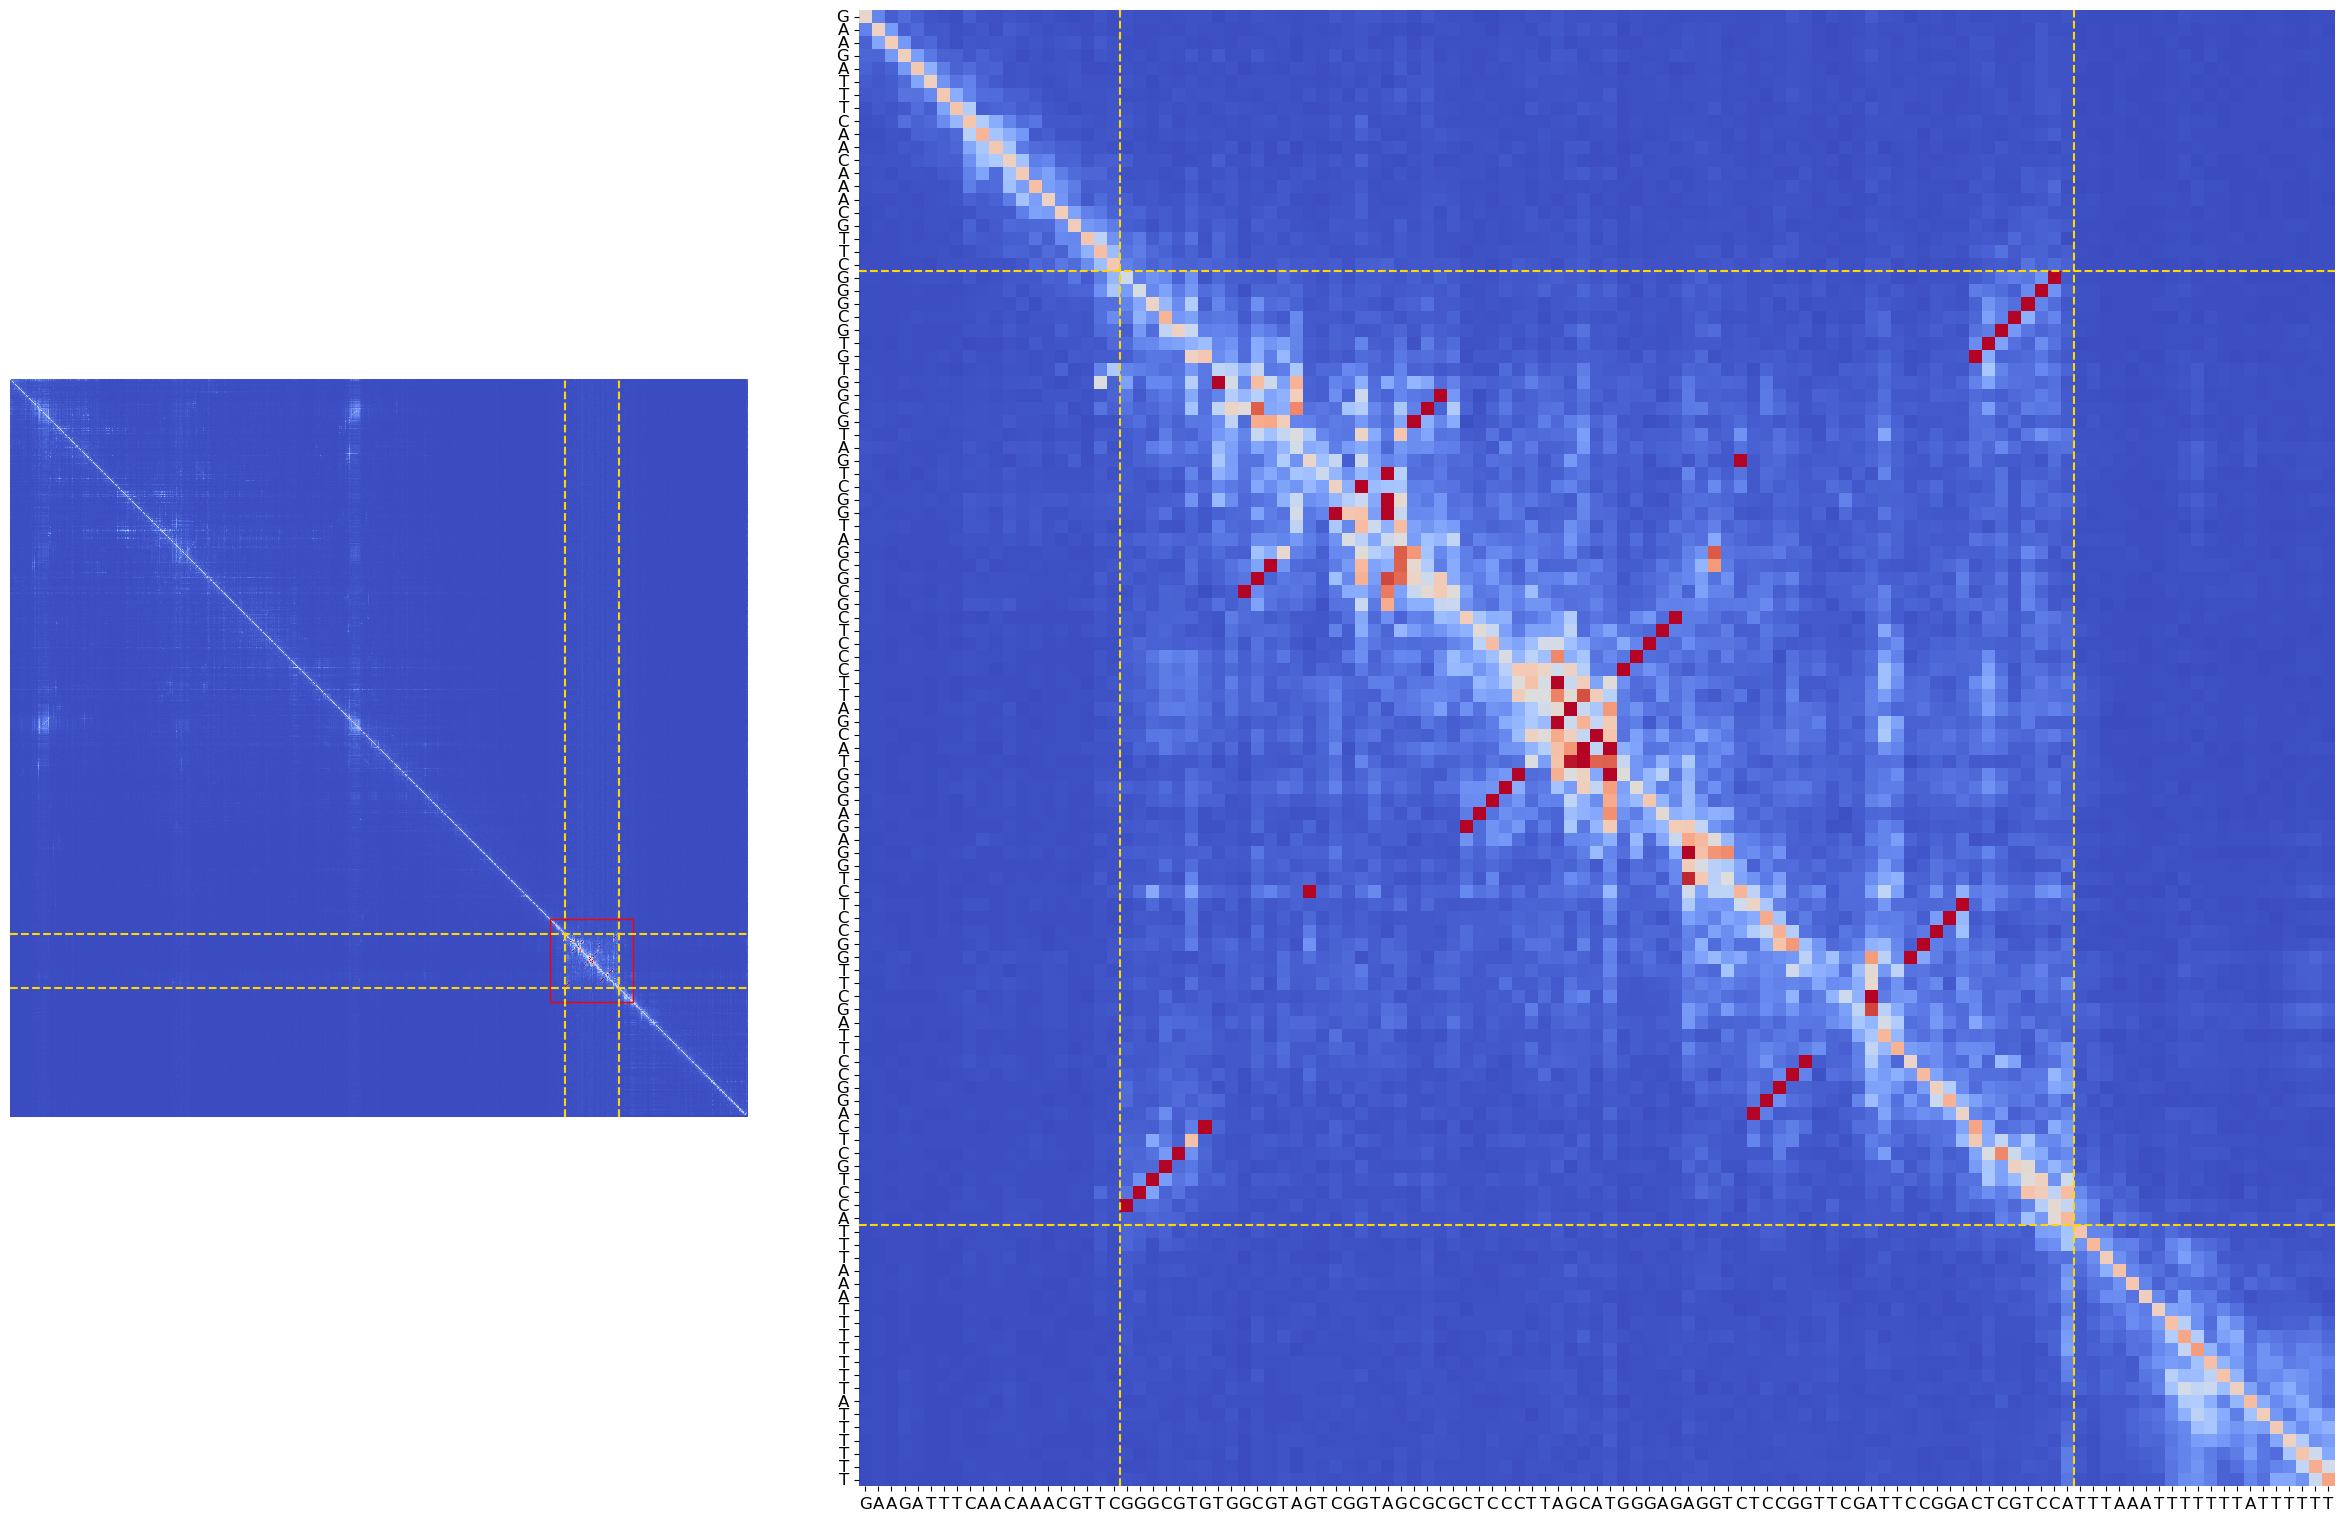

In [48]:
gene = 'tA(AGC)F'
plot_tRNA_w_matrix(gene)

## Benchmark tRNA structure from DNALM with the reported from tRNA scan

In [11]:
tRNA_scan_file = os.path.join(data_path, 'sacCer3-tRNAs.ss.sort')

In [51]:
def create_contact_matrix(structure):
    stack = []
    matrix_size = len(structure)
    contact_matrix = torch.zeros((matrix_size, matrix_size), dtype=int)

    for i, char in enumerate(structure):
        if char == '>':
            stack.append(i)
        elif char == '<' and stack:
            j = stack.pop()
            contact_matrix[i,j] = contact_matrix[j,i] = 1

    return contact_matrix


In [52]:
toy_example = '>>>>..>>>...<<<..<<<<.'

<AxesSubplot: >

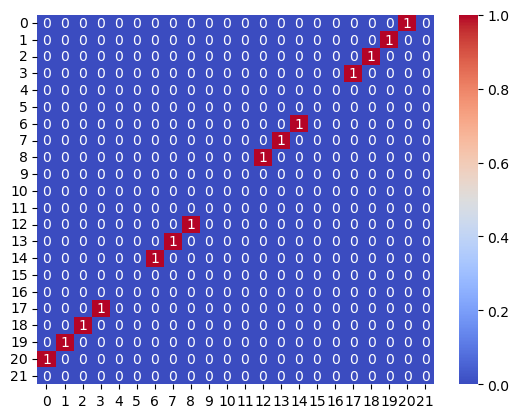

In [53]:
#plot heamatp
sns.heatmap(create_contact_matrix(toy_example), cmap='coolwarm', annot=True)

In [54]:
def parse_trna_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    trna_data = []
    trna_name, location = None, None
    possible_intron = False
    for i, line in enumerate(lines):
        
        if line.strip() and not line.startswith((' ', '\t', 'Seq', 'Str', 'Type','HMM','Possible intron')):
            trna_name = line.split()[0]
            trna_chromosome = trna_name.split('.')[0].strip('chr')
            trna_id = trna_name.split('.')[1]
            location = line.split('(')[1].split(')')[0]
            start = int(location.split('-')[0])
            end = int(location.split('-')[1])
            # star is not always smaller than end. Maybe negative strand tRNAs
            if start > end:
                start, end = end, start 
            start = start - 1 #adjust to 0-based coordinates
            assert end > start, f'end: {end} should be greater than start: {start}'

        elif line.startswith('Type:'):
            score = float(line.split('Score:')[1].strip())
        elif line.startswith('Seq:'):
            sequence = line.split(':')[1].strip().upper()
        elif line.startswith('Possible intron'):
            possible_intron = True
        elif line.startswith('Str:'):
            structure = line.split(':')[1].strip()
            contact_matrix = create_contact_matrix(structure)
            trna_data.append([trna_id, trna_chromosome, start, end, sequence, structure, score, possible_intron, contact_matrix])
            possible_intron = False

    return pd.DataFrame(trna_data, columns=['trna_scan_id', 'Chromosome', 'Start', 'End', 'tRNA_scan_sequence', 'structure_string', 'score', 'possible_intron', 'contact_matrix'])

In [55]:
tRNA_scan_df = parse_trna_file(tRNA_scan_file)
tRNA_scan_df

trna_scan_id Chromosome    Start      End  \
0          trna3         IV   410378   410451   
1          trna6         VI   204923   204996   
2         trna15        VII   774348   774421   
3          trna8       VIII   146241   146314   
4         trna22          X   197312   197385   
..           ...        ...      ...      ...   
270       trna16       XIII   372444   372518   
271       trna20         IV  1075471  1075544   
272        trna4       VIII   475705   475778   
273       trna12         II   326791   326865   
274       trna27         IV   488796   488870   

                                    tRNA_scan_sequence  \
0    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
1    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
2    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
3    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
4    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
..                                                 ...   
270  GGTTTCGTGGTCTAGTCGGTTATGGCATCTGCTTAACACGCAGAAC...   
271  GTTCCAATAGTGTAGCGGCTATCACGTTGCCTTCACACGGCAAAGG...   
272  GTTCCAATAGTGTAGCGGCTATCACGTTGCCTTCACACGGCAAAGG...   
273  GGTCCAATGGTCCAGTGGTTCAAGACGTCGCCTTTACACGGCGAAG...   
274  GGTCCAATGGTCCAGTGGTTCAAGACGTCGCCTTTACACGGCGAAG...   

                                      structure_string  score  \
0    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
1    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
2    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
3    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
4    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
..                                                 ...    ...   
270  >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.....   67.6   
271  >>>>>>>..>>>..........<<<.>>>>>.......<<<<<......   70.5   
272  >>>>>>>..>>>..........<<<.>>>>>.......<<<<<......   70.5   
273  >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.....   70.3   
274  >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.....   70.3   

     possible_intron                                     contact_matrix  
0              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
1              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
2              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
3              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
4              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
..               ...                                                ...  
270            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
271            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
272            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
273            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
274            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  

[275 rows x 9 columns]

In [56]:
tRNA_scan_df.Chromosome.unique()

array(['IV', 'VI', 'VII', 'VIII', 'X', 'XI', 'XII', 'XIII', 'XVI', 'I',
       'V', 'XV', 'II', 'III', 'XIV', 'IX'], dtype=object)

There are no mito tRNAs in the tRNA scan annotations!

In [57]:
tRNA_lm_scan_df = tRNAs_overlapping_unique_start_1000_df.merge(tRNA_scan_df, on = ['Chromosome', 'Start', 'End'], how = 'left')
tRNA_lm_scan_df

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
0           IV    sgd    gene  410378  410451     .      +     .     tA(AGC)D   
1           VI    sgd    gene  204923  204996     .      -     .     tA(AGC)F   
2          VII    sgd    gene  774348  774421     .      +     .     tA(AGC)G   
3           XI    sgd    gene  219894  219967     .      +     .    tA(AGC)K1   
4           XI    sgd    gene  517987  518060     .      +     .    tA(AGC)K2   
..         ...    ...     ...     ...     ...   ...    ...   ...          ...   
170         VI    sgd    gene  167436  167525     .      +     .    tY(GUA)F1   
171         VI    sgd    gene  210618  210707     .      -     .    tY(GUA)F2   
172          X    sgd    gene  542955  543044     .      -     .    tY(GUA)J2   
173       XIII    sgd    gene  837927  838016     .      +     .    tY(GUA)M2   
174         XV    sgd    gene  288191  288280     .      +     .     tY(GUA)O   

    gene_name  ... tRNA_rel_start tRNA_rel_end tRNA_rel_start_matrix  \
0         NaN  ...            521          594                   479   
1         NaN  ...            246          173                   754   
2         NaN  ...            844          771                   156   
3         NaN  ...            429          356                   571   
4         NaN  ...            210          137                   790   
..        ...  ...            ...          ...                   ...   
170     SUP11  ...            178          267                   822   
171      SUP6  ...            229          318                   771   
172      SUP4  ...            542          453                   458   
173      SUP8  ...            259          170                   741   
174      SUP3  ...            706          617                   294   

    tRNA_rel_end_matrix trna_scan_id  \
0                   406        trna3   
1                   827        trna6   
2                   229       trna15   
3                   644        trna4   
4                   863        trna9   
..                  ...          ...   
170                 733        trna3   
171                 682        trna5   
172                 547       trna13   
173                 830        trna7   
174                 383        trna5   

                                    tRNA_scan_sequence  \
0    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
1    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
2    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
3    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
4    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
..                                                 ...   
170  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
171  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
172  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTATCA...   
173  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
174  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTATCA...   

                                      structure_string score possible_intron  \
0    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
1    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
2    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
3    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
4    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
..                                                 ...   ...             ...   
170  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
171  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
172  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
173  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
174  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   

                           

In [58]:
tRNA_lm_scan_df[tRNA_lm_scan_df.trna_scan_id.isna()]

Chromosome Source Feature  Start    End Score Strand Frame tRNA_gene_id  \
92        Mito    sgd    gene  85034  85112     .      +     .    tM(CAU)Q2   
140       Mito    sgd    gene  48200  48290     .      +     .    tS(UGA)Q2   
164       Mito    sgd    gene  78532  78608     .      +     .     tV(UAC)Q   

    gene_name  ... tRNA_rel_start tRNA_rel_end tRNA_rel_start_matrix  \
92        NaN  ...            519          441                   481   
140       NaN  ...            700          610                   300   
164       NaN  ...            680          604                   320   

    tRNA_rel_end_matrix trna_scan_id tRNA_scan_sequence structure_string  \
92                  559          NaN                NaN              NaN   
140                 390          NaN                NaN              NaN   
164                 396          NaN                NaN              NaN   

    score possible_intron contact_matrix  
92    NaN             NaN            NaN  
140   NaN             NaN            NaN  
164   NaN             NaN            NaN  

[3 rows x 52 columns]

In [59]:
tRNA_lm_scan_df = tRNA_lm_scan_df[~tRNA_lm_scan_df.trna_scan_id.isna()].copy().reset_index(drop=True)
tRNA_lm_scan_df

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
0           IV    sgd    gene  410378  410451     .      +     .     tA(AGC)D   
1           VI    sgd    gene  204923  204996     .      -     .     tA(AGC)F   
2          VII    sgd    gene  774348  774421     .      +     .     tA(AGC)G   
3           XI    sgd    gene  219894  219967     .      +     .    tA(AGC)K1   
4           XI    sgd    gene  517987  518060     .      +     .    tA(AGC)K2   
..         ...    ...     ...     ...     ...   ...    ...   ...          ...   
167         VI    sgd    gene  167436  167525     .      +     .    tY(GUA)F1   
168         VI    sgd    gene  210618  210707     .      -     .    tY(GUA)F2   
169          X    sgd    gene  542955  543044     .      -     .    tY(GUA)J2   
170       XIII    sgd    gene  837927  838016     .      +     .    tY(GUA)M2   
171         XV    sgd    gene  288191  288280     .      +     .     tY(GUA)O   

    gene_name  ... tRNA_rel_start tRNA_rel_end tRNA_rel_start_matrix  \
0         NaN  ...            521          594                   479   
1         NaN  ...            246          173                   754   
2         NaN  ...            844          771                   156   
3         NaN  ...            429          356                   571   
4         NaN  ...            210          137                   790   
..        ...  ...            ...          ...                   ...   
167     SUP11  ...            178          267                   822   
168      SUP6  ...            229          318                   771   
169      SUP4  ...            542          453                   458   
170      SUP8  ...            259          170                   741   
171      SUP3  ...            706          617                   294   

    tRNA_rel_end_matrix trna_scan_id  \
0                   406        trna3   
1                   827        trna6   
2                   229       trna15   
3                   644        trna4   
4                   863        trna9   
..                  ...          ...   
167                 733        trna3   
168                 682        trna5   
169                 547       trna13   
170                 830        trna7   
171                 383        trna5   

                                    tRNA_scan_sequence  \
0    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
1    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
2    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
3    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
4    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
..                                                 ...   
167  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
168  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
169  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTATCA...   
170  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
171  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTATCA...   

                                      structure_string score possible_intron  \
0    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
1    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
2    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
3    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
4    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
..                                                 ...   ...             ...   
167  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
168  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
169  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
170  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
171  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   

                           

assert all tRNA scan sequences are exactly the same as we retrieved with our genome annotation

In [60]:
assert (tRNA_lm_scan_df['seq'] == tRNA_lm_scan_df['tRNA_scan_sequence']).all()

In [61]:
trna_gene = 'tA(AGC)G'

In [62]:
tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0].shape

torch.Size([73, 73])

<AxesSubplot: >

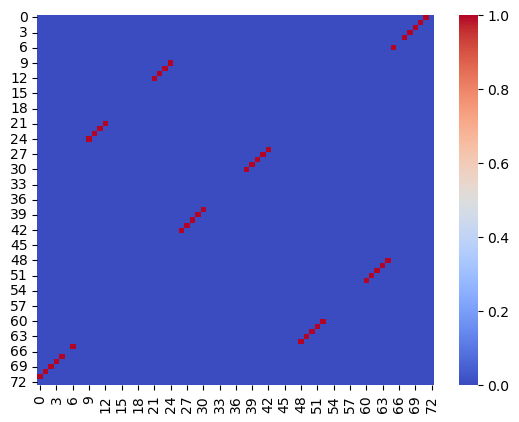

In [63]:
matrix = tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0]
sns.heatmap(matrix, cmap='coolwarm')

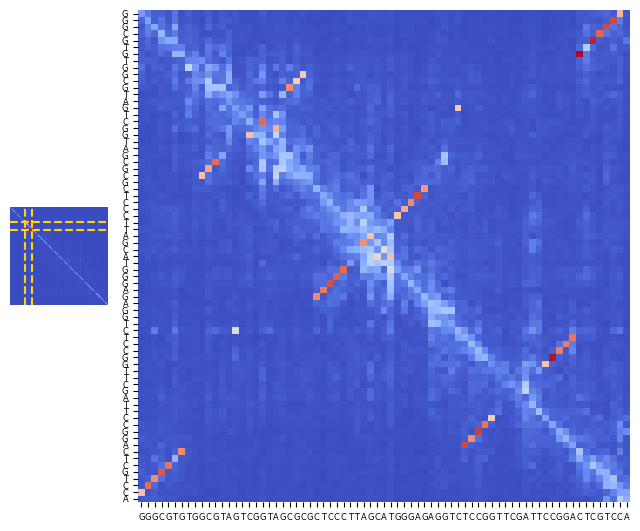

In [64]:
plot_tRNA_w_matrix(trna_gene, zoom_slack=0, effect_on_ref_only=False, plot_size=8, font_size=6, display_dotted_lines=False, width_ratios=[0.2,1],vmax=12)

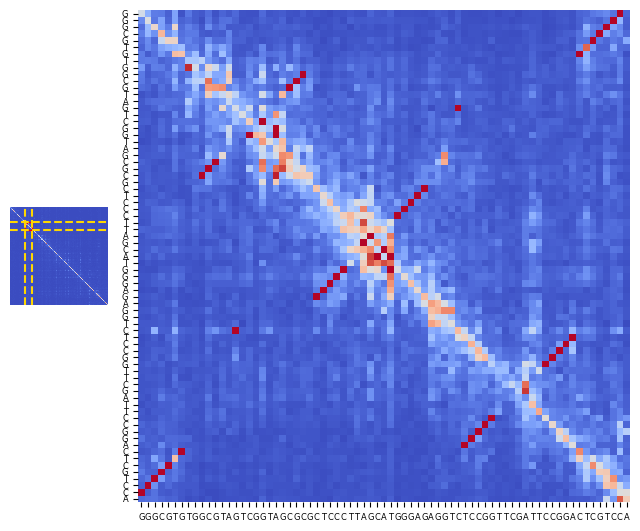

In [66]:
plot_tRNA_w_matrix(trna_gene, zoom_slack=0, effect_on_ref_only=True, plot_size=8, font_size=6, display_dotted_lines=False, width_ratios=[0.2,1])

In [67]:
#create a mask that masks the diagonal and the adjacent diagonals
def create_diag_mask(mask_width = 9, matrix_size = 5): 

    mask = torch.zeros((matrix_size, matrix_size))

    for k in range(-mask_width // 2 + 1, mask_width // 2 + 1):
        mask += torch.diag(torch.ones(matrix_size - abs(k)), diagonal=k)

    mask = 1 - mask
    return mask

def get_upper_triangular_values(matrix):
    
    triang_mask = torch.triu(torch.ones_like(matrix), diagonal=1).bool()
    
    upper_triangular_flattened = torch.masked_select(matrix, triang_mask)
    
    return upper_triangular_flattened

def extract_tRNA_matrix(tRNA_gene_id=None, get_max_ij_ji=False, effect_on_ref_only=False, mask_diag=1, get_max_per_row=False):

    transcript_id = tRNAs_overlapping_unique_start_1000_df.loc[tRNAs_overlapping_unique_start_1000_df['tRNA_gene_id']==tRNA_gene_id, 'transcript_id_start_codon'].values[0]
    ci_matrix = get_ci_matrix(transcript_id=transcript_id) if effect_on_ref_only == False else get_ci_matrix(gene, effect_on_ref_only=effect_on_ref_only)
    tRNA_coords = tRNAs_overlapping_unique_start_1000_df.loc[tRNAs_overlapping_unique_start_1000_df['tRNA_gene_id']==tRNA_gene_id, ['tRNA_rel_start_matrix', 'tRNA_rel_end_matrix']].values.flatten()
        
    x1 = max(tRNA_coords)
    x0 = min(tRNA_coords)

    tRNA_matrix = ci_matrix[x0:x1,x0:x1]

    tRNA_strand = tRNAs_overlapping_unique_start_1000_df.loc[tRNAs_overlapping_unique_start_1000_df['tRNA_gene_id']==tRNA_gene_id, 'Strand'].values[0]
    upstream_region_strand = tRNAs_overlapping_unique_start_1000_df.loc[tRNAs_overlapping_unique_start_1000_df['tRNA_gene_id']==tRNA_gene_id, 'Strand_start_codon'].values[0]

    if tRNA_strand!=upstream_region_strand:
        tRNA_matrix = torch.flip(tRNA_matrix, dims=[0,1])

    if get_max_ij_ji:
        tRNA_matrix = np.maximum(tRNA_matrix, tRNA_matrix.T)
    if mask_diag is not None:
        tRNA_matrix = tRNA_matrix * create_diag_mask(mask_width = mask_diag, matrix_size = tRNA_matrix.shape[0])
    if get_max_per_row:
        max_values, _ = torch.max(tRNA_matrix, dim=1, keepdim=True)
        mask_max = tRNA_matrix == max_values
        tRNA_matrix = tRNA_matrix * mask_max

    return tRNA_matrix

<AxesSubplot: >

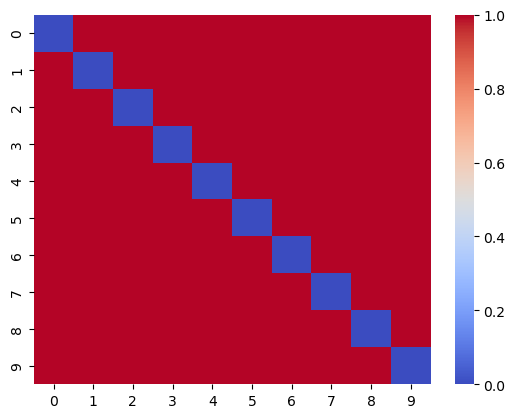

In [68]:
sns.heatmap(create_diag_mask(mask_width = 1,matrix_size=10), cmap='coolwarm')

<AxesSubplot: >

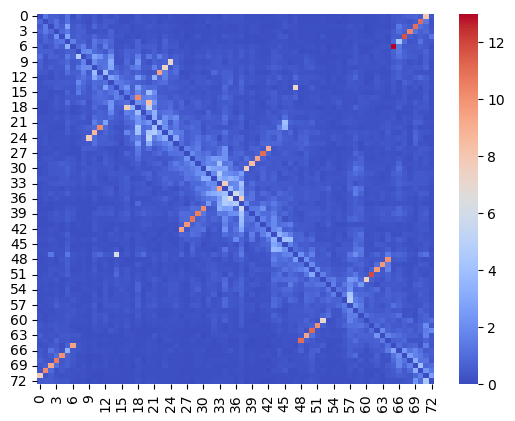

In [69]:
sns.heatmap(extract_tRNA_matrix(trna_gene), cmap='coolwarm')

<AxesSubplot: >

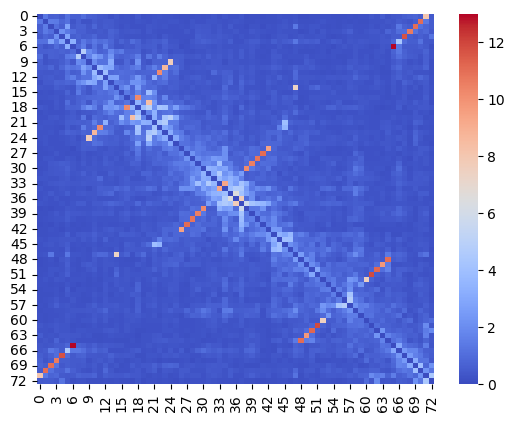

In [70]:
sns.heatmap(extract_tRNA_matrix(trna_gene, get_max_ij_ji=True), cmap='coolwarm')

<AxesSubplot: >

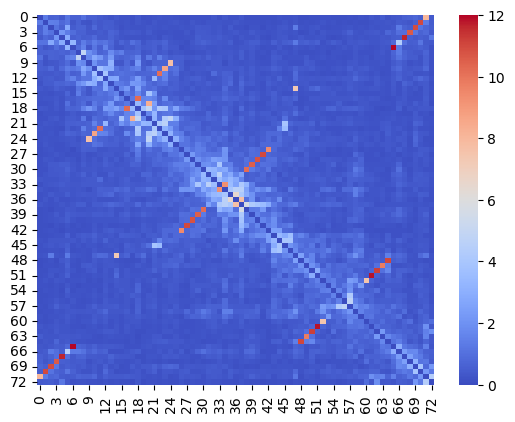

In [71]:
sns.heatmap(extract_tRNA_matrix(trna_gene, get_max_ij_ji=True, mask_diag=1), cmap='coolwarm', vmax=12)

<AxesSubplot: >

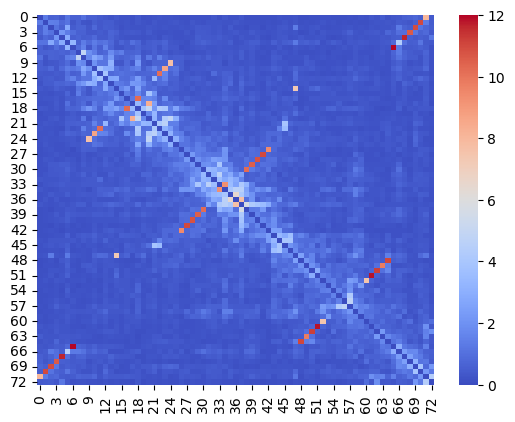

In [73]:
sns.heatmap(extract_tRNA_matrix(trna_gene, get_max_ij_ji=True, mask_diag=1, get_max_per_row=False), cmap='coolwarm', vmax=12)

In [74]:
assert get_upper_triangular_values(tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 
                                                       'contact_matrix'].values[0]).shape == get_upper_triangular_values(
                                                           extract_tRNA_matrix(trna_gene, get_max_ij_ji=True, mask_diag=9, get_max_per_row=True)).shape

In [75]:
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(precision, recall):
    auc_score = auc(recall, precision)

    plt.figure()
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.text(0.7, 0.1, f'AUC: {auc_score:.2f}', fontsize=12, transform=plt.gca().transAxes)  # Adjust position relative to y limits
    plt.show()

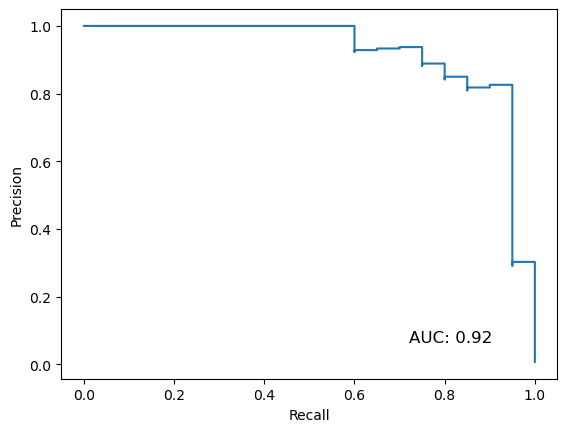

In [77]:
tRNA_scan_values = get_upper_triangular_values(tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0])
ci_matric_tRNA_values = get_upper_triangular_values(extract_tRNA_matrix(trna_gene, get_max_ij_ji=True, mask_diag=1, get_max_per_row=False)) 

assert tRNA_scan_values.shape == ci_matric_tRNA_values.shape

precision, recall, _ = precision_recall_curve(tRNA_scan_values, ci_matric_tRNA_values)

plot_pr_curve(precision, recall)



### +-

<AxesSubplot: >

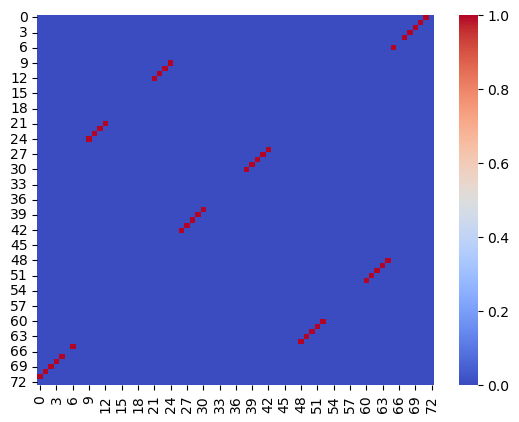

In [78]:
trna_gene = 'tA(AGC)D'
matrix = tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0]
sns.heatmap(matrix, cmap='coolwarm')

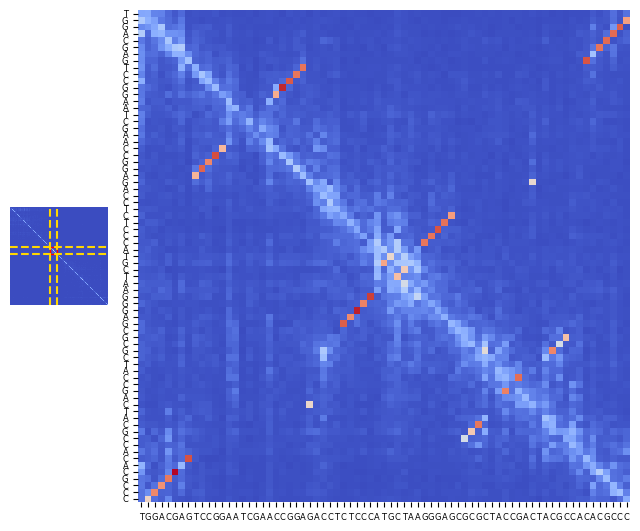

In [79]:
plot_tRNA_w_matrix(trna_gene, zoom_slack=0, effect_on_ref_only=False, plot_size=8, font_size=6, display_dotted_lines=False, width_ratios=[0.2,1],vmax=12)

In case the tRNA is in the + strand and the upstream region in the minus the structure is misaligned, we have to reverse the order 

<AxesSubplot: >

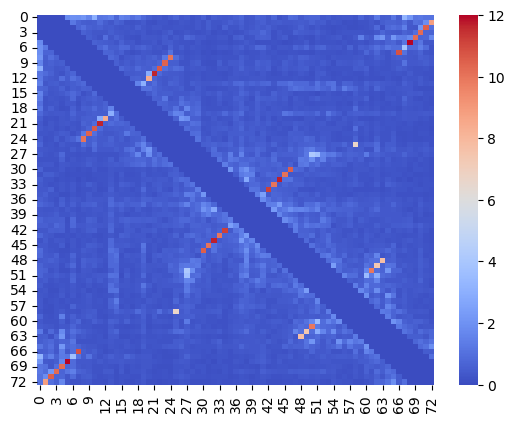

In [80]:
sns.heatmap(torch.flip(extract_tRNA_matrix(trna_gene, get_max_ij_ji=True, mask_diag=9), dims=[0,1]), cmap='coolwarm', vmax=12)

### -+

<AxesSubplot: >

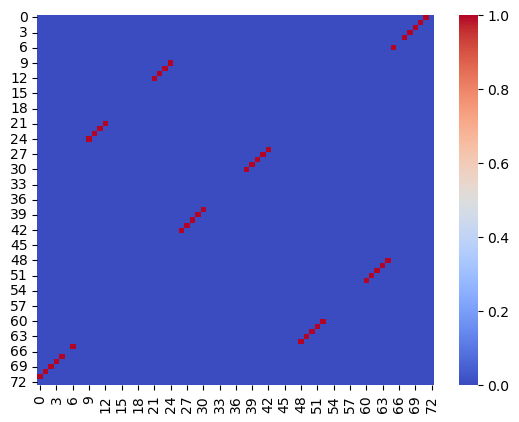

In [81]:
trna_gene = 'tA(AGC)M1'
matrix = tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0]
sns.heatmap(matrix, cmap='coolwarm')

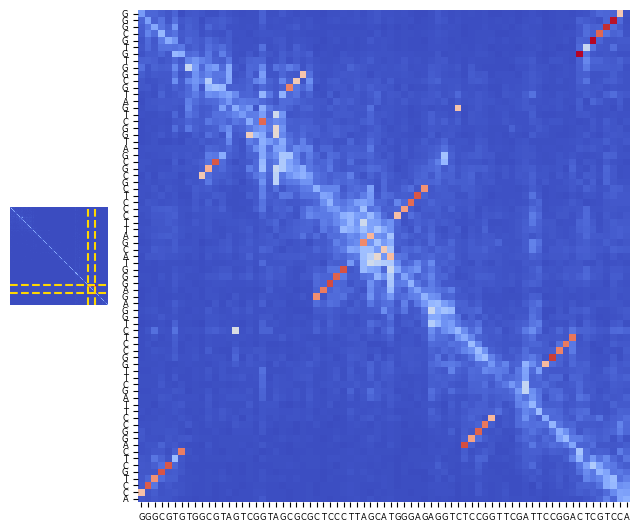

In [82]:
plot_tRNA_w_matrix(trna_gene, zoom_slack=0, effect_on_ref_only=False, plot_size=8, font_size=6, display_dotted_lines=False, width_ratios=[0.2,1],vmax=12)

In case the tRNA is in the - strand and the upstream region in the + the structure is misaligned, we have to reverse the order 

<AxesSubplot: >

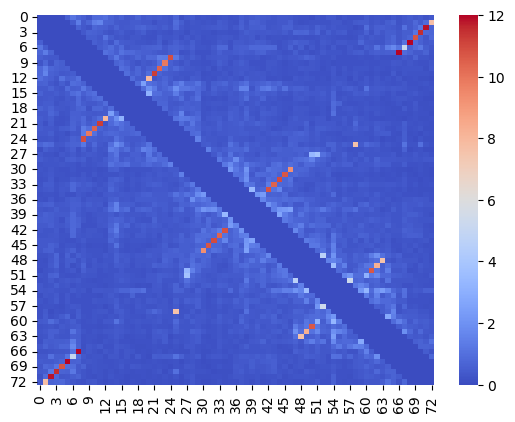

In [83]:
sns.heatmap(torch.flip(extract_tRNA_matrix(trna_gene, get_max_ij_ji=True, mask_diag=9), dims=[0,1]), cmap='coolwarm', vmax=12)

### --

<AxesSubplot: >

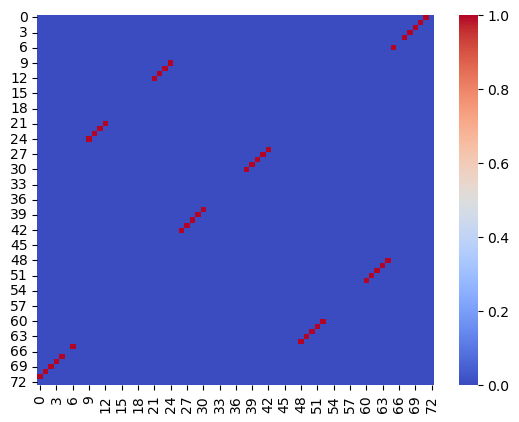

In [84]:
trna_gene = 'tA(AGC)F'
matrix = tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0]
sns.heatmap(matrix, cmap='coolwarm')

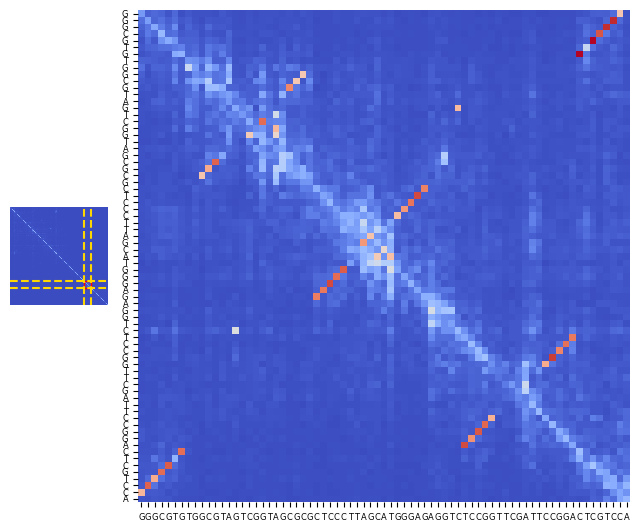

In [85]:
plot_tRNA_w_matrix(trna_gene, zoom_slack=0, effect_on_ref_only=False, plot_size=8, font_size=6, display_dotted_lines=False, width_ratios=[0.2,1],vmax=12)

### Benchmark all tRNAs

In [90]:
from sklearn.metrics import roc_auc_score

tRNA_scan_values_list = []
ci_matric_tRNA_values_list = []
auc_score_list = []
auroc_list = []

assert len(tRNA_lm_scan_df.tRNA_gene_id.unique()) == len(tRNA_lm_scan_df.tRNA_gene_id)

for trna_gene in tRNA_lm_scan_df.tRNA_gene_id.values:

    tRNA_scan_values = get_upper_triangular_values(tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0])
    ci_matric_tRNA_values = get_upper_triangular_values(extract_tRNA_matrix(trna_gene, get_max_ij_ji=True, mask_diag=1, get_max_per_row=False)) 

    assert tRNA_scan_values.shape == ci_matric_tRNA_values.shape

    precision, recall, _ = precision_recall_curve(tRNA_scan_values, ci_matric_tRNA_values)
    auroc = roc_auc_score(tRNA_scan_values, ci_matric_tRNA_values)
    
    auc_score = auc(recall, precision)

    tRNA_scan_values_list.append(tRNA_scan_values)
    ci_matric_tRNA_values_list.append(ci_matric_tRNA_values)
    auc_score_list.append(auc_score)
    auroc_list.append(auroc)


In [91]:
all_tRNA_scan_values = torch.concatenate(tRNA_scan_values_list)
all_ci_matric_tRNA_values = torch.concatenate(ci_matric_tRNA_values_list) 

In [92]:
all_tRNA_scan_values_snp_based = all_tRNA_scan_values
all_ci_matric_tRNA_values_snp_based = all_ci_matric_tRNA_values

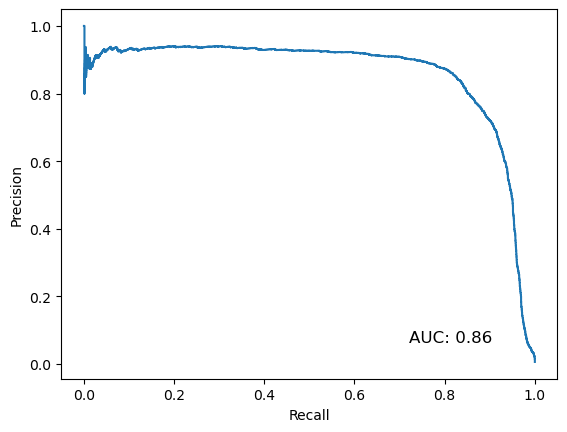

In [93]:
assert all_tRNA_scan_values_snp_based.shape == all_ci_matric_tRNA_values_snp_based.shape

precision_snp_based, recall_snp_based, _ = precision_recall_curve(all_tRNA_scan_values_snp_based, all_ci_matric_tRNA_values_snp_based)

plot_pr_curve(precision_snp_based, recall_snp_based)

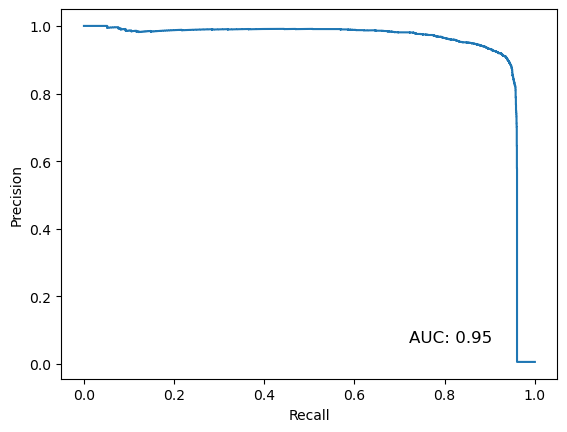

In [74]:
assert all_tRNA_scan_values_snp_based.shape == all_ci_matric_tRNA_values_snp_based.shape

precision_snp_based, recall_snp_based, _ = precision_recall_curve(all_tRNA_scan_values_snp_based, all_ci_matric_tRNA_values_snp_based)

plot_pr_curve(precision_snp_based, recall_snp_based)

In [75]:
np.mean(auc_score_list)

0.9545234896148026

In [94]:
tRNA_auc_df = pd.DataFrame({'tRNA_gene_id':tRNA_lm_scan_df.tRNA_gene_id.values, 'auc_tRNA': auroc_list})
tRNA_auc_df

tRNA_gene_id  auc_tRNA
0       tA(AGC)D  0.999214
1       tA(AGC)F  0.998754
2       tA(AGC)G  0.998811
3      tA(AGC)K1  0.998620
4      tA(AGC)K2  0.998792
..           ...       ...
167    tY(GUA)F1  0.999718
168    tY(GUA)F2  0.999679
169    tY(GUA)J2  0.999756
170    tY(GUA)M2  0.999487
171     tY(GUA)O  0.999692

[172 rows x 2 columns]

In [95]:
tRNA_lm_scan_auc_df = tRNA_lm_scan_df.merge(tRNA_auc_df, on='tRNA_gene_id')
tRNA_lm_scan_auc_df

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
0           IV    sgd    gene  410378  410451     .      +     .     tA(AGC)D   
1           VI    sgd    gene  204923  204996     .      -     .     tA(AGC)F   
2          VII    sgd    gene  774348  774421     .      +     .     tA(AGC)G   
3           XI    sgd    gene  219894  219967     .      +     .    tA(AGC)K1   
4           XI    sgd    gene  517987  518060     .      +     .    tA(AGC)K2   
..         ...    ...     ...     ...     ...   ...    ...   ...          ...   
167         VI    sgd    gene  167436  167525     .      +     .    tY(GUA)F1   
168         VI    sgd    gene  210618  210707     .      -     .    tY(GUA)F2   
169          X    sgd    gene  542955  543044     .      -     .    tY(GUA)J2   
170       XIII    sgd    gene  837927  838016     .      +     .    tY(GUA)M2   
171         XV    sgd    gene  288191  288280     .      +     .     tY(GUA)O   

    gene_name  ... tRNA_rel_end tRNA_rel_start_matrix tRNA_rel_end_matrix  \
0         NaN  ...          594                   479                 406   
1         NaN  ...          173                   754                 827   
2         NaN  ...          771                   156                 229   
3         NaN  ...          356                   571                 644   
4         NaN  ...          137                   790                 863   
..        ...  ...          ...                   ...                 ...   
167     SUP11  ...          267                   822                 733   
168      SUP6  ...          318                   771                 682   
169      SUP4  ...          453                   458                 547   
170      SUP8  ...          170                   741                 830   
171      SUP3  ...          617                   294                 383   

    trna_scan_id                                 tRNA_scan_sequence  \
0          trna3  GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
1          trna6  GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
2         trna15  GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
3          trna4  GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
4          trna9  GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
..           ...                                                ...   
167        trna3  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
168        trna5  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
169       trna13  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTATCA...   
170        trna7  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
171        trna5  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTATCA...   

                                      structure_string score possible_intron  \
0    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
1    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
2    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
3    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
4    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
..                                                 ...   ...             ...   
167  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
168  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
169  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
170  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
171  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   

                                        contact_matrix  auc_tRNA  
0    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.999214  
1    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.998754  
2    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.998811  
3    [[tensor(0), tensor

In [96]:
tRNA_lm_scan_auc_df.sort_values('auc_tRNA', ascending=False)

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
86           V    sgd    gene  100132  100204     .      +     .     tM(CAU)E   
91         XVI    sgd    gene  338847  338919     .      -     .     tM(CAU)P   
88           X    sgd    gene  517812  517884     .      -     .    tM(CAU)J3   
162        VII    sgd    gene  878709  878815     .      -     .    tW(CCA)G2   
90          XV    sgd    gene  710200  710272     .      +     .    tM(CAU)O1   
..         ...    ...     ...     ...     ...   ...    ...   ...          ...   
82         XII    sgd    gene  962971  963055     .      -     .     tL(UAA)L   
79          II    sgd    gene  347602  347686     .      +     .    tL(UAA)B2   
81          XI    sgd    gene   84207   84291     .      +     .     tL(UAA)K   
80           X    sgd    gene  424431  424515     .      -     .     tL(UAA)J   
21         XIV    sgd    gene  519098  519169     .      -     .     tD(GUC)N   

    gene_name  ... tRNA_rel_end tRNA_rel_start_matrix tRNA_rel_end_matrix  \
86       IMT4  ...          564                   364                 436   
91       IMT2  ...          227                   701                 773   
88       IMT3  ...          299                   629                 701   
162       NaN  ...          517                   377                 483   
90       IMT1  ...          173                   755                 827   
..        ...  ...          ...                   ...                 ...   
82        NaN  ...          813                   271                 187   
79        NaN  ...          192                   724                 808   
81        NaN  ...          412                   504                 588   
80      SUP51  ...          725                   359                 275   
21        NaN  ...          253                   676                 747   

    trna_scan_id                                 tRNA_scan_sequence  \
86         trna2  AGCGCCGTGGCGCAGTGGAAGCGCGCAGGGCTCATAACCCTGATGT...   
91        trna15  AGCGCCGTGGCGCAGTGGAAGCGCGCAGGGCTCATAACCCTGATGT...   
88        trna15  AGCGCCGTGGCGCAGTGGAAGCGCGCAGGGCTCATAACCCTGATGT...   
162       trna23  GAAGCGGTGGCTCAATGGTAGAGCTTTCGACTCCAATTAAATCTTG...   
90        trna11  AGCGCCGTGGCGCAGTGGAAGCGCGCAGGGCTCATAACCCTGATGT...   
..           ...                                                ...   
82        trna14  GGAGGGTTGGCCGAGTGGTCTAAGGCGGCAGACTTAAGATCTGTTG...   
79         trna6  GGAGGGTTGGCCGAGTGGTCTAAGGCGGCAGACTTAAGATCTGTTG...   
81         trna2  GGAGGGTTGGCCGAGTGGTCTAAGGCGGCAGACTTAAGATCTGTTG...   
80        trna16  GGAGGGTTGGCCGAGTGGTCTAAGGCGGCAGACTTAAGATCTGTTG...   
21        trna13  TCCAACAAGTTTAATGGTCAGAATGGGCGCTTGTCGCGTGCCAGAT...   

                                      structure_string score possible_intron  \
86   >>>>>>>..>>>>.......<<<<.>>>>>.......<<<<<.......  69.1           False   
91   >>>>>>>..>>>>.......<<<<.>>>>>.......<<<<<.......  69.1           False   
88   >>>>>>>..>>>>.......<<<<.>>>>>.......<<<<<.......  69.1           False   
162  >>>>>>>..>>>>.......<<<<.>>>>>...................  67.2            True   
90   >>>>>>>..>>>>.......<<<<.>>>>>.......<<<<<.......  69.1           False   
..                                                 ...   ...             ...   
82   >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.>...  75.1           False   
79   >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.>...  75.1           False   
81   >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.>...  75.1           False   
80   >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.>...  75.1           False   
21   >>>.>...>>>>........<<<<.>>>>>.......<<<<<.......  27.2           False   

                                        contact_matrix  auc_tRNA  
86   [[tensor(0), tensor(0), tensor(0), tensor(0), ...  1.000000  
91   [[tensor(0), tensor(0), tensor(0), tensor(0), ...  1.000000  
88   [[tensor(0), tensor(0), tensor(0), tensor(0), ...  1.000000  
162  [[tensor(0), tensor

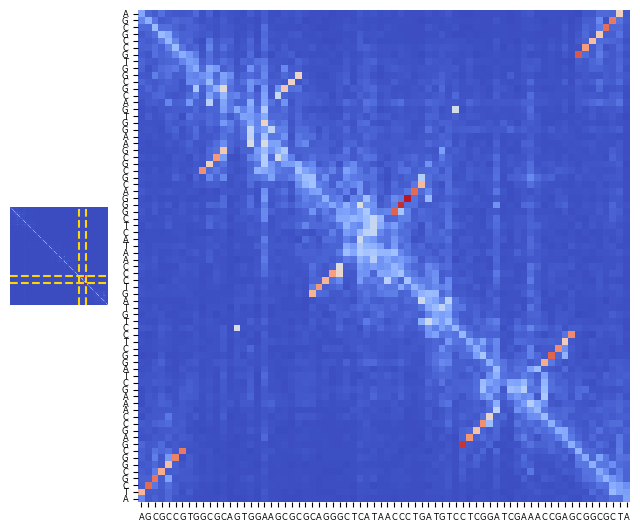

In [97]:
plot_tRNA_w_matrix('tM(CAU)P', zoom_slack=0, effect_on_ref_only=False, plot_size=8, font_size=6, display_dotted_lines=False, width_ratios=[0.2,1],vmax=12)

/opt/modules/i12g/anaconda/envs/fungi_code/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 15'. Pick better value with 'binwidth'.


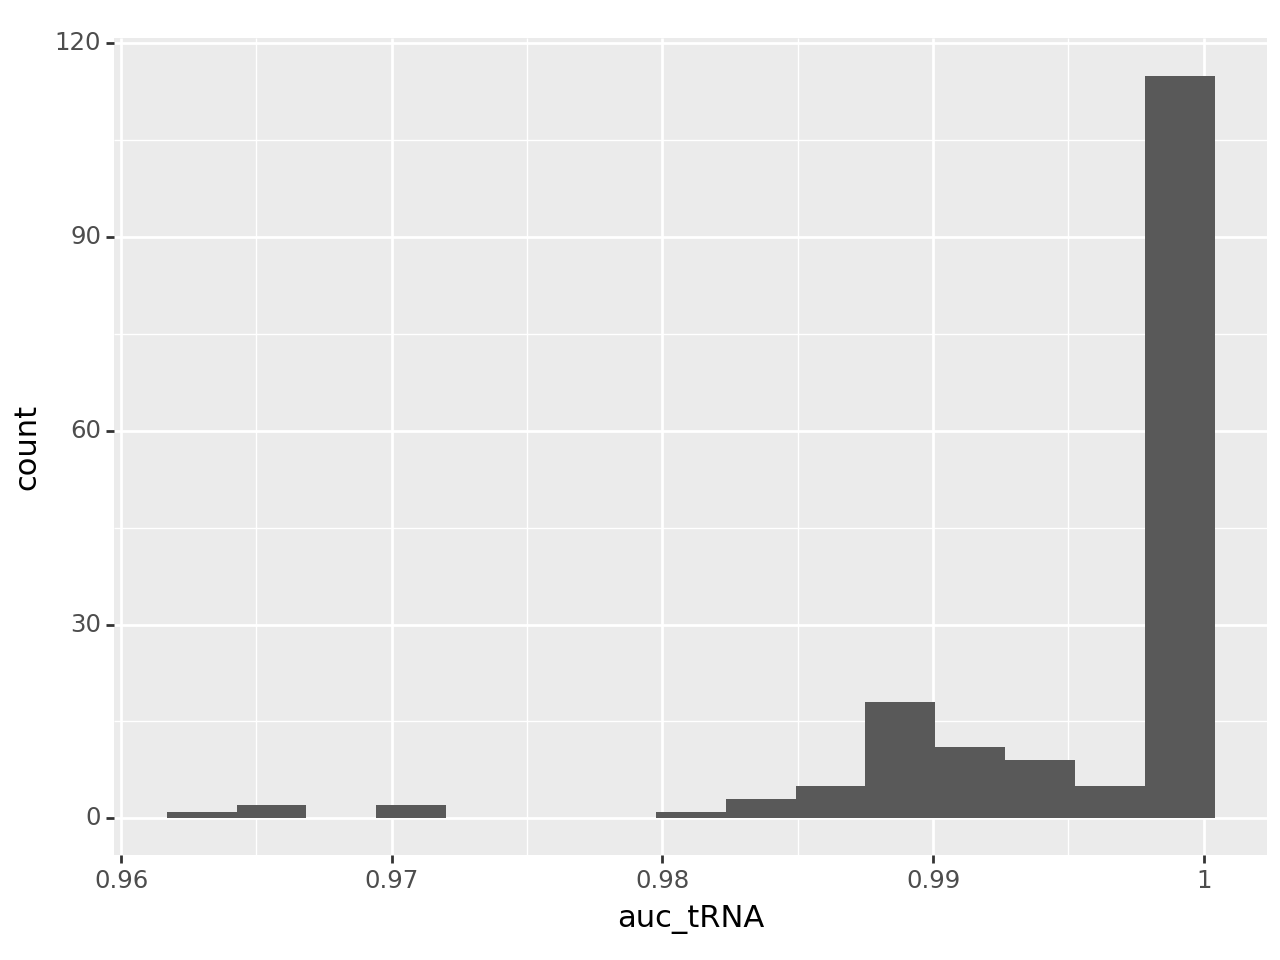

<Figure Size: (640 x 480)>

In [98]:
(ggplot(tRNA_lm_scan_auc_df, aes('auc_tRNA'))
    + geom_histogram())

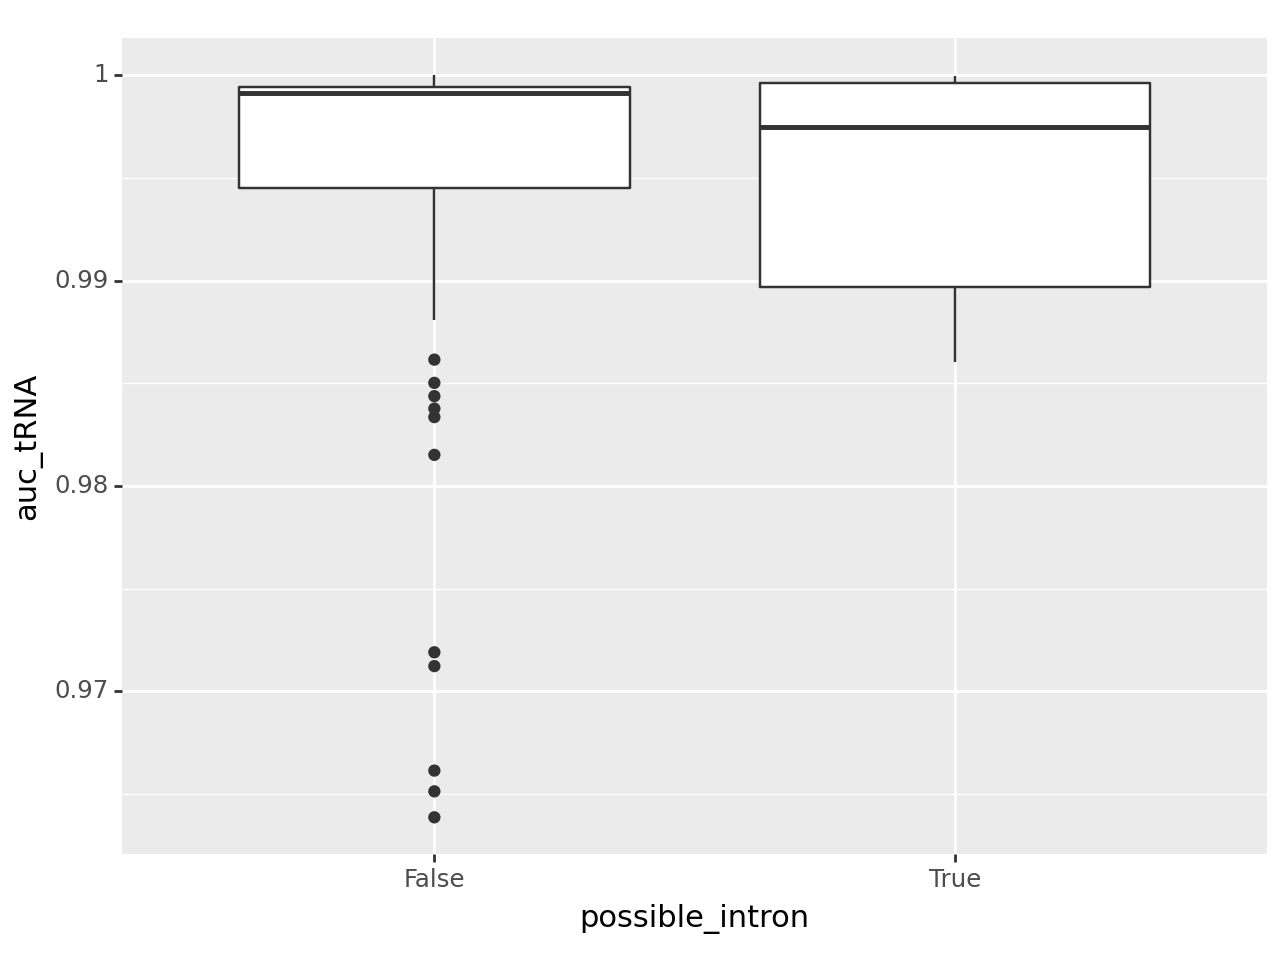

<Figure Size: (640 x 480)>

In [99]:
(ggplot(tRNA_lm_scan_auc_df, aes('possible_intron', 'auc_tRNA'))
    + geom_boxplot())

In [100]:
tRNA_lm_scan_auc_df.columns

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'tRNA_gene_id', 'gene_name', 'gene_source', 'gene_biotype',
       'tRNA_transcript_id', 'transcript_name', 'transcript_source',
       'transcript_biotype', 'exon_number', 'exon_id', 'protein_id', 'seq',
       'Source_b', 'Feature_b', 'Start_start_codon', 'End_start_codon',
       'Score_b', 'Strand_start_codon', 'Frame_b', 'gene_id_start_codon',
       'gene_name_b', 'gene_source_b', 'gene_biotype_b',
       'transcript_id_start_codon', 'transcript_name_b', 'transcript_source_b',
       'transcript_biotype_b', 'exon_number_b', 'exon_id_b', 'protein_id_b',
       'start_codon_start_id', 'Overlap', 'tRNA_length', 'fully_overlaps',
       'tRNA_rel_start', 'tRNA_rel_end', 'tRNA_rel_start_matrix',
       'tRNA_rel_end_matrix', 'trna_scan_id', 'tRNA_scan_sequence',
       'structure_string', 'score', 'possible_intron', 'contact_matrix',
       'auc_tRNA'],
      dtype='object')

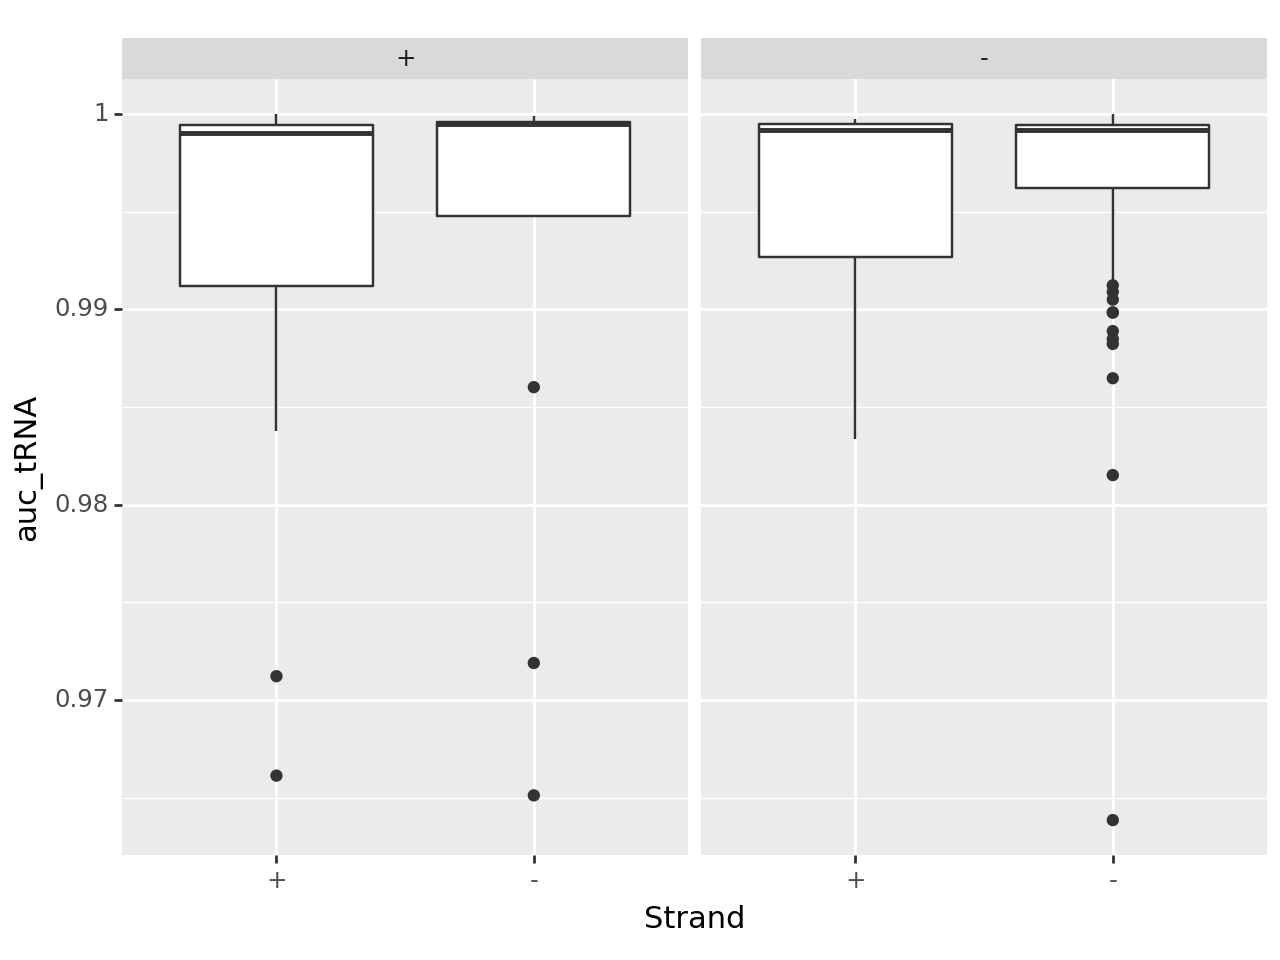

<Figure Size: (640 x 480)>

In [101]:
(ggplot(tRNA_lm_scan_auc_df, aes('Strand', 'auc_tRNA'))
    + geom_boxplot()
    + facet_wrap('~Strand_start_codon'))

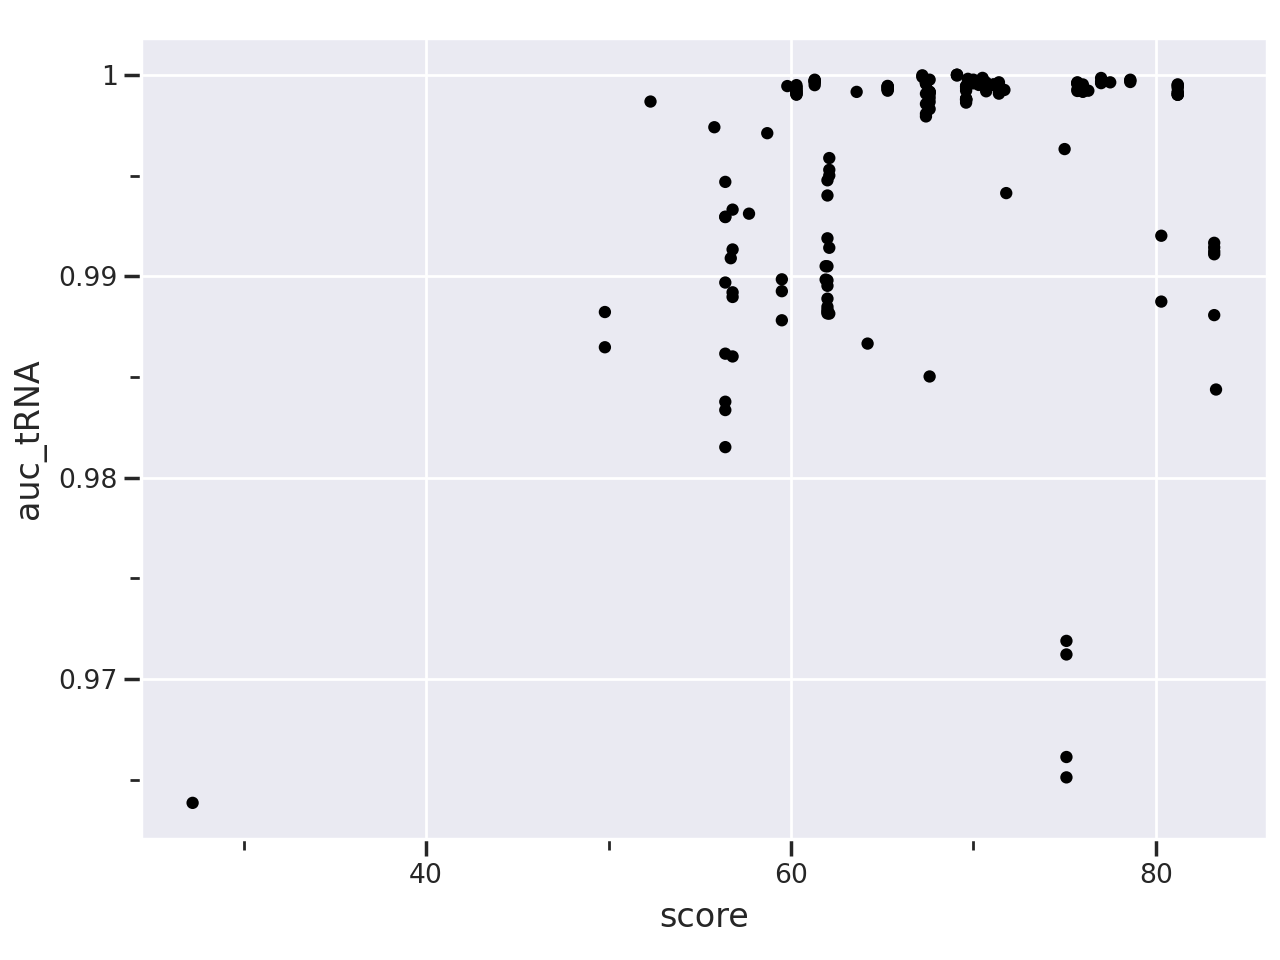

<Figure Size: (640 x 480)>

In [102]:
(ggplot(tRNA_lm_scan_auc_df, aes('score', 'auc_tRNA'))
    + geom_point()
    + theme_seaborn())

<AxesSubplot: >

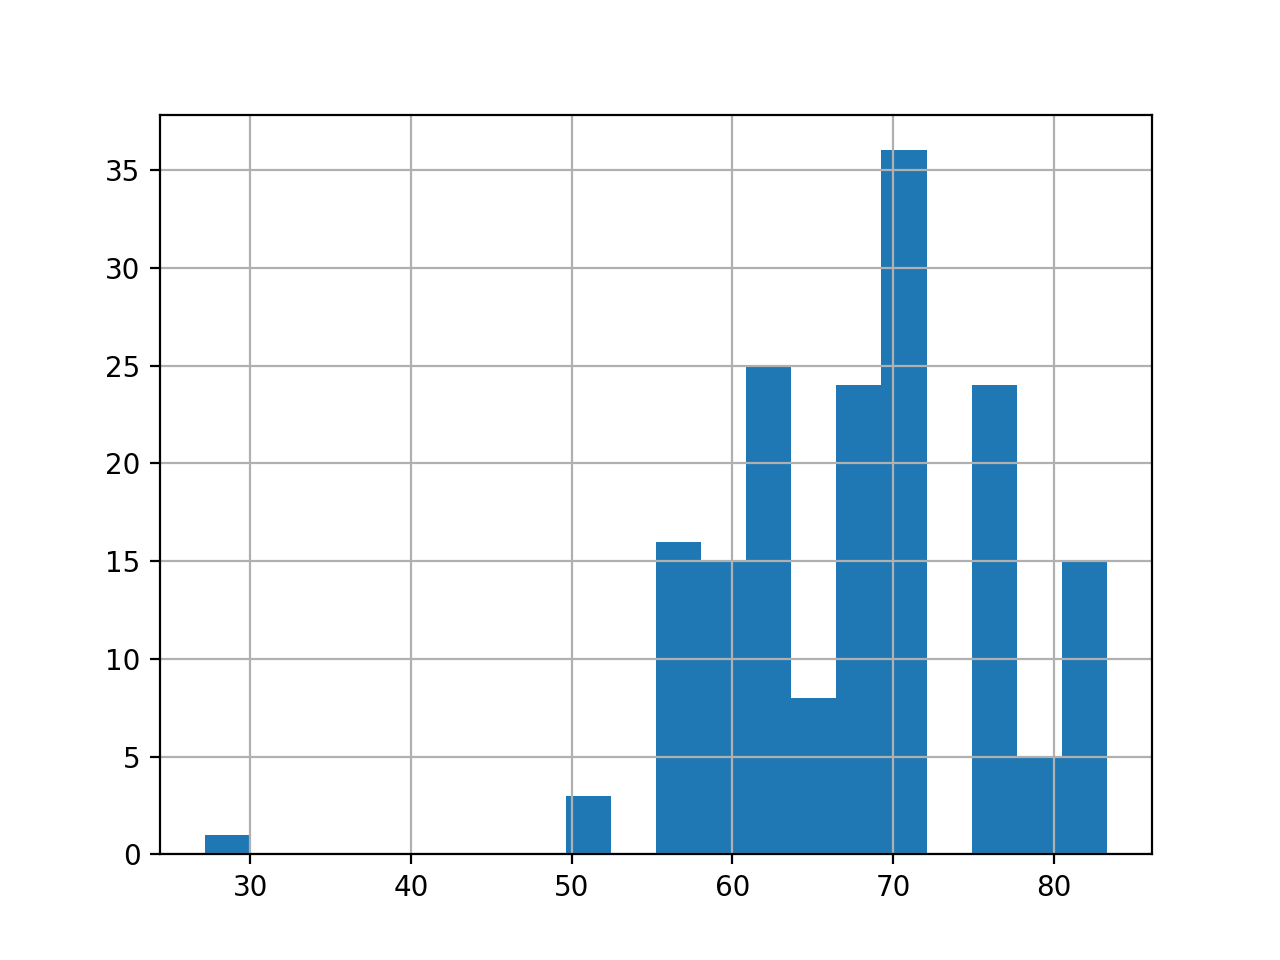

In [103]:
tRNA_lm_scan_auc_df.score.hist(bins=20)

In [104]:
from scipy.stats import spearmanr
spearmanr(tRNA_lm_scan_auc_df['score'], tRNA_lm_scan_auc_df['auc_tRNA'])

SpearmanrResult(correlation=0.32223203038021314, pvalue=1.626900169885074e-05)

In [105]:
tRNA_lm_scan_auc_df[tRNA_lm_scan_auc_df['auc_tRNA']<.9]

Empty DataFrame
Columns: [Chromosome, Source, Feature, Start, End, Score, Strand, Frame, tRNA_gene_id, gene_name, gene_source, gene_biotype, tRNA_transcript_id, transcript_name, transcript_source, transcript_biotype, exon_number, exon_id, protein_id, seq, Source_b, Feature_b, Start_start_codon, End_start_codon, Score_b, Strand_start_codon, Frame_b, gene_id_start_codon, gene_name_b, gene_source_b, gene_biotype_b, transcript_id_start_codon, transcript_name_b, transcript_source_b, transcript_biotype_b, exon_number_b, exon_id_b, protein_id_b, start_codon_start_id, Overlap, tRNA_length, fully_overlaps, tRNA_rel_start, tRNA_rel_end, tRNA_rel_start_matrix, tRNA_rel_end_matrix, trna_scan_id, tRNA_scan_sequence, structure_string, score, possible_intron, contact_matrix, auc_tRNA]
Index: []

[0 rows x 53 columns]

### Benchmark with higher quality tRNAs

In [316]:
tRNA_scan_values_list = []
ci_matric_tRNA_values_list = []
auc_score_list = []

assert len(tRNA_lm_scan_df.tRNA_gene_id.unique()) == len(tRNA_lm_scan_df.tRNA_gene_id)

for trna_gene in tRNA_lm_scan_df.tRNA_gene_id.values:

    tRNA_scan_values = get_upper_triangular_values(tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0])
    score = tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'score'].values[0]

    if score<60:
        print(f'low score of {score}')
        continue

    ci_matric_tRNA_values = get_upper_triangular_values(extract_tRNA_matrix(trna_gene, get_max_ij_ji=True, mask_diag=9)) 

    assert tRNA_scan_values.shape == ci_matric_tRNA_values.shape

    precision, recall, _ = precision_recall_curve(tRNA_scan_values, ci_matric_tRNA_values)
    auc_score = auc(recall, precision)

    tRNA_scan_values_list.append(tRNA_scan_values)
    ci_matric_tRNA_values_list.append(ci_matric_tRNA_values)
    auc_score_list.append(auc_score)


low score of 56.4
low score of 56.4
low score of 56.4
low score of 56.4
low score of 56.4
low score of 56.4
low score of 56.4
low score of 56.4
low score of 27.2
low score of 52.3
low score of 58.7
low score of 57.7
low score of 56.8
low score of 56.7
low score of 56.8
low score of 56.8
low score of 56.8
low score of 56.8
low score of 59.5
low score of 59.5
low score of 59.5
low score of 59.8
low score of 55.8
low score of 49.8
low score of 49.8


In [317]:
all_hq_tRNA_scan_values = torch.concatenate(tRNA_scan_values_list)
all_ci_matric_hq_tRNA_values = torch.concatenate(ci_matric_tRNA_values_list) 

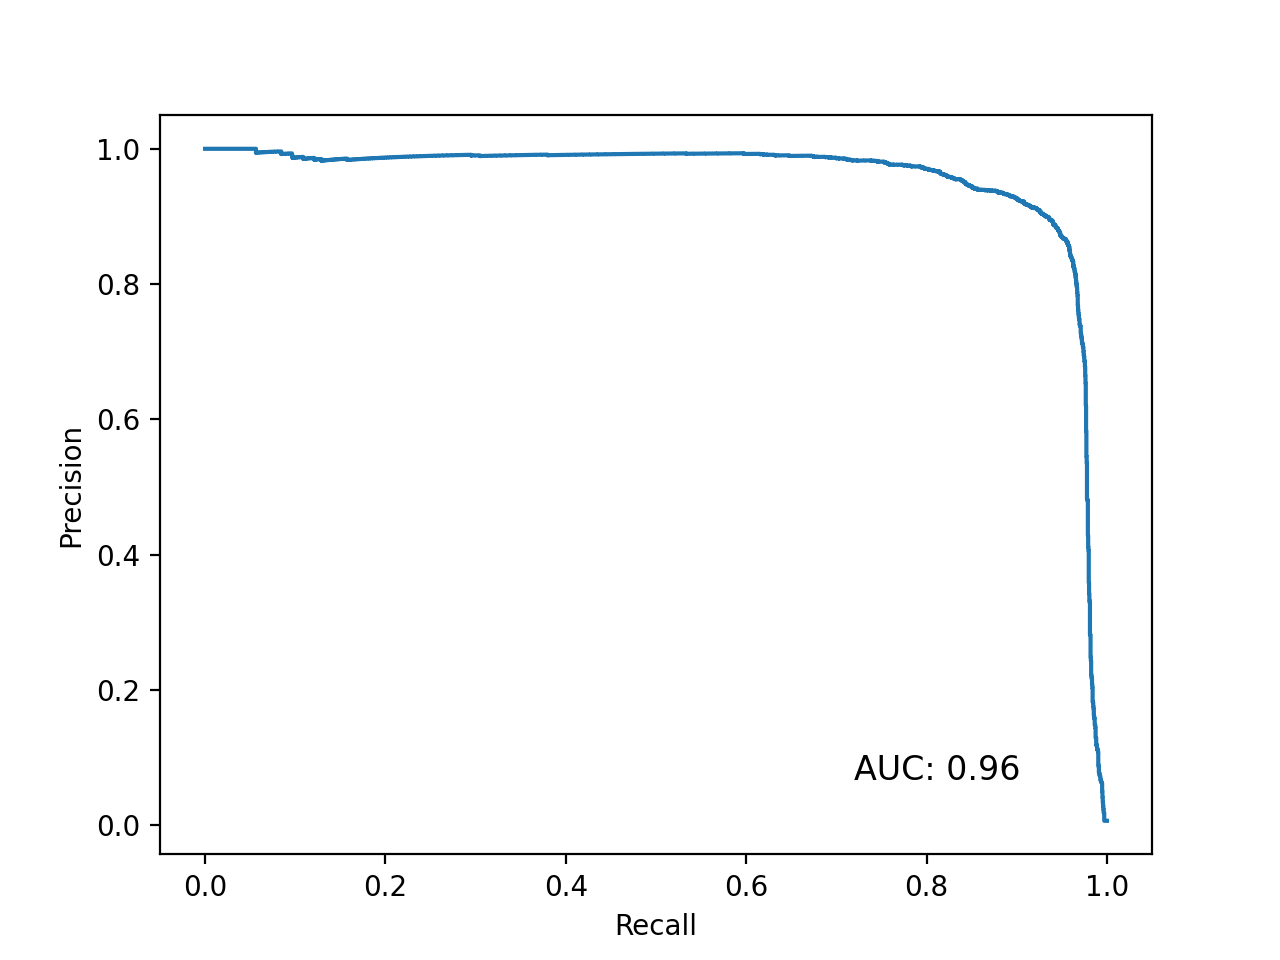

In [318]:
assert all_hq_tRNA_scan_values.shape == all_ci_matric_hq_tRNA_values.shape

precision, recall, _ = precision_recall_curve(all_hq_tRNA_scan_values, all_ci_matric_hq_tRNA_values)

plot_pr_curve(precision, recall)

In [319]:
np.mean(auc_score_list)

0.9633536322522768

## Gradient based

In [ ]:
id_to_path = pd.read_parquet(os.path.join(data_path, f"samples_upstream_kazachstania_k1_grads/{species_of_interest}/id_to_path.parquet"))


In [106]:
gene_id_to_transcript_id = pr.read_gtf(gtf_path).df[['gene_id', 'transcript_id']].drop_duplicates().dropna().reset_index(drop=True)
id_to_path = pd.read_parquet(os.path.join(data_path, f"samples_upstream_kazachstania_k1_grads/{species_of_interest}/id_to_path.parquet"))
                             
id_to_path = id_to_path.merge(gene_id_to_transcript_id, on='transcript_id')

all_genes = list(id_to_path['gene_id'].unique())

def get_ci_matrix(gene_id=None, id_to_path_grads=id_to_path, transcript_id=None, correct_gradients=False, reorder=True):

    if not transcript_id:
        # subset snp df
        subset_df = id_to_path_grads.query('gene_id == "{}"'.format(gene_id))#.iloc[0]["path"]
        if len(subset_df) == 0:
            return None
        # take first transcript
        transcript_id = subset_df.iloc[0]["transcript_id"]
        subset_df = subset_df.query('transcript_id == "{}"'.format(transcript_id))
    else:
        subset_df = id_to_path_grads.query('transcript_id == "{}"'.format(transcript_id))
    # get path and indices
    path = subset_df.iloc[0]["path"].replace("nuc_preds","nuc_grads") ## FIXME
    idx_in_file = subset_df.iloc[0]["idx_in_file"]
    # load gradients
    grads = torch.load(path).float()
    grads = grads[idx_in_file] # output --> 1003,4,4,1003 <-- variant
    # reorder
    grads = grads.permute(2,3,0,1) # variant --> 4,1003,1003,4 <-- output
    # Note: this is in BERT-order (ATCG), not standard one-hot order (ACGT)
    if reorder:
        g_reord_col = torch.zeros_like(grads)
        for mapping in [(0,0),(1,2),(2,3),(3,1)]:
            g_reord_col[:,:,:,mapping[0]] = grads[:,:,:,mapping[1]]
        g_reord = torch.zeros_like(g_reord_col)
        for mapping in [(0,0),(1,2),(2,3),(3,1)]:
            g_reord[mapping[0],:,:,:] = g_reord_col[mapping[1],:,:,:]
        grads = g_reord
    if correct_gradients:
        # remove average over possible variant nucleotides
        grads = grads - grads.mean(axis=0,keepdims=True)

    grads = torch.abs(grads).max(dim=0)[0].max(dim=2)[0] # get the maximum absolute value over the 4x4 nuc possibilities per position
    return grads

In [107]:
trna_gene = 'tA(AGC)G'

<AxesSubplot: >

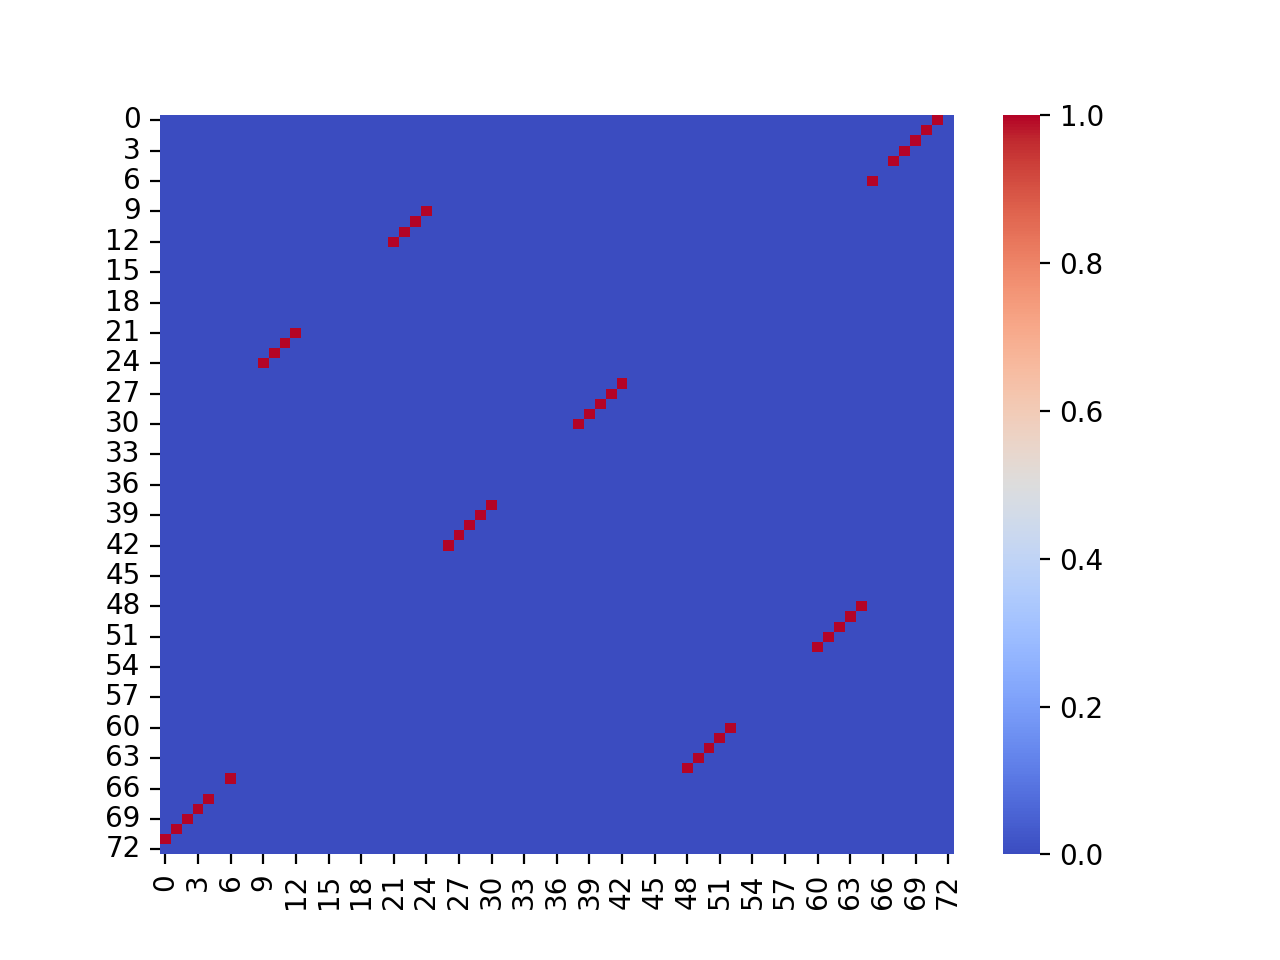

In [108]:
matrix = tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0]
sns.heatmap(matrix, cmap='coolwarm')

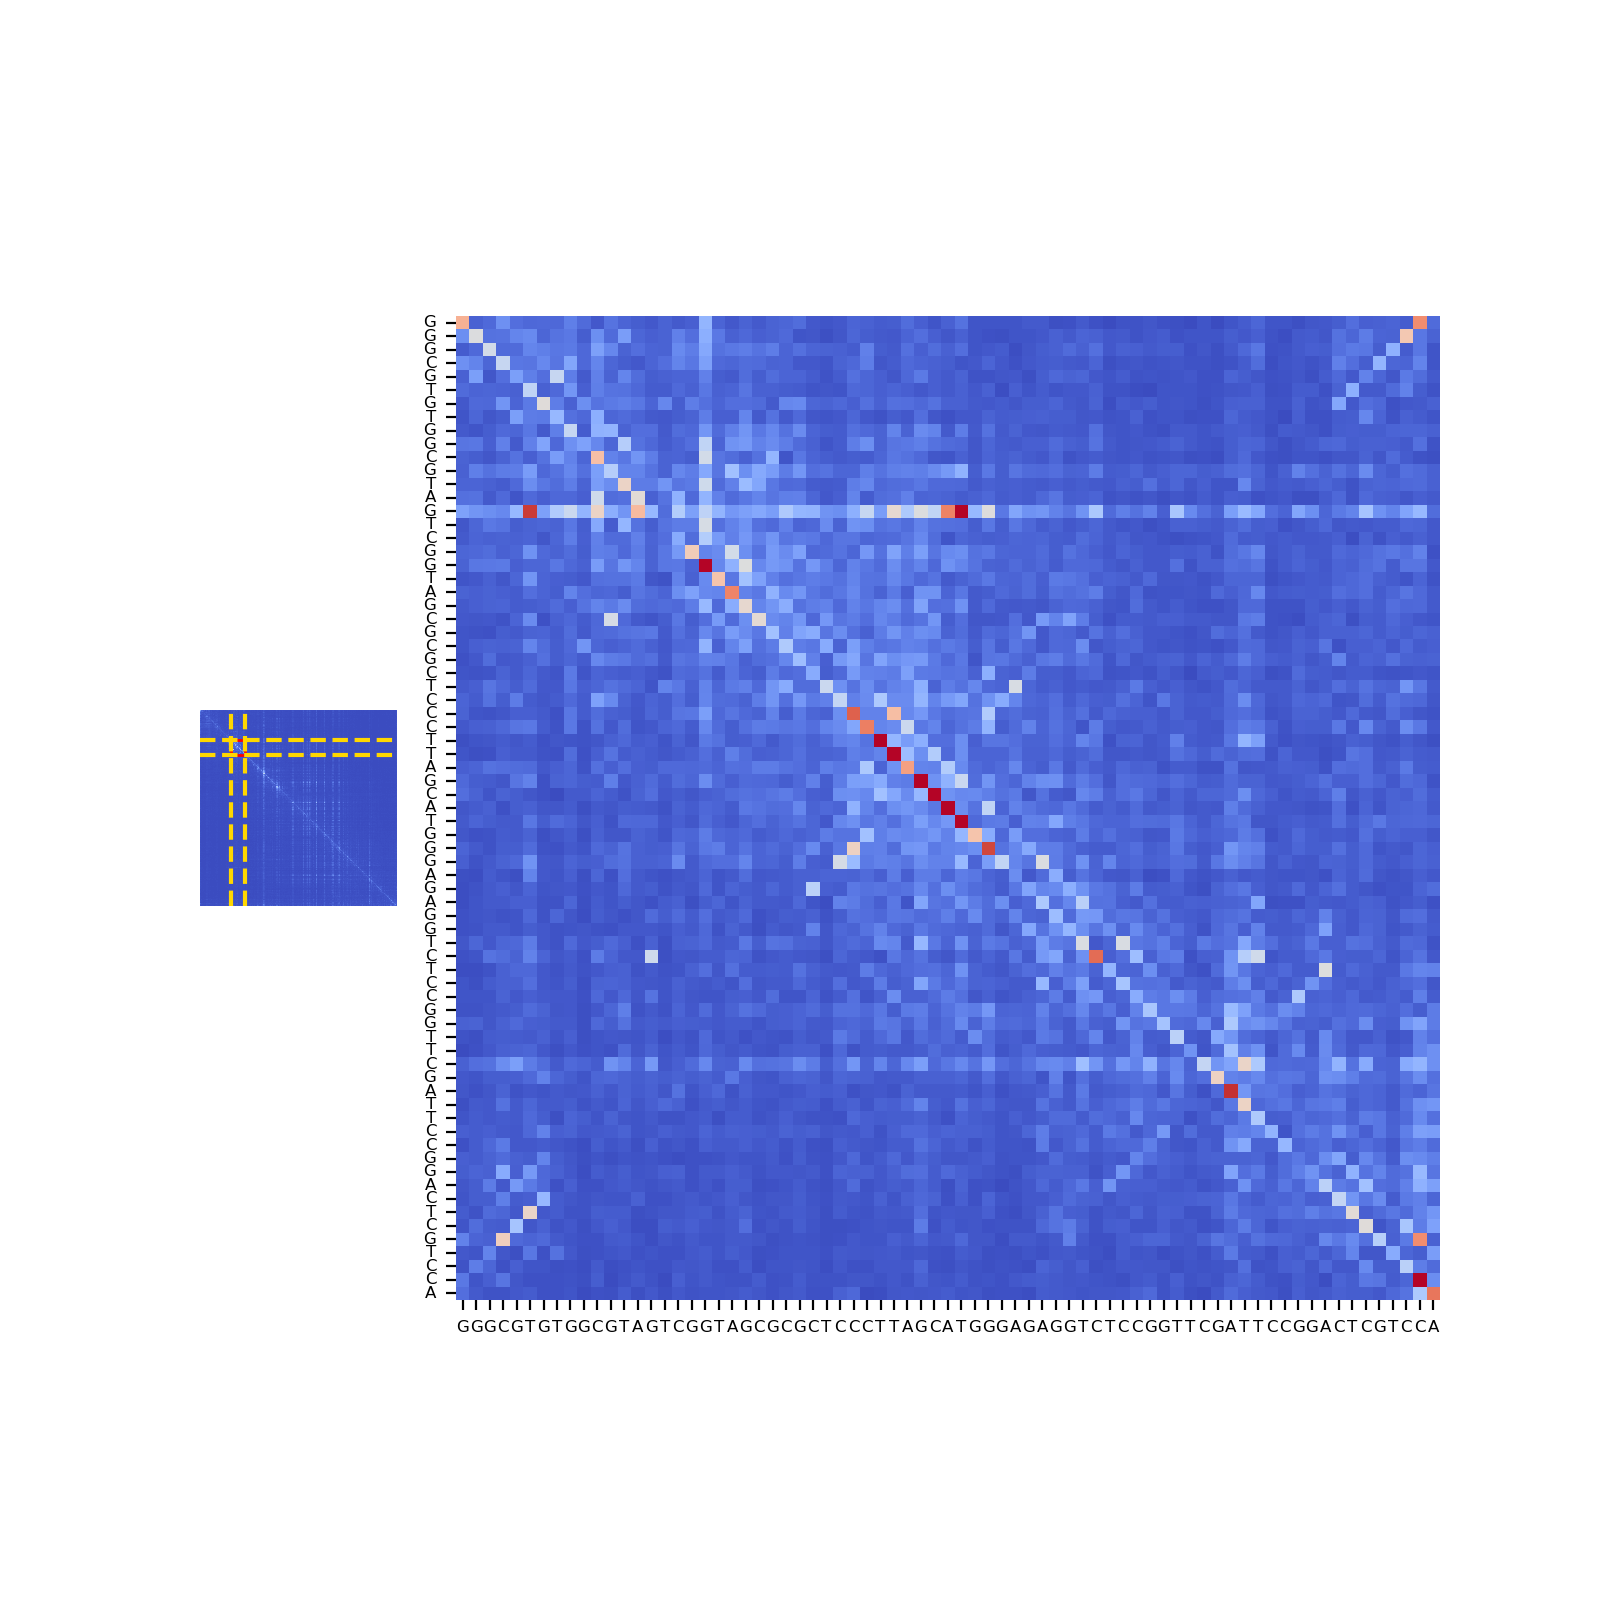

In [110]:
plot_tRNA_w_matrix(trna_gene, zoom_slack=0, effect_on_ref_only=False, plot_size=8, font_size=6, display_dotted_lines=False, width_ratios=[0.2,1],vmax=0.05)

In [114]:
tRNA_scan_values_list = []
ci_matric_tRNA_values_list = []
auc_score_list = []
auroc_list =[]
n_trnas = len(tRNA_lm_scan_df.tRNA_gene_id)

assert len(tRNA_lm_scan_df.tRNA_gene_id.unique()) == n_trnas

for i, trna_gene in enumerate(tRNA_lm_scan_df.tRNA_gene_id.values):
    print(f'tRNA {i} of {n_trnas}')

    tRNA_scan_values = get_upper_triangular_values(tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0])
    ci_matric_tRNA_values = get_upper_triangular_values(extract_tRNA_matrix(trna_gene, get_max_ij_ji=True, mask_diag=1)) 

    assert tRNA_scan_values.shape == ci_matric_tRNA_values.shape

    precision, recall, _ = precision_recall_curve(tRNA_scan_values, ci_matric_tRNA_values)
    auroc = roc_auc_score(tRNA_scan_values, ci_matric_tRNA_values)
    
    auc_score = auc(recall, precision)

    tRNA_scan_values_list.append(tRNA_scan_values)
    ci_matric_tRNA_values_list.append(ci_matric_tRNA_values)
    auc_score_list.append(auc_score)
    auroc_list.append(auroc)


tRNA 0 of 172
tRNA 1 of 172
tRNA 2 of 172
tRNA 3 of 172
tRNA 4 of 172
tRNA 5 of 172
tRNA 6 of 172
tRNA 7 of 172
tRNA 8 of 172
tRNA 9 of 172
tRNA 10 of 172
tRNA 11 of 172
tRNA 12 of 172
tRNA 13 of 172
tRNA 14 of 172
tRNA 15 of 172
tRNA 16 of 172
tRNA 17 of 172
tRNA 18 of 172
tRNA 19 of 172
tRNA 20 of 172
tRNA 21 of 172
tRNA 22 of 172
tRNA 23 of 172
tRNA 24 of 172
tRNA 25 of 172
tRNA 26 of 172
tRNA 27 of 172
tRNA 28 of 172
tRNA 29 of 172
tRNA 30 of 172
tRNA 31 of 172
tRNA 32 of 172
tRNA 33 of 172
tRNA 34 of 172
tRNA 35 of 172
tRNA 36 of 172
tRNA 37 of 172
tRNA 38 of 172
tRNA 39 of 172
tRNA 40 of 172
tRNA 41 of 172
tRNA 42 of 172
tRNA 43 of 172
tRNA 44 of 172
tRNA 45 of 172
tRNA 46 of 172
tRNA 47 of 172
tRNA 48 of 172
tRNA 49 of 172
tRNA 50 of 172
tRNA 51 of 172
tRNA 52 of 172
tRNA 53 of 172
tRNA 54 of 172
tRNA 55 of 172
tRNA 56 of 172
tRNA 57 of 172
tRNA 58 of 172
tRNA 59 of 172
tRNA 60 of 172
tRNA 61 of 172
tRNA 62 of 172
tRNA 63 of 172
tRNA 64 of 172
tRNA 65 of 172
tRNA 66 of 172
tRNA 

In [115]:
all_tRNA_scan_values_grad_based = torch.concatenate(tRNA_scan_values_list)
all_ci_matric_tRNA_values_grad_based = torch.concatenate(ci_matric_tRNA_values_list) 

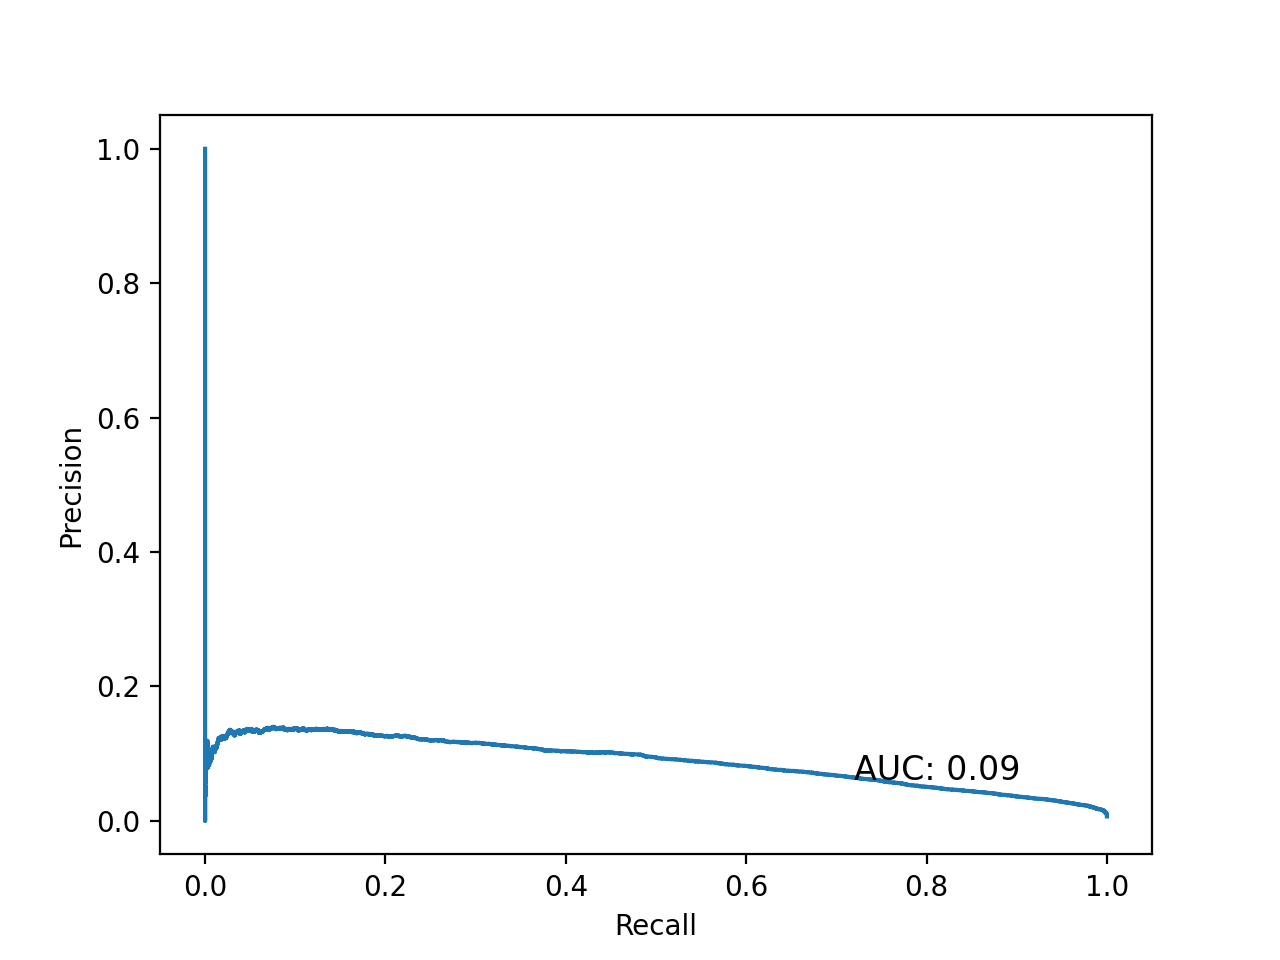

In [116]:
assert all_tRNA_scan_values_grad_based.shape == all_ci_matric_tRNA_values_grad_based.shape

precision_grad_based, recall_grad_based, _ = precision_recall_curve(all_tRNA_scan_values_grad_based, all_ci_matric_tRNA_values_grad_based)

plot_pr_curve(precision_grad_based, recall_grad_based)

In [117]:
tRNA_auc_df = pd.DataFrame({'tRNA_gene_id':tRNA_lm_scan_df.tRNA_gene_id.values, 'auc_tRNA_grad': auroc_list})
tRNA_auc_df

tRNA_gene_id  auc_tRNA_grad
0       tA(AGC)D       0.975767
1       tA(AGC)F       0.971357
2       tA(AGC)G       0.971741
3      tA(AGC)K1       0.959643
4      tA(AGC)K2       0.961810
..           ...            ...
167    tY(GUA)F1       0.947690
168    tY(GUA)F2       0.934548
169    tY(GUA)J2       0.958111
170    tY(GUA)M2       0.967518
171     tY(GUA)O       0.979505

[172 rows x 2 columns]

In [118]:
tRNA_lm_scan_auc_df = tRNA_lm_scan_auc_df.merge(tRNA_auc_df, on='tRNA_gene_id')
tRNA_lm_scan_auc_df

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
0           IV    sgd    gene  410378  410451     .      +     .     tA(AGC)D   
1           VI    sgd    gene  204923  204996     .      -     .     tA(AGC)F   
2          VII    sgd    gene  774348  774421     .      +     .     tA(AGC)G   
3           XI    sgd    gene  219894  219967     .      +     .    tA(AGC)K1   
4           XI    sgd    gene  517987  518060     .      +     .    tA(AGC)K2   
..         ...    ...     ...     ...     ...   ...    ...   ...          ...   
167         VI    sgd    gene  167436  167525     .      +     .    tY(GUA)F1   
168         VI    sgd    gene  210618  210707     .      -     .    tY(GUA)F2   
169          X    sgd    gene  542955  543044     .      -     .    tY(GUA)J2   
170       XIII    sgd    gene  837927  838016     .      +     .    tY(GUA)M2   
171         XV    sgd    gene  288191  288280     .      +     .     tY(GUA)O   

    gene_name  ... tRNA_rel_start_matrix tRNA_rel_end_matrix trna_scan_id  \
0         NaN  ...                   479                 406        trna3   
1         NaN  ...                   754                 827        trna6   
2         NaN  ...                   156                 229       trna15   
3         NaN  ...                   571                 644        trna4   
4         NaN  ...                   790                 863        trna9   
..        ...  ...                   ...                 ...          ...   
167     SUP11  ...                   822                 733        trna3   
168      SUP6  ...                   771                 682        trna5   
169      SUP4  ...                   458                 547       trna13   
170      SUP8  ...                   741                 830        trna7   
171      SUP3  ...                   294                 383        trna5   

                                    tRNA_scan_sequence  \
0    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
1    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
2    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
3    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
4    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
..                                                 ...   
167  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
168  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
169  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTATCA...   
170  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
171  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTATCA...   

                                      structure_string score possible_intron  \
0    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
1    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
2    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
3    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
4    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
..                                                 ...   ...             ...   
167  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
168  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
169  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
170  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
171  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   

                                        contact_matrix  auc_tRNA auc_tRNA_grad  
0    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.999214      0.975767  
1    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.998754      0.971357  
2    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.998811      0.971741  
3    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.998620      0.959643  
4    [[tensor(0), tensor(0), tensor(0), ten

## Masking based

In [120]:
real_seqs_df = pd.read_csv(os.path.join(data_path, f'Saccharomyces_cerevisiae_BY4741_upstream_1000bp_with_start_cds_downstream_509bp_with_stop_longest_cds.tsv'), sep='\t')

matrices_path_species = os.path.join(data_path, 'Saccharomyces_cerevisiae_BY4741_k1_model_mask_based')

print(f'Loading stored gene id ci matrices from {matrices_path_species}...')

#create a dict with the file names and the file paths
genes_to_files = {f.split('.npy')[0]: os.path.join(matrices_path_species, f) for f in os.listdir(matrices_path_species)}
#all_genes = list(genes_to_files.keys())

def get_ci_matrix(transcript_id):
    if transcript_id in snp_df.transcript_id.unique(): #only get transcripts if they are also in the previous methods. Currently this dataset was computed with not exactly the same number of transcripts. Can be fixed later on but won't influence results as we take the intersection and we assert that later on
        gene_id = real_seqs_df[real_seqs_df.transcript_id == transcript_id].gene_id.values[0]
        if gene_id in genes_to_files:
            return torch.tensor(np.load(genes_to_files[gene_id])).to(torch.float32)
        else:
            return None

Loading stored gene id ci matrices from /s/project/multispecies/fungi_code/ci_matrices/data/Saccharomyces_cerevisiae_BY4741_k1_model_mask_based...


In [121]:
trna_gene = 'tA(AGC)G'

<AxesSubplot: >

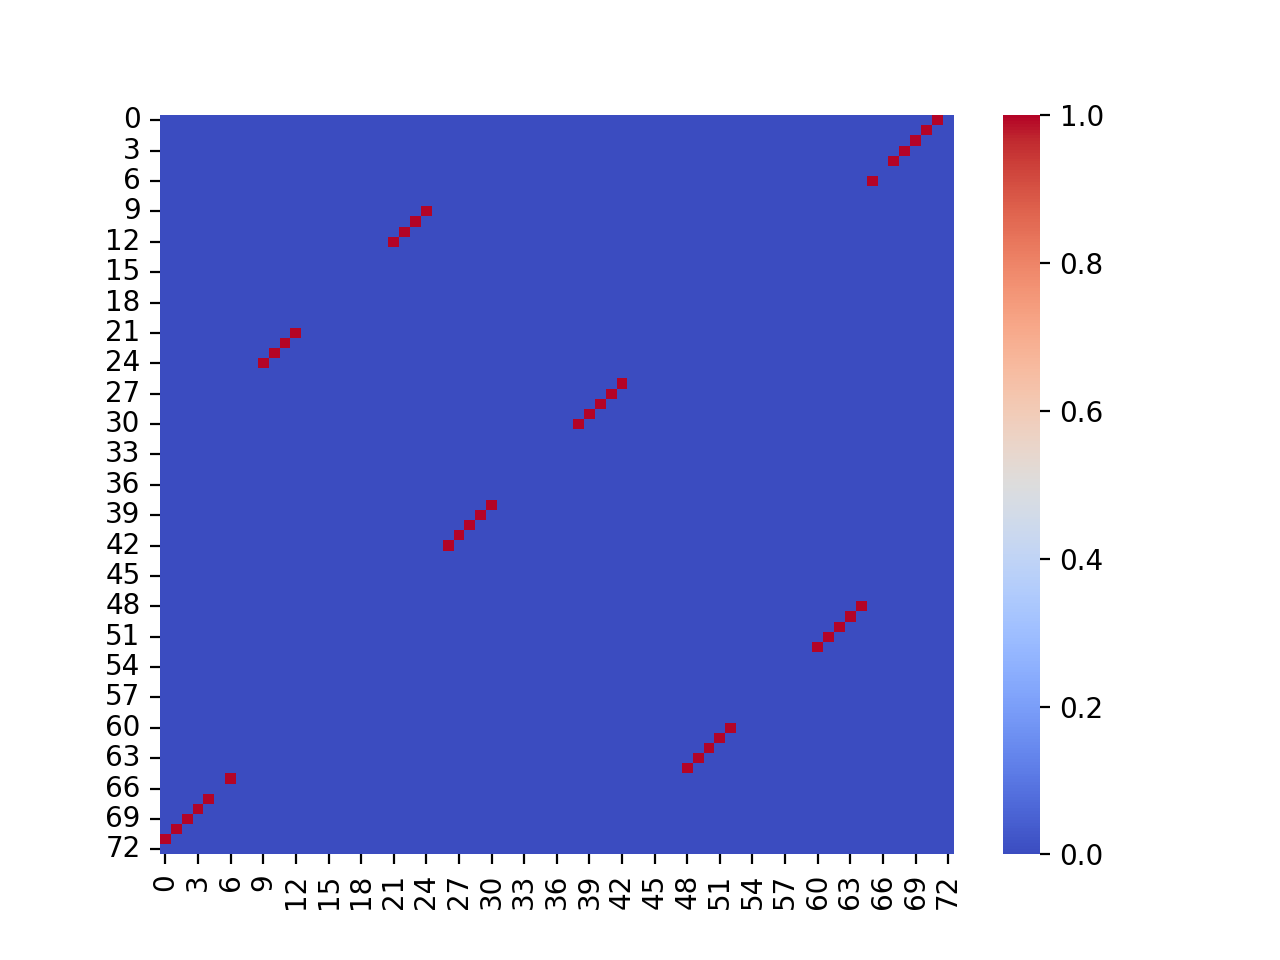

In [122]:
matrix = tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0]
sns.heatmap(matrix, cmap='coolwarm')

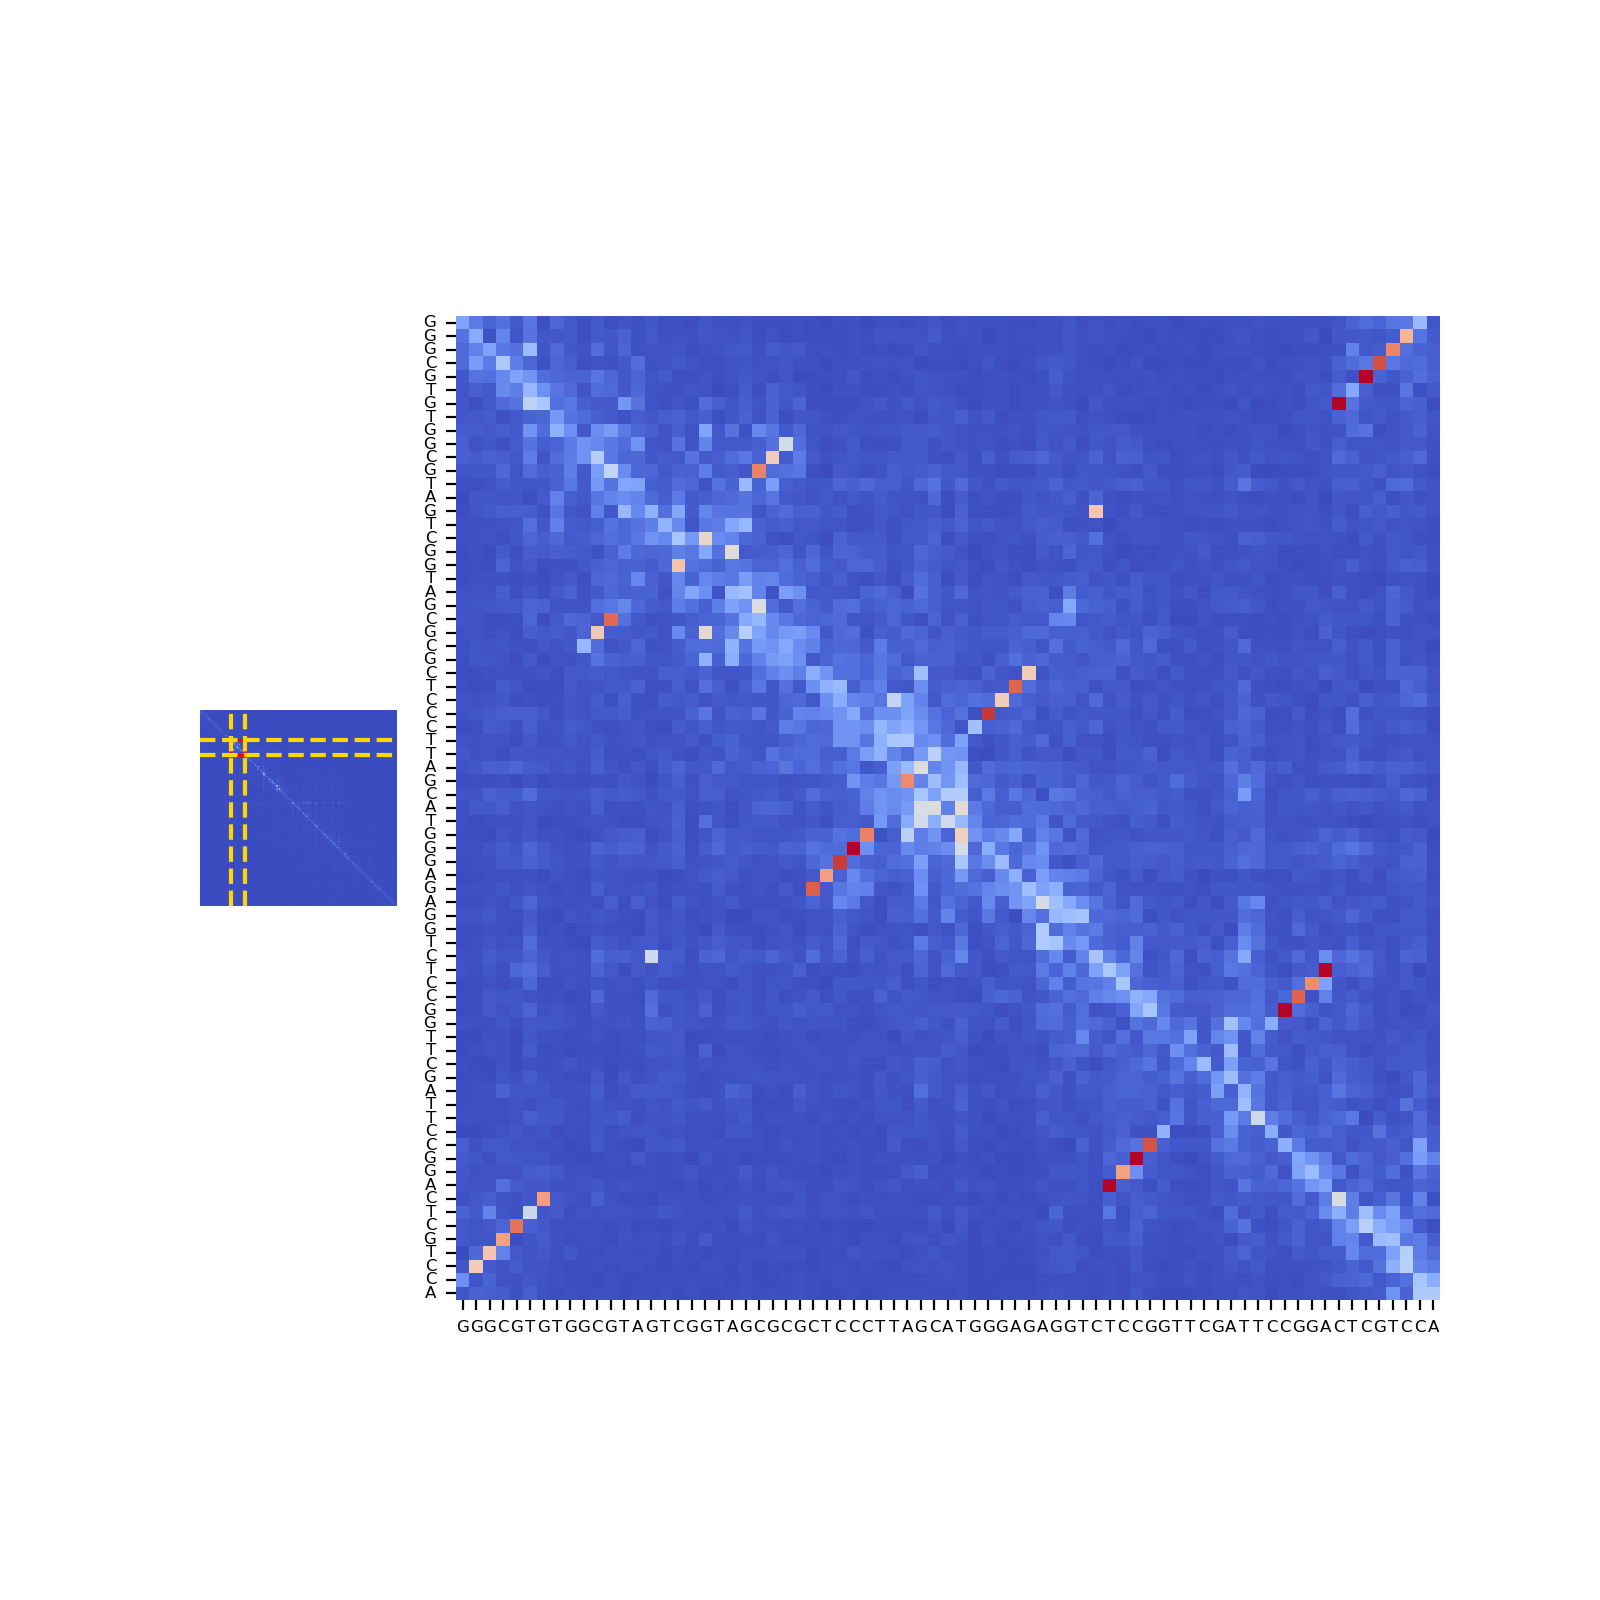

In [123]:
plot_tRNA_w_matrix(trna_gene, zoom_slack=0, effect_on_ref_only=False, plot_size=8, font_size=6, display_dotted_lines=False, width_ratios=[0.2,1],vmax=5)

In [127]:
tRNA_scan_values_list = []
ci_matric_tRNA_values_list = []
auc_score_list = []
auroc_list = []
n_trnas = len(tRNA_lm_scan_df.tRNA_gene_id)

assert len(tRNA_lm_scan_df.tRNA_gene_id.unique()) == n_trnas

for i, trna_gene in enumerate(tRNA_lm_scan_df.tRNA_gene_id.values):
    print(f'tRNA {i} of {n_trnas}')

    tRNA_scan_values = get_upper_triangular_values(tRNA_lm_scan_df.loc[tRNA_lm_scan_df.tRNA_gene_id==trna_gene, 'contact_matrix'].values[0])
    ci_matric_tRNA_values = get_upper_triangular_values(extract_tRNA_matrix(trna_gene, get_max_ij_ji=True, mask_diag=1)) 

    assert tRNA_scan_values.shape == ci_matric_tRNA_values.shape

    precision, recall, _ = precision_recall_curve(tRNA_scan_values, ci_matric_tRNA_values)
    auroc = roc_auc_score(tRNA_scan_values, ci_matric_tRNA_values)
    
    auc_score = auc(recall, precision)

    tRNA_scan_values_list.append(tRNA_scan_values)
    ci_matric_tRNA_values_list.append(ci_matric_tRNA_values)
    auc_score_list.append(auc_score)
    auroc_list.append(auroc)



tRNA 0 of 172
tRNA 1 of 172
tRNA 2 of 172
tRNA 3 of 172
tRNA 4 of 172
tRNA 5 of 172
tRNA 6 of 172
tRNA 7 of 172
tRNA 8 of 172
tRNA 9 of 172
tRNA 10 of 172
tRNA 11 of 172
tRNA 12 of 172
tRNA 13 of 172
tRNA 14 of 172
tRNA 15 of 172
tRNA 16 of 172
tRNA 17 of 172
tRNA 18 of 172
tRNA 19 of 172
tRNA 20 of 172
tRNA 21 of 172
tRNA 22 of 172
tRNA 23 of 172
tRNA 24 of 172
tRNA 25 of 172
tRNA 26 of 172
tRNA 27 of 172
tRNA 28 of 172
tRNA 29 of 172
tRNA 30 of 172
tRNA 31 of 172
tRNA 32 of 172
tRNA 33 of 172
tRNA 34 of 172
tRNA 35 of 172
tRNA 36 of 172
tRNA 37 of 172
tRNA 38 of 172
tRNA 39 of 172
tRNA 40 of 172
tRNA 41 of 172
tRNA 42 of 172
tRNA 43 of 172
tRNA 44 of 172
tRNA 45 of 172
tRNA 46 of 172
tRNA 47 of 172
tRNA 48 of 172
tRNA 49 of 172
tRNA 50 of 172
tRNA 51 of 172
tRNA 52 of 172
tRNA 53 of 172
tRNA 54 of 172
tRNA 55 of 172
tRNA 56 of 172
tRNA 57 of 172
tRNA 58 of 172
tRNA 59 of 172
tRNA 60 of 172
tRNA 61 of 172
tRNA 62 of 172
tRNA 63 of 172
tRNA 64 of 172
tRNA 65 of 172
tRNA 66 of 172
tRNA 

In [128]:
all_tRNA_scan_values_mask_based = torch.concatenate(tRNA_scan_values_list)
all_ci_matric_tRNA_values_mask_based = torch.concatenate(ci_matric_tRNA_values_list) 

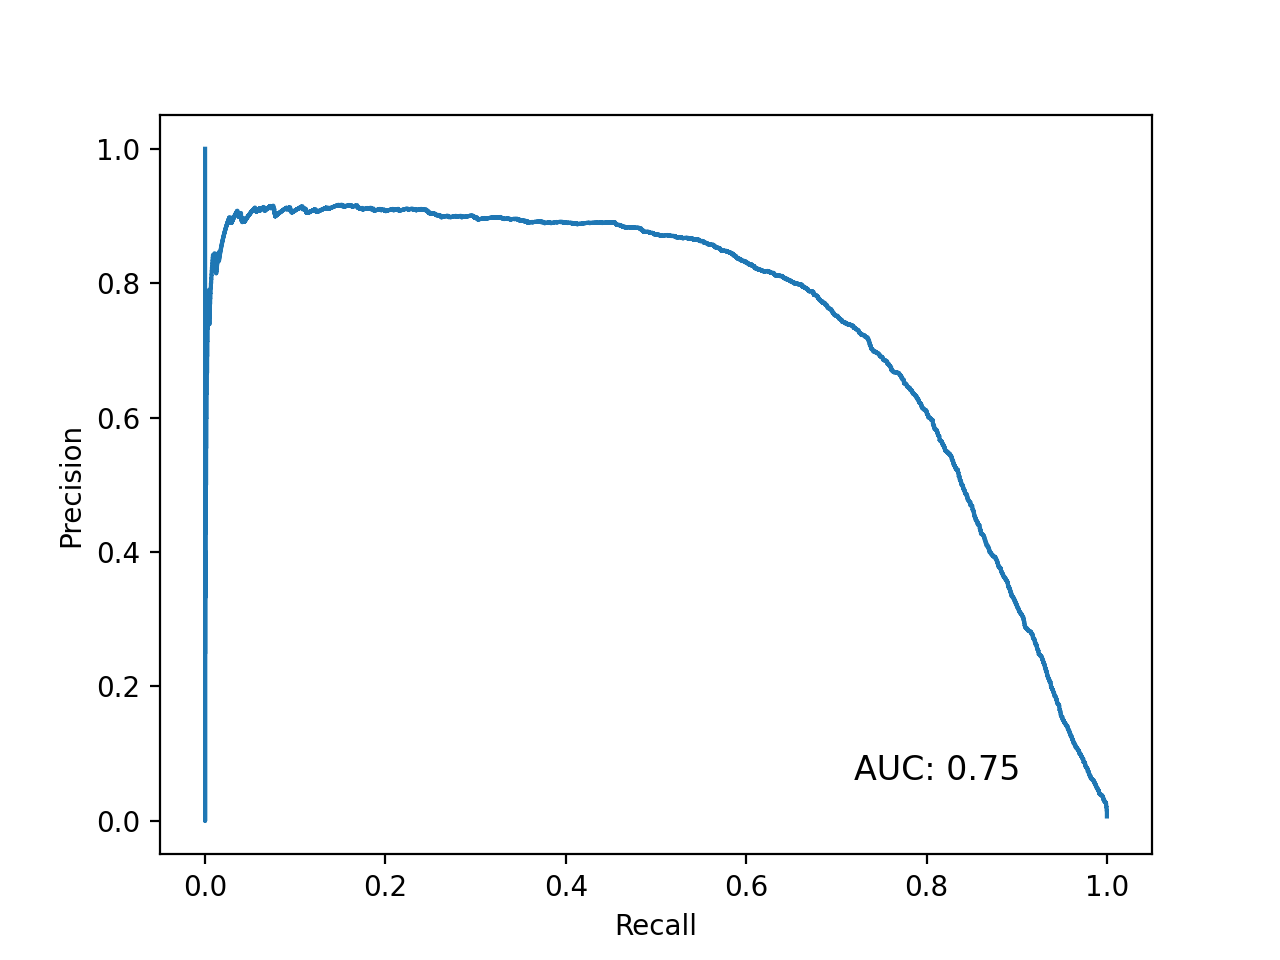

In [129]:
assert all_tRNA_scan_values_mask_based.shape == all_ci_matric_tRNA_values_mask_based.shape

precision_mask_based, recall_mask_based, _ = precision_recall_curve(all_tRNA_scan_values_mask_based, all_ci_matric_tRNA_values_mask_based)

plot_pr_curve(precision_mask_based, recall_mask_based)

In [130]:
tRNA_auc_df = pd.DataFrame({'tRNA_gene_id':tRNA_lm_scan_df.tRNA_gene_id.values, 'auc_tRNA_mask': auroc_list})
tRNA_auc_df

tRNA_gene_id  auc_tRNA_mask
0       tA(AGC)D       0.998811
1       tA(AGC)F       0.998160
2       tA(AGC)G       0.997297
3      tA(AGC)K1       0.997891
4      tA(AGC)K2       0.998294
..           ...            ...
167    tY(GUA)F1       0.997497
168    tY(GUA)F2       0.996971
169    tY(GUA)J2       0.996933
170    tY(GUA)M2       0.996458
171     tY(GUA)O       0.996342

[172 rows x 2 columns]

In [131]:
tRNA_lm_scan_auc_df = tRNA_lm_scan_auc_df.merge(tRNA_auc_df, on='tRNA_gene_id')
tRNA_lm_scan_auc_df

Chromosome Source Feature   Start     End Score Strand Frame tRNA_gene_id  \
0           IV    sgd    gene  410378  410451     .      +     .     tA(AGC)D   
1           VI    sgd    gene  204923  204996     .      -     .     tA(AGC)F   
2          VII    sgd    gene  774348  774421     .      +     .     tA(AGC)G   
3           XI    sgd    gene  219894  219967     .      +     .    tA(AGC)K1   
4           XI    sgd    gene  517987  518060     .      +     .    tA(AGC)K2   
..         ...    ...     ...     ...     ...   ...    ...   ...          ...   
167         VI    sgd    gene  167436  167525     .      +     .    tY(GUA)F1   
168         VI    sgd    gene  210618  210707     .      -     .    tY(GUA)F2   
169          X    sgd    gene  542955  543044     .      -     .    tY(GUA)J2   
170       XIII    sgd    gene  837927  838016     .      +     .    tY(GUA)M2   
171         XV    sgd    gene  288191  288280     .      +     .     tY(GUA)O   

    gene_name  ... tRNA_rel_end_matrix trna_scan_id  \
0         NaN  ...                 406        trna3   
1         NaN  ...                 827        trna6   
2         NaN  ...                 229       trna15   
3         NaN  ...                 644        trna4   
4         NaN  ...                 863        trna9   
..        ...  ...                 ...          ...   
167     SUP11  ...                 733        trna3   
168      SUP6  ...                 682        trna5   
169      SUP4  ...                 547       trna13   
170      SUP8  ...                 830        trna7   
171      SUP3  ...                 383        trna5   

                                    tRNA_scan_sequence  \
0    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
1    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
2    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
3    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
4    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
..                                                 ...   
167  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
168  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
169  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTATCA...   
170  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTACCA...   
171  CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAATTTATCA...   

                                      structure_string score possible_intron  \
0    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
1    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
2    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
3    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
4    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......  69.6           False   
..                                                 ...   ...             ...   
167  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
168  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
169  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
170  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   
171  >>>>>>>..>>>............<<<.>>>>>................  61.3            True   

                                        contact_matrix  auc_tRNA  \
0    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.999214   
1    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.998754   
2    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.998811   
3    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.998620   
4    [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.998792   
..                                                 ...       ...   
167  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.999718   
168  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.999679   
169  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  0.999756   
170  [[tensor(0), tensor(0), ten

## All methods comparison

In [136]:
melted_auroc_df = tRNA_lm_scan_auc_df.melt(id_vars = ['tRNA_gene_id'], 
                         value_vars=['auc_tRNA', 'auc_tRNA_grad', 'auc_tRNA_mask'],
                         var_name='dependency metric', value_name='AUROC')
melted_auroc_df

tRNA_gene_id dependency metric     AUROC
0       tA(AGC)D          auc_tRNA  0.999214
1       tA(AGC)F          auc_tRNA  0.998754
2       tA(AGC)G          auc_tRNA  0.998811
3      tA(AGC)K1          auc_tRNA  0.998620
4      tA(AGC)K2          auc_tRNA  0.998792
..           ...               ...       ...
511    tY(GUA)F1     auc_tRNA_mask  0.997497
512    tY(GUA)F2     auc_tRNA_mask  0.996971
513    tY(GUA)J2     auc_tRNA_mask  0.996933
514    tY(GUA)M2     auc_tRNA_mask  0.996458
515     tY(GUA)O     auc_tRNA_mask  0.996342

[516 rows x 3 columns]

In [137]:
melted_auroc_df['dependency metric'] = melted_auroc_df['dependency metric'].map({
    'auc_tRNA':'Substitution-based',
    'auc_tRNA_grad':'Gradient-based',
    'auc_tRNA_mask':'Mask-based'
})

In [138]:
melted_auroc_df

tRNA_gene_id   dependency metric     AUROC
0       tA(AGC)D  Substitution-based  0.999214
1       tA(AGC)F  Substitution-based  0.998754
2       tA(AGC)G  Substitution-based  0.998811
3      tA(AGC)K1  Substitution-based  0.998620
4      tA(AGC)K2  Substitution-based  0.998792
..           ...                 ...       ...
511    tY(GUA)F1          Mask-based  0.997497
512    tY(GUA)F2          Mask-based  0.996971
513    tY(GUA)J2          Mask-based  0.996933
514    tY(GUA)M2          Mask-based  0.996458
515     tY(GUA)O          Mask-based  0.996342

[516 rows x 3 columns]

In [147]:
melted_auroc_df.to_csv(os.path.join(data_path, 'trna_benchmark_dep_metrics.tsv', sep='\t'))

In [13]:
from plotnine import *
cowplot_theme = theme(
    # Set the background to white and remove panel border
    panel_background=element_blank(),
    panel_border=element_blank(),

    # Light grey grid lines
    panel_grid_major=element_line(color='lightgrey', size=0.5),
    panel_grid_minor=element_blank(),

    # Minimize axis ticks
    axis_ticks=element_blank(),
    axis_text_x=element_text(angle=0, size=12),

    # Simple font
    text=element_text(color='black'),
    figure_size = (7,3.5),
    axis_title_x=element_text(size=12),
    axis_title_y=element_text(size=12)
)

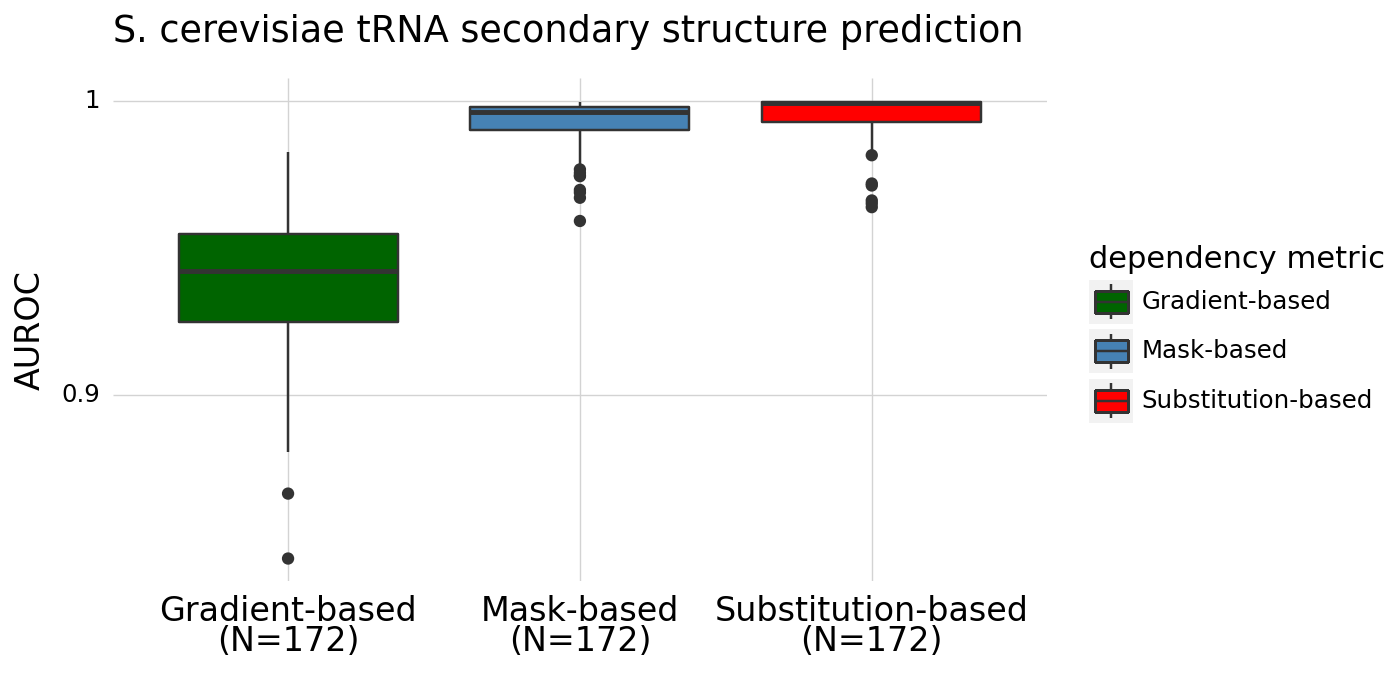

<Figure Size: (700 x 350)>

In [18]:
counts = melted_auroc_df['dependency metric'].value_counts()
melted_auroc_df['dependency metric label'] = melted_auroc_df['dependency metric'].map(lambda x: f"{x}\n(N={counts[x]})")

colors = ['darkgreen', 'steelblue', 'red']
p = (ggplot(melted_auroc_df, aes('dependency metric label', 'AUROC',fill='dependency metric')) 
        +geom_boxplot() 
        +cowplot_theme
        +labs(x='', y='AUROC', color='', title='S. cerevisiae tRNA secondary structure prediction')
        +scale_y_continuous(breaks=np.arange(0.5, 1.1, 0.1))
        + scale_fill_manual(values=colors)
        )
       # +scale_fill_manual(values=["royalblue", "lightblue"]))
p

In [19]:
ggsave(p, 'fig1_de_metrics_trna_pred.png', dpi=500)

/opt/modules/i12g/anaconda/envs/fungi_code/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 3.5 in image.
/opt/modules/i12g/anaconda/envs/fungi_code/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig1_de_metrics_trna_pred.png


In [349]:
assert torch.equal(all_tRNA_scan_values_snp_based, all_tRNA_scan_values_grad_based)
assert torch.equal(all_tRNA_scan_values_grad_based, all_tRNA_scan_values_mask_based)
assert len(all_ci_matric_tRNA_values_snp_based) == len(all_ci_matric_tRNA_values_grad_based) == len(all_ci_matric_tRNA_values_mask_based)

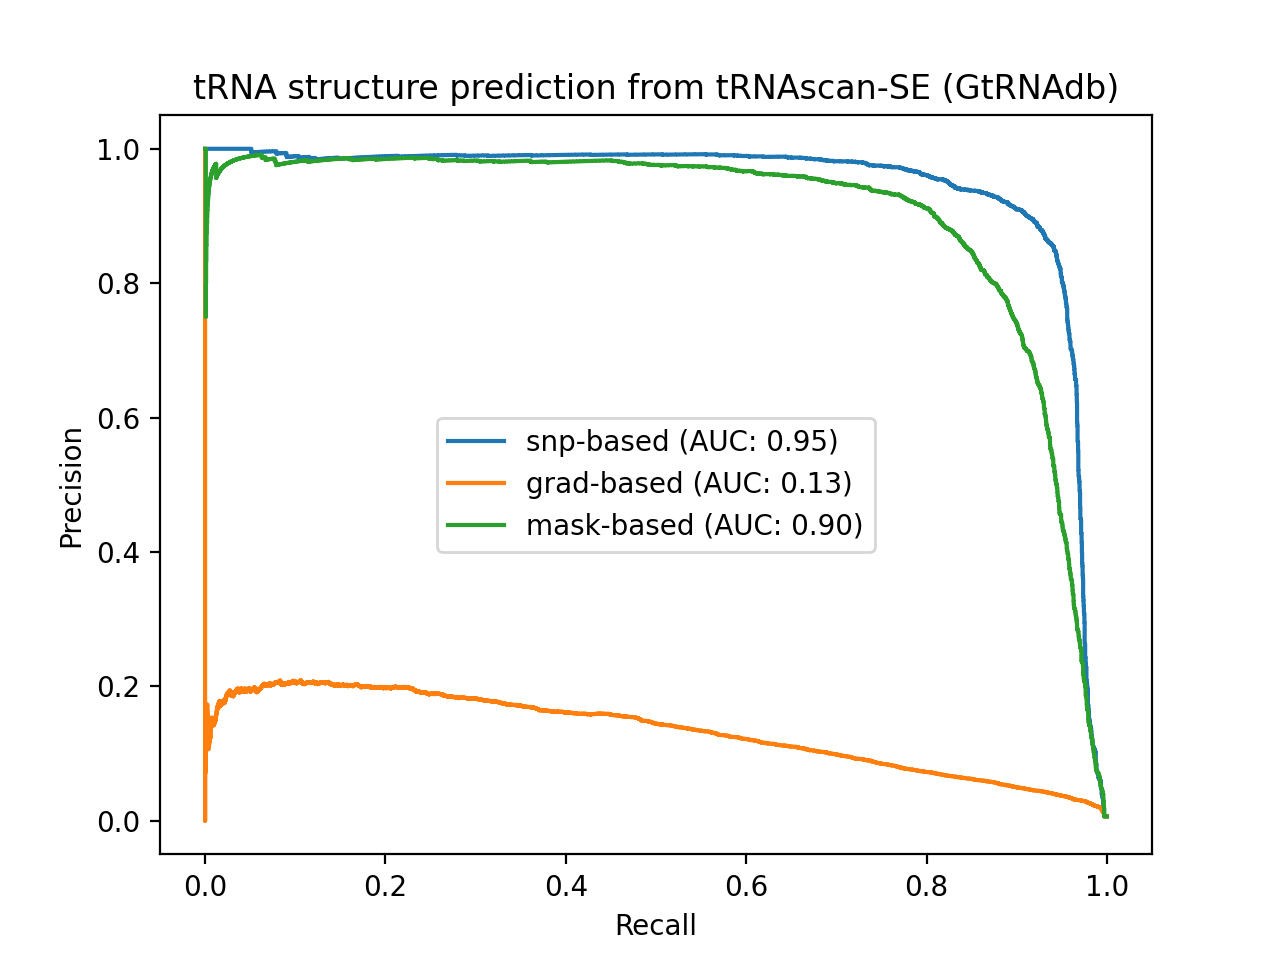

In [374]:
#show the auc in the label of each curve
plt.step(recall_snp_based, precision_snp_based, where='post', label=f'snp-based (AUC: {auc(recall_snp_based, precision_snp_based ):.2f})')
plt.step(recall_grad_based, precision_grad_based, where='post', label=f'grad-based (AUC: {auc(recall_grad_based, precision_grad_based ):.2f})')
plt.step(recall_mask_based, precision_mask_based, where='post', label=f'mask-based (AUC: {auc(recall_mask_based, precision_mask_based ):.2f})')

plt.title('tRNA structure prediction from tRNAscan-SE (GtRNAdb)')
plt.xlabel('Recall')
plt.ylabel('Precision')
# Place the legend outside of the figure/plot
plt.legend()

plt.show()